In [357]:
import numpy as np

import math

import random

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from itertools import combinations

from scipy.stats import ttest_ind

from scipy.stats import chi2_contingency

from termcolor import colored

import os

from collections import Counter

import types
import numbers
import decimal

%matplotlib inline
import warnings; warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 50) # выведем больше строк

pd.set_option('display.max_columns', 50) # выведем больше колонок

print(os.listdir("../input"))
#https://www.pordata.pt/en/DB/Portugal/Search+Environment/Table
#https://realpython.com/numpy-scipy-pandas-correlation-python/#spearman-correlation-coefficient
#https://www.machinelearningmastery.ru/how-to-calculate-nonparametric-rank-correlation-in-python/
#https://www.statisticssolutions.com/table-of-critical-values-pearson-correlation/
#https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/

['imbd-sf', 'UNICEF_stud_math']


-----------------------------------
--------------------------------------
#  Глобальные переменные и функции

In [358]:

df = pd.read_csv('../input/UNICEF_stud_math/stud_math.csv')
df_src = df.copy()
#Глобальные переменные для передачи в df.apply
targetFeature = '' #целевая колонка df, например 'romantic'
filterQuery = '' # условия поиска "похожих" сторк, например '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
N_features ='all' #количество возвращаемых корреляционных коэфф-в "all" - все значимые, 1/2/3/4 - к-во
func ='mostfreq' #функция обработки filterQuery  'mostfreq'/'mean'/'median'


In [359]:
#Создаем столбец для группировок
df['idx'] = df.index

In [360]:
def changeVal(columnsList, oldVal1, newVal1, oldVal2, newVal2, df=df):

    for col in columnsList:
        df[col] = df[col].apply(lambda x: newVal1 if str(x).strip() == oldVal1 and str(x).strip() != oldVal2 else newVal2 if str(x).strip() == oldVal2 and x.strip() != oldVal1 else x)

# Преобразование данные в числовой формат 

In [361]:
changeVal(['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher','internet',	'romantic'],'yes',1,'no',0)
changeVal(['famsize'],'LE3',0,'GT3',1)
changeVal(['Pstatus'],'T',1,'A',0)
changeVal(['address'],'U',1,'R',0)
changeVal(['school'],'GP',1,'MS',0)
changeVal(['sex'],'F',0,'M',1)

In [362]:
def get_boxplot4Val(column):
    try:
        fig, ax = plt.subplots(figsize = (8, 2))
        df.boxplot(column)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + column)
        plt.show()
    except:
        return

In [363]:
def get_his4Val(column, df1=df):
    try:
        fig, ax = plt.subplots(figsize = (10, 3))
        df1[column].hist()#bins = len(df1[column].value_counts()))
        plt.xticks(rotation=45)
        ax.set_title('Hist for ' + column)
        plt.show()
    except:
        return

In [364]:
def get_his4ValDf(column, df1=df):
    try:
        fig, ax = plt.subplots(figsize = (10, 3))
        df1.hist()#bins = len(df1[column].value_counts()))
        plt.xticks(rotation=45)
        ax.set_title('Hist for ' + column)
        plt.show()
    except:
        return

In [365]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (8, 2))
    sns.boxplot(x=column, y='score', 
                data=df,#.loc[cacao.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [366]:
def get_histplot(column, y='score'):
    #fig, ax = plt.subplots(figsize = (14, 4))
    sns.jointplot(x=column, y=y,data=df, kind='reg') 
    # plt.xticks(rotation=45)
    #ax.set_title('Boxplot for ' + column)
    plt.show()

In [367]:
def get_barplot(column, hue, y='score', func=np.median):
    fig, ax = plt.subplots(figsize = (10, 3))
    sns.barplot(y=y, x=column, hue=hue, data=df, estimator=func, ax=ax)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + 'column')
    plt.show()

In [368]:
def get_stat_dif(column, tcolumn = 'score',isSilent = False, nan_policy = 'omit', df = df): 
    #print(f'column {column}, tcolumn {tcolumn}')
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    pvl=[]
    res = False
    for comb in combinations_all:
        statistic, pvalue = ttest_ind(  df.loc[df.loc[:, column] == comb[0], tcolumn], df.loc[df.loc[:, column] == comb[1], tcolumn], nan_policy = nan_policy)#.pvalue
        pvl.append(pvalue)
        if pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            if isSilent == False: print('Найдены статистически значимые различия для колонки', column)
            res = True
            break
    return res
    
    #print(pvl, '---', len(combinations_all))

In [369]:
def isNaN_OK(targetFeature, df = df):
    if len(df[pd.isna(df[targetFeature])].index) == 0 :
         print(f'Все NaN в "{targetFeature}" успешно заменены.')
         return True
    else:
        print(f'НЕ Все NaN в "{targetFeature}" успешно заменены, осталось {len(df[pd.isna(df[targetFeature])].index)} из {len(df[targetFeature].index)}')
        return False

In [370]:
def getMainStatistics(column, returnTuple = False, df1=df):
    '''
    Возвращаем:
    perc25 - 1.5*IQR, perc25, IQR, perc75, perc75 + 1.5*IQR, median, mean, minCol, maxCol
    '''
    median = df1[column].median()
    mean = df1[column].mean()
    minCol = df1[column].min()
    maxCol = df1[column].max()
    perc25 = df1[column].quantile(0.25)
    perc75 = df1[column].quantile(0.75)
    IQR = perc75 - perc25

    if returnTuple:
        return perc25 - 1.5*IQR, perc25, IQR, perc75, perc75 + 1.5*IQR, median, mean, minCol, maxCol
    else:
        print(f'--{column}--  perc25 - 1.5*IQR={perc25 - 1.5*IQR}; perc25={perc25}; IQR={IQR}; perc75={perc75}; perc75 + 1.5*IQR ={perc75 + 1.5*IQR}; median={median}; mean={mean}; min={minCol}; max={maxCol}')
        

In [371]:
def getCorrelationFeatures(col, N_features='all', df1=df):
    #print("N_features ", N_features)
    if df1[col].dtypes == 'O':
        return None
    r_limit = np.round(2/(np.sqrt(len(df1.index))),2)

    r = round(df1.corr(method='kendall'),2) #spearman

    if N_features=='all':
        N_features = len(r)
    else:
        N_features+=1

    r_ser=(r[ (( r > 0)&(r >= r_limit)) | (( r < 0)&(r <= -r_limit))][col].dropna())#.index
    r_ser=r_ser.reindex(r_ser.abs().sort_values(ascending = False).index)[:N_features]
    #r_NamesList=r_ser.index#[:N_features]

    return r_ser

In [372]:
def calcStrFeature(groupbyList, filterQuery, targetFeature, func='mean', silent=False):
    
    res=np.NaN
    grouped_df=df.groupby(groupbyList)['idx'].count().to_frame(name="count").reset_index().query(filterQuery)
    rowsCount = 0
    occurences = 0
    if (len(grouped_df.index) > 0):
        rowsCount = len(grouped_df.index)
        if func == 'mean':
            ggdf=grouped_df.dropna(subset=[targetFeature]).groupby(targetFeature).mean().reset_index()
            # display(ggdf)
            # display(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature] )
            # print('------------')
            occurences =ggdf['count'].max()
            res =  pd.Series(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature])
        elif func == 'median':
            ggdf=grouped_df.dropna(subset=[targetFeature]).groupby(targetFeature).median().reset_index()
            # display(ggdf)
            # display(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature] )
            # print('------------')
            occurences =ggdf['count'].max()
            res =  pd.Series(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature])        
        elif func == 'mostfreq':
            ggdf=grouped_df.dropna(subset=[targetFeature]).groupby(targetFeature).sum().reset_index()
            # display(ggdf)
            # display(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature] )
            # print('------------')
            occurences =ggdf['count'].max()
            res =  pd.Series(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature])
        else:
            res=pd.Series(np.NaN)
    else:
        print('Ничего не нашли похожего')
        res = pd.Series(df.dropna(subset=[targetFeature])[targetFeature].value_counts().idxmax())
        #print(df.dropna(subset=[targetFeature])[targetFeature].value_counts())
    if silent == False:
        print(f'Выбрано {rowsCount} строк; Случаев {occurences};  Значение для {targetFeature}={res.values}')
        display(grouped_df)
        print('-------------------------------------------------------')
    return res.values

In [373]:
def calcNumbFeature(groupbyList, filterQuery, targetFeature, func='mean', silent=False):
    
    res=np.NaN
    grouped_df=df.groupby(groupbyList)['idx'].count().to_frame(name="count").reset_index().query(filterQuery)
    rowsCount = 0
    occurences = 0
    if (len(grouped_df.index) > 0):
        rowsCount = len(grouped_df.index)
        if func == 'mean':
            res = pd.Series(sum(grouped_df[targetFeature])/sum(grouped_df['count']))
        elif func == 'median':
            res = pd.Series(grouped_df[targetFeature].median())         
        elif func == 'mostfreq':
            ggdf=grouped_df.dropna(subset=[targetFeature]).groupby(targetFeature).sum().reset_index()
            # display(ggdf)
            # display(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature] )
            # print('------------')
            occurences =ggdf['count'].max()
            res =  pd.Series(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature])
        else:
            res=pd.Series(np.NaN)
    else:
        print('Ничего не нашли похожего')
        res = pd.Series(df.dropna(subset=[targetFeature])[targetFeature].value_counts().idxmax())
        #print(df.dropna(subset=[targetFeature])[targetFeature].value_counts())
    if silent == False:
        print(f'Выбрано {rowsCount} строк; Случаев {occurences};  Значение для {targetFeature}={res.values.round()}')
        display(grouped_df)
        print('-------------------------------------------------------')
    return res.values.round()

In [374]:
def calc_Feature_basedOnSimilarity():#(targetFeature,filterQuery, func='mostfreq', N_features=5, df1=df):
    corrS = getCorrelationFeatures(col=targetFeature, N_features=N_features)
    #print(corrS, N_features)
    return calcNumbFeature( corrS.index.tolist(), filterQuery, targetFeature, func, silent=False)#[0]


In [375]:
def calc_Feature_basedOnSimilarityROW(row):
    if not pd.isna(row[targetFeature]): return row[targetFeature]
    corrS = getCorrelationFeatures(col=targetFeature, N_features=N_features)
    return calcNumbFeature(corrS.index.tolist(), filterQuery, targetFeature, func, silent=True)[0]
    #row[targetFeature] = calcNumbFeature(corrS.index.tolist(), filterQuery, targetFeature, func, silent=True)[0]

In [376]:
# targetFeature = 'romantic'
# filterQuery ='(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
# filter4TargetGroup = '(age == 15 )'
# N_features = 'all'
# func = 'mostfreq'
def updateFeature(targetFeatureIn,filter4TargetGroupIn, filterQueryIn, funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=False ):
    '''
    Пакетное обновление выбранных строк, изменение заданных значений столбцов (targetFeatureIn) по принципу поиска похожих строк

    targetFeatureIn -- целевая колонка df, например 'romantic'
    filter4TargetGroupIn -- фильтр для группы записей к которым применяется изменение заданных значений столбцов, например '(age == 15 )'
    filterQueryIn -- условия поиска "похожих" сторк, например '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
    N_features -- количество возвращаемых корреляционных коэфф-в, например "all" - все значимые, 1/2/3/4 - к-во
    func -- функция обработки filterQuery, например 'mostfreq'/'mean'/'median'
    displayHist -- отрисовывать гистограммы распреления признака ДО и ПОСЛЕ обработки
    '''
    displayHist=False
    print(f'БЫЛО {targetFeatureIn} NaN = {len(df[pd.isna(df[targetFeatureIn])].index)}') 
  
    if displayHist: 
        display(getCorrelationFeatures(col=targetFeatureIn))
        get_his4Val(targetFeatureIn)

    global targetFeature
    targetFeature = targetFeatureIn

    global filterQuery
    filterQuery = filterQueryIn

    global N_features
    N_features = N_featuresIn


    df_TargetGroup=df[pd.isna(df[targetFeatureIn])].query(filter4TargetGroupIn)
    df[targetFeatureIn].update(df_TargetGroup.apply(calc_Feature_basedOnSimilarityROW, axis=1))

    if displayHist:
        display(getCorrelationFeatures(col=targetFeatureIn))
        get_his4Val(targetFeatureIn)

    print(f'СТАЛО {targetFeatureIn} NaN = {len(df[pd.isna(df[targetFeatureIn])].index)}')

In [377]:
def updateFeatureAuto(targetFeature, filterFields, isStr=True, isSilent = False ):
    '''
    Применяем выбранные столбцы для поиска строк "близнецов" для каждой строки с NaN, если такие находятся, то берется самое частотное значение, иначе самое частотное значение по всему датасету. 
    '''

    print(f'NaN в "{targetFeature}"  {len(df[pd.isna(df[targetFeature])].index)} ')

    dfNaN = df[pd.isna(df[targetFeature])]

    for index, row1 in dfNaN.iterrows():

        filterS = ' & '.join( [ f'({field} == {row1[field]})'  if ( isinstance(row1[field], numbers.Number)  or isinstance(row1[field], decimal.Decimal)) else f'({field} == "{row1[field]}")'  for field in filterFields]) 

        if isSilent == False: print(f'filter = {filterS}; index = {index}')
        if  'nan' in filterS: continue

        gb = filterFields.copy()
        gb.insert(0,targetFeature)

        if (isStr):
            res= calcStrFeature(groupbyList=gb, filterQuery=filterS, targetFeature=targetFeature,  func='mostfreq',silent=isSilent)
        else:
            res= calcNumbFeature(groupbyList=gb, filterQuery=filterS, targetFeature=targetFeature,  func='mostfreq',silent=isSilent)


        df.loc[index,targetFeature] = res[0]

    if not isNaN_OK(targetFeature):
        res = pd.Series(df.dropna(subset=[targetFeature])[targetFeature].value_counts().idxmax())
        df[targetFeature] = df.apply(lambda x: res[0] if pd.isna(x[targetFeature]) else x[targetFeature], axis=1)
        isNaN_OK(targetFeature)
    print(f'----------------------- Проверка распределения {targetFeature} после устранения NaN')
    get_his4Val(targetFeature)

In [378]:
def get_FeaturesAuto(targetFeature):
    '''
    Атоматически выбираем столбцы, наиболее влияющие на желаемый столбец (С посмощью модифицтрованной функции get_stat_dif (ttest_ind)).  
    '''
    #targetFeature = 'Mjob'

    print(f'NaN в "{targetFeature}" = { round( len(df[pd.isna(df[targetFeature])].index) /len(df.index) * 100)}% ')
    stat_dif_list = []
    err_col_list = []
    cols = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu','Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime','failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery','studytime granular', 'higher', 'internet', 'romantic', 'famrel','freetime', 'goout', 'health', 'absences', 'score']

    if targetFeature in cols: cols.remove(targetFeature)
 
    for col in cols:
        try:
            if get_stat_dif( targetFeature, col, isSilent = True): stat_dif_list.append(col)
        except:

            err_col_list.append(col)
    
    if len(stat_dif_list) > 1:
        
        stat_dif_list.insert(0, targetFeature)
        
        print('Исходное распределение')
        get_his4Val(targetFeature)

        print('Предложенное АВТО распределение')
        get_his4ValDf(targetFeature, df.groupby(stat_dif_list)['idx'].count().reset_index()[targetFeature])
        
        stat_dif_list.remove(targetFeature)      
        print('Выбранные колонки', stat_dif_list)
        print('Колонки для ручного анализа',err_col_list)

    else:
        print('Выбранные колонки', stat_dif_list)
        print('Колонки для ручного анализа',err_col_list)
    return stat_dif_list, err_col_list


In [379]:
def test_FeaturesAutoHist(targetFeature, features_list):
    print('Распределение с учетом оптимизации параметров')
    get_his4ValDf(targetFeature, df.groupby([targetFeature]+features_list)['idx'].count().reset_index()[targetFeature])

In [380]:
def autho_correct_NaN(thresholdPerc = 5):
    '''
    Автоматическая обработка NaN 

    thresholdPerc = 5 - порог в 5%, по умолчанию, для автоматической обработки NaN
    1. С посмощью модифицтрованной функции get_stat_dif (ttest_ind) автоматически выбираем столбцы, наиболее влияющие на желаемый столбец.  
    2. Применяем выбранные столбцы для поиска строк "близнецов" для каждой строки с NaN, если такие находятся, то берется самое частотное значение, иначе самое частотное значение по всему датасету. 
    '''
    thresholdPerc = 5
    for targetFeature in df.columns:
        nanPerc = round( len(df[pd.isna(df[targetFeature])].index) /len(df.index) * 100)
        if  0 < nanPerc <= thresholdPerc:
            try:
                print(colored(f'\nВ колонке {targetFeature} {nanPerc}% NaN, автоматически исправляем', 'green'))
                ok_list, test_list = get_FeaturesAuto(targetFeature)
                updateFeatureAuto(targetFeature, ok_list)
            except:
                print(colored(f'Ошибка при обработке {targetFeature}','red'))


In [381]:
def test_ds_NaN(df=df):
    notOKlist=[]
    for col in df.columns:
        if not isNaN_OK(col, df): notOKlist.append(col)
    if len(notOKlist) == 0:
        print(colored('Столбцов с NaN не осталось','green'))
    else:
        print(colored(f'\nС NaN остались {notOKlist}','red'))

In [382]:
def test_df_stat_dif(df=df, tcolumn='score', nan_policy='omit', cols2remove=[]):
    columns = df.columns.tolist().copy()
    if len(cols2remove) != 0: columns.remove(cols2remove)
    if tcolumn in columns: columns.remove(tcolumn)
    for col in columns:
        get_stat_dif(col,tcolumn=tcolumn,nan_policy=nan_policy,df=df )

--------------------------------------------
--------------------------------------------------------
#  Ищем потенциальные вылеты и странности, оцениваем распределение

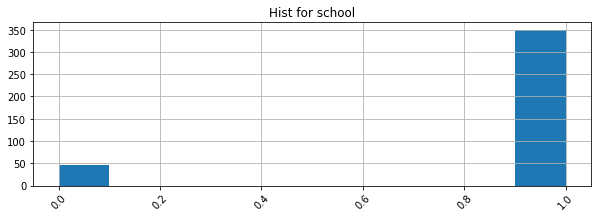

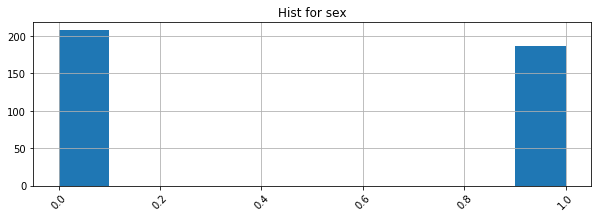

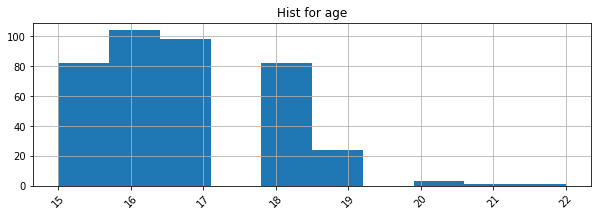

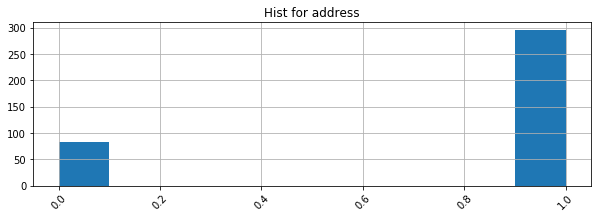

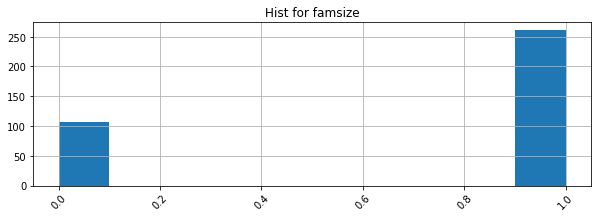

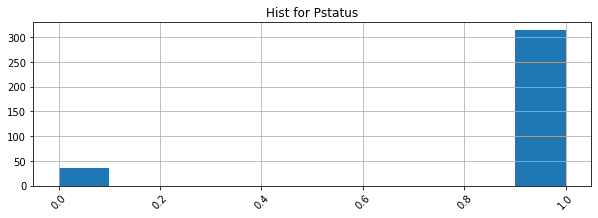

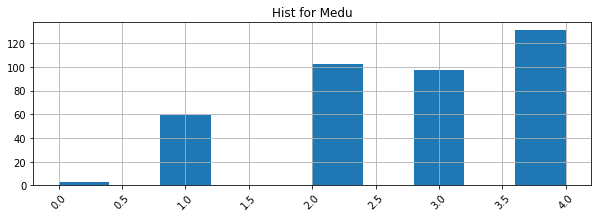

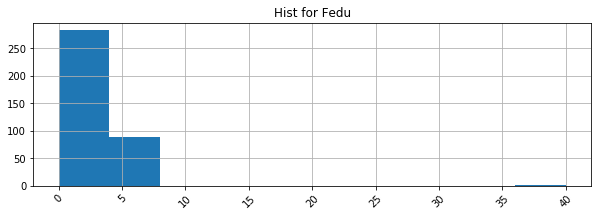

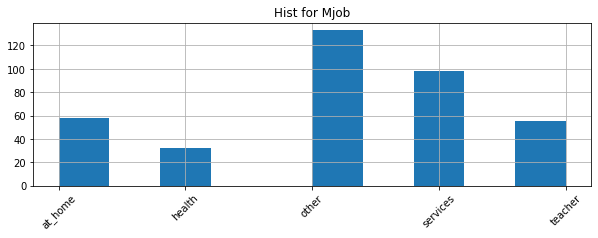

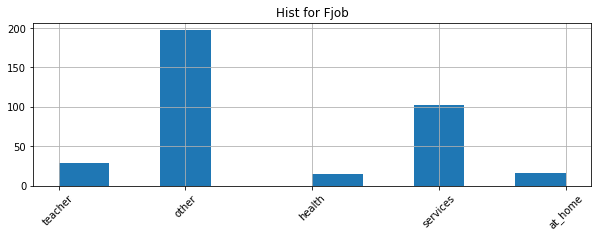

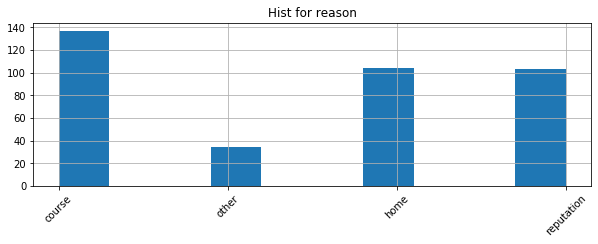

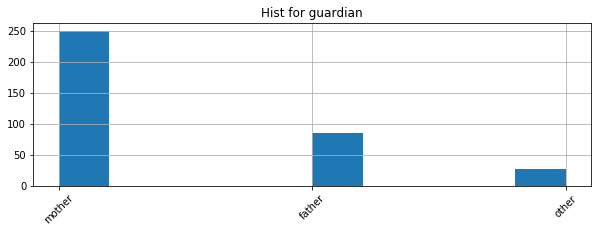

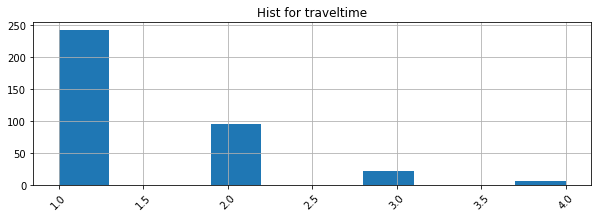

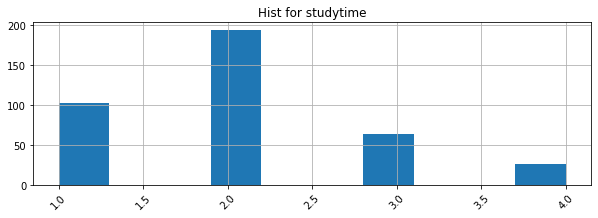

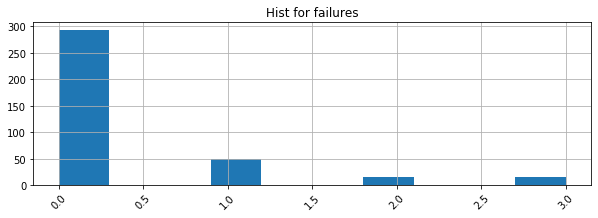

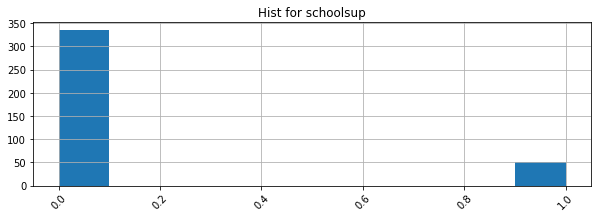

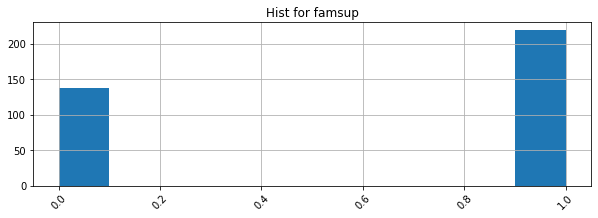

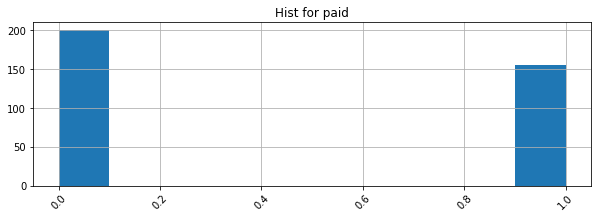

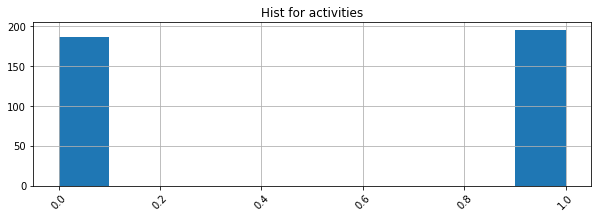

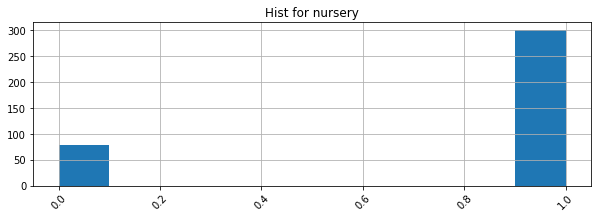

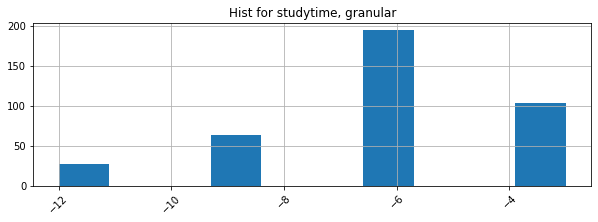

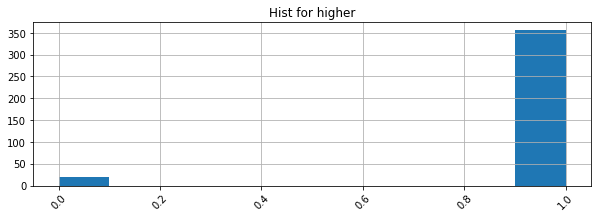

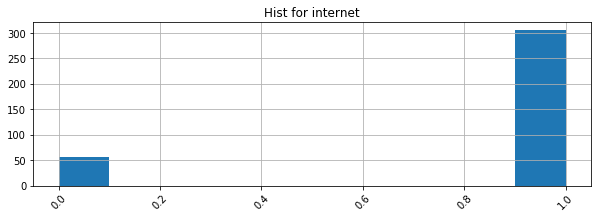

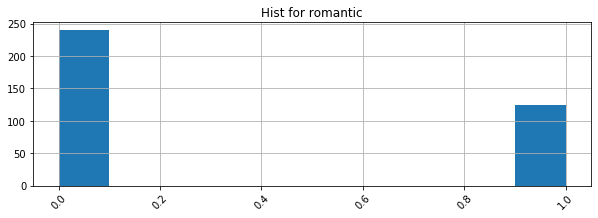

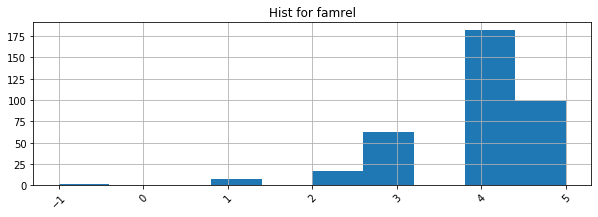

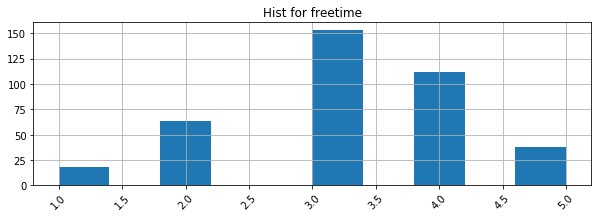

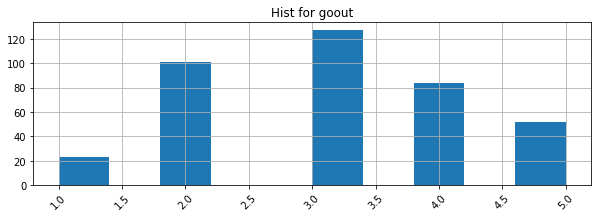

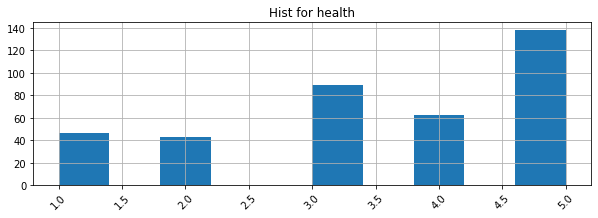

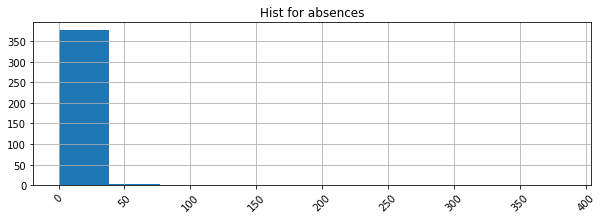

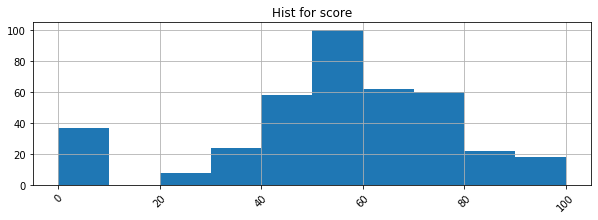

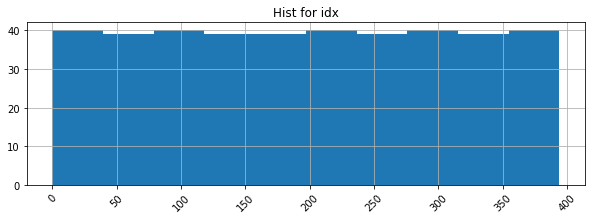

In [383]:
#Ищем потенциальные вылеты и странности, оцениваем распределение и пропорции - done!
for col in df.columns:
    get_his4Val(col)

---------------------------------------------------------------
# Образованию отца <strong><i>Fedu</i></strong>
Убираем вылет принимаем, что ошиблись при вводе. ввели 40 д.б. 4.0 Уровень образования 0-оставляем т.к. он есть в классификации и встречается в жизни. 

In [384]:
df.loc[df.Fedu == 40,'Fedu'] = 4

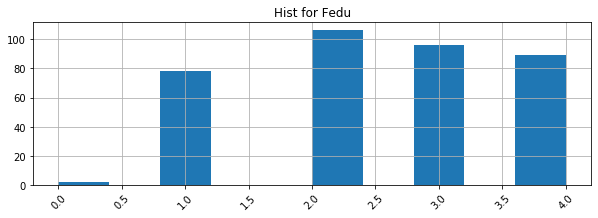

In [385]:
get_his4Val('Fedu')

----------------------------------------------------------------------------
#  Проверяем <strong><i>age</i></strong>

--age--  perc25 - 1.5*IQR=13.0; perc25=16.0; IQR=2.0; perc75=18.0; perc75 + 1.5*IQR =21.0; median=17.0; mean=16.696202531645568; min=15; max=22


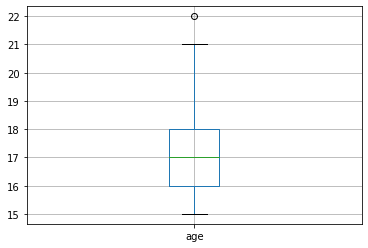

In [386]:
df.boxplot('age')
getMainStatistics('age')

df.age >18 #Старше 18 лет 29чел. 7% от общего числа и все похожи на "живых людей"

----------------------------------------------------------------
<strong><i>famrel</i></strong> Есть 1 выброс -1 - предполагаем, что ошибка ввода или так плохо в семье :) - назначаем наиболее логичное значение 


In [387]:
df.loc[df.famrel < 1,'famrel'] = 1


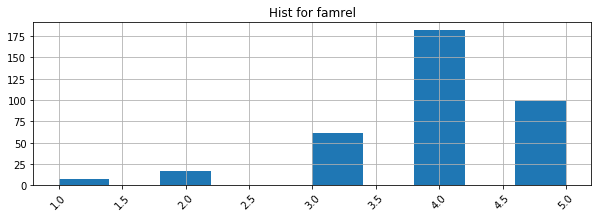

In [388]:
get_his4Val('famrel')

---------------------------------------------------
#  Прогулы <strong><i>abscences</i></strong>
Предполагаю, что это к-во занятий, а не дней. Вылетов (всё что больше perc75 + 1.5*IQR) всего 4.3% Если исходить из того, что чебный год в длится, как правило, 170-180 дней и absences - это количество пропущенных ЛЮБЫХ учебных занятий, то даже 385 занятий - это 2-3 пропущенных занятия в день. Логичных причин может быть много, например освобождение от занятий в связи с домашним обучением и/или результатами или просто прогулами, таких всего 0.5%. 

Для упрощения понимания общей картины, всё равно заменим  "вылеты" более 75 на медианное значение. 

--absences--  perc25 - 1.5*IQR=-12.0; perc25=0.0; IQR=8.0; perc75=8.0; perc75 + 1.5*IQR =20.0; median=4.0; mean=7.2793733681462145; min=0.0; max=385.0


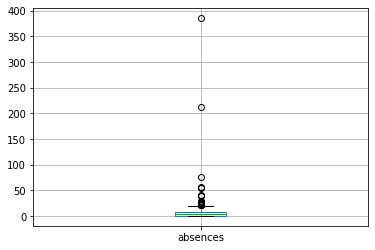

In [389]:
df.boxplot('absences')
getMainStatistics('absences')
#df[df.absences > 20]

absences подверглось обработке  0.51 %
--absences--  perc25 - 1.5*IQR=-12.0; perc25=0.0; IQR=8.0; perc75=8.0; perc75 + 1.5*IQR =20.0; median=4.0; mean=5.741514360313316; min=0.0; max=75.0


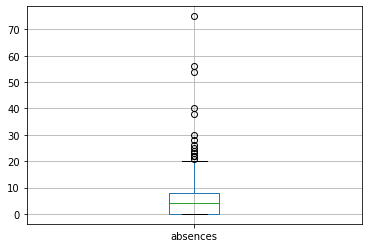

In [390]:
print('absences подверглось обработке ',round(len(df[df.absences > 75])/len(df.index) * 100,2),'%') #20
 
df.loc[df.absences > 75,'absences'] = df.absences.median() #20
df.boxplot('absences')
getMainStatistics('absences')

-----------------------------
# До устранения NaN только 1 колонка значимая

In [391]:
test_df_stat_dif(df=df, nan_policy='propagate',cols2remove='idx')


Найдены статистически значимые различия для колонки Mjob


----------------------------------------
# Устраняем NaN score - удаляем, т.к. восстанавливать целевое значение непраильно, и всего их 1.5%

In [392]:
df.dropna(subset=['score'], inplace=True)


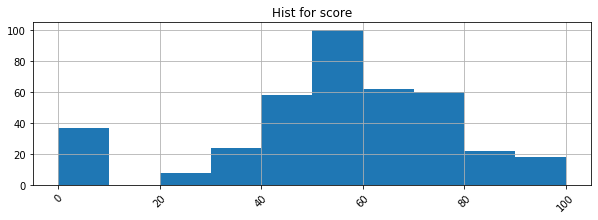

In [393]:
get_his4Val('score')

In [394]:
df.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64

У score есть группа со значение 0. Это похоже на группу ученииков не набравших минимального уровня для зачета и/или неявка на экзамен. 
# Минимальный проходной балл по математике = 20  

------------------------------
# Поиск статистически значимыех различий для колонок ДО устранения NaN и выбросов (nan_policy='propagate')  
Удаление NaN score сразу добавляет ещё 6 значимых колонок (ещё до устранения NaN в других столбцах)

In [395]:
test_df_stat_dif(df=df, nan_policy='propagate', cols2remove='idx')

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout


-------------------------------------------------------------------------------
------------------------------------------------
#  Выбор способов устранения NaN

In [396]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 31 columns):
school                 389 non-null int64
sex                    389 non-null int64
age                    389 non-null int64
address                374 non-null float64
famsize                362 non-null float64
Pstatus                344 non-null float64
Medu                   386 non-null float64
Fedu                   365 non-null float64
Mjob                   370 non-null object
Fjob                   353 non-null object
reason                 372 non-null object
guardian               358 non-null object
traveltime             361 non-null float64
studytime              382 non-null float64
failures               367 non-null float64
schoolsup              380 non-null float64
famsup                 351 non-null float64
paid                   350 non-null float64
activities             375 non-null float64
nursery                374 non-null float64
studytime, granular    38

Выбираем несколько записей с NaN по address && internet && traveltime && failures && Medu && score - для отработки способов устранения NaN

In [397]:
display(df.loc[ (df.index!=-1) & (pd.isna(df.address)) & ( (pd.isna(df.internet)) | (pd.isna(df.traveltime)) | (pd.isna(df.failures)) | (pd.isna(df.Medu)) | (pd.isna(df.score)) )])

school  sex  age  address  famsize  Pstatus  Medu  Fedu     Mjob  \
52        1    1   15      NaN      0.0      0.0   4.0   2.0   health   
92        1    0   16      NaN      0.0      1.0   NaN   1.0    other   
241       1    1   17      NaN      0.0      0.0   4.0   4.0  teacher   
348       1    0   17      NaN      1.0      1.0   4.0   3.0   health   
372       0    0   17      NaN      1.0      1.0   2.0   2.0    other   

        Fjob      reason guardian  traveltime  studytime  failures  schoolsup  \
52       NaN       other   father         2.0        1.0       1.0        0.0   
92     other        home   father         1.0        2.0       0.0        1.0   
241    other      course   mother         NaN        2.0       0.0        0.0   
348    other  reputation   mother         NaN        3.0       0.0        0.0   
372  at_home        home   mother         NaN        3.0       0.0        0.0   

     famsup  paid  activities  nursery  studytime, granular  higher  internet  \
52      NaN   0.0         0.0      1.0                 -3.0     1.0       NaN   
92      1.0   0.0         0.0      1.0                 -6.0     1.0       0.0   
241     1.0   1.0         0.0      1.0                 -6.0     1.0       1.0   
348     1.0   1.0         1.0      1.0                 -9.0     1.0       1.0   
372     0.0   0.0         1.0      1.0                 -9.0     1.0       0.0   

     romantic  famrel  freetime  goout  health  absences  score  idx  
52        0.0     5.0       5.0    5.0     5.0       6.0   50.0   52  
92        0.0     3.0       3.0    NaN     2.0       4.0   30.0   92  
241       0.0     3.0       3.0    NaN     4.0       2.0   60.0  241  
348       1.0     NaN       4.0    3.0     4.0       0.0   75.0  348  
372       NaN     3.0       4.0    3.0     3.0       8.0   55.0  372

In [398]:


df.loc[ (df.index==92) , ['address','Medu']]=[0, 1] # по всем признакам это address=R, Medu=1 для этой группы образования

df.loc[ (df.index==52) , ['address','Fjob', 'famsup', 'internet']]=[0, 'other', 0, 0] # по всем признакам это address=R, Fjob=other исходя из Образование, работа матери + образование отца для выяснениия возможной работы отца, famsup =0 т.к. разведенные родители, ребенок живет с отцом, отец с невысоким уровнем образования

df.loc[ (df.index==241) , ['address','traveltime', 'goout']]=[1, 1, 3] # по всем признакам это address=U traveltime =1 как самое распространенное для U; df[(df.freetime==3) & (df.age==17)].groupby([ 'freetime', 'age', 'score', 'failures', 'internet','goout'])['age'].count() - 3 для goout

df.loc[ (df.index==270) , ['address','score', 'goout', 'score']]=[1, 1, 3, 30]

df.loc[ (df.index==348) , ['address','famrel']]=[1, 4] #calcNumbFeature(groupbyList=['famrel', 'freetime', 'age', 'sex'], filterQuery=' (freetime ==4) & (age == 17) & (sex == 0) ', targetFeature='famrel',  func='mostfreq', silent=False)[0]

df.loc[ (df.index==350) , ['address','nursery', 'score']]=[0, 0, 50]  

df.loc[ (df.index==372) , ['address','traveltime', 'romantic']]=[1, 1, 0] 
print (len(df.loc[ (df.index!=-1) & (pd.isna(df.address)) & ( (pd.isna(df.internet)) | (pd.isna(df.traveltime)) | (pd.isna(df.failures)) | (pd.isna(df.Medu)) | (pd.isna(df.score)) )].index))

0


---------------------------------------------------------------
# Устраняем (автоматически) NaN при количестве пропусков менее 5%
autho_correct_NaN():  
1. С посмощью модифицтрованной функции get_stat_dif (ttest_ind) автоматически выбираем столбцы, наиболее влияющие на желаемый столбец.  
2. Применяем выбранные столбцы для поиска строк "близнецов" для каждой строки с NaN, если такие находятся, то берется самое частотное значение, иначе самое частотное значение по всему датасету. 


В колонке address 3% NaN, автоматически исправляем
NaN в "address" = 3% 
Исходное распределение


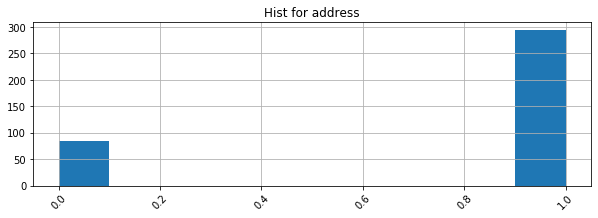

Предложенное АВТО распределение


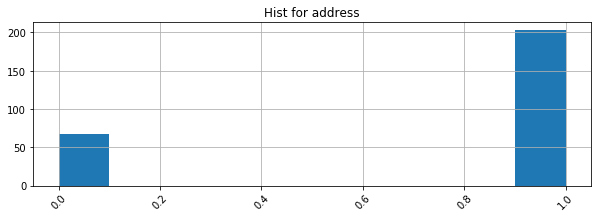

Выбранные колонки ['school', 'age', 'Medu', 'traveltime', 'failures', 'internet', 'score']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "address"  10 
filter = (school == 1) & (age == 16) & (Medu == 2.0) & (traveltime == 1.0) & (failures == 0.0) & (internet == 1.0) & (score == 55.0); index = 6
Выбрано 1 строк; Случаев 1;  Значение для address=[1.]


address  school  age  Medu  traveltime  failures  internet  score  count
139      1.0       1   16   2.0         1.0       0.0       1.0   55.0      1

-------------------------------------------------------
filter = (school == 1) & (age == 15) & (Medu == 4.0) & (traveltime == 1.0) & (failures == 0.0) & (internet == 1.0) & (score == 50.0); index = 75
Выбрано 1 строк; Случаев 2;  Значение для address=[1.]


address  school  age  Medu  traveltime  failures  internet  score  count
112      1.0       1   15   4.0         1.0       0.0       1.0   50.0      2

-------------------------------------------------------
filter = (school == 1) & (age == 16) & (Medu == 4.0) & (traveltime == 2.0) & (failures == 0.0) & (internet == 1.0) & (score == 75.0); index = 96
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (age == 16) & (Medu == 3.0) & (traveltime == 1.0) & (failures == 1.0) & (internet == 1.0) & (score == 60.0); index = 159
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (age == 16) & (Medu == 2.0) & (traveltime == 1.0) & (failures == 0.0) & (internet == 1.0) & (score == 0.0); index = 168
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (age == 17) & (Medu == 2.0) & (traveltime == 1.0) & (failures == 0.0) & (internet == 1.0) & (score == 60.0); index = 254
Выбрано 1 строк; Случаев 1;  Значение для address=[1.]


address  school  age  Medu  traveltime  failures  internet  score  count
198      1.0       1   17   2.0         1.0       0.0       1.0   60.0      1

-------------------------------------------------------
filter = (school == 1) & (age == 18) & (Medu == 2.0) & (traveltime == 1.0) & (failures == 1.0) & (internet == 1.0) & (score == 65.0); index = 292
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (age == 17) & (Medu == 4.0) & (traveltime == 2.0) & (failures == 0.0) & (internet == 1.0) & (score == 55.0); index = 354
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (age == 18) & (Medu == 1.0) & (traveltime == 2.0) & (failures == 0.0) & (internet == 1.0) & (score == 80.0); index = 359
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (age == 20) & (Medu == 4.0) & (traveltime == 2.0) & (failures == 2.0) & (internet == 1.0) & (score == 75.0); index = 376
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для address=[1.]


Empty DataFrame
Columns: [address, school, age, Medu, traveltime, failures, internet, score, count]
Index: []

-------------------------------------------------------
Все NaN в "address" успешно заменены.
----------------------- Проверка распределения address после устранения NaN


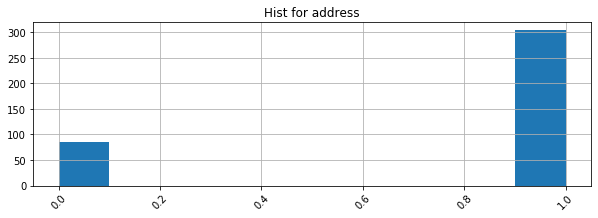


В колонке Medu 1% NaN, автоматически исправляем
NaN в "Medu" = 1% 
Исходное распределение


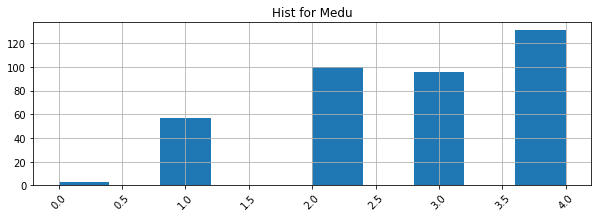

Предложенное АВТО распределение


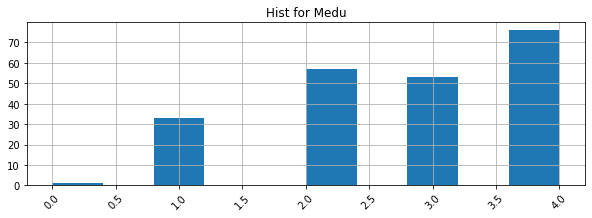

Выбранные колонки ['school', 'age', 'address', 'Fedu', 'traveltime', 'failures', 'famsup', 'paid', 'nursery', 'higher', 'internet', 'score']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "Medu"  2 
filter = (school == 1) & (age == 16) & (address == 0.0) & (Fedu == 3.0) & (traveltime == 1.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 0.0) & (nursery == 1.0) & (higher == 1.0) & (internet == 1.0) & (score == 50.0); index = 193
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Medu=[4.]


Empty DataFrame
Columns: [Medu, school, age, address, Fedu, traveltime, failures, famsup, paid, nursery, higher, internet, score, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (age == 18) & (address == 1.0) & (Fedu == 2.0) & (traveltime == 1.0) & (failures == 1.0) & (famsup == 0.0) & (paid == 0.0) & (nursery == 1.0) & (higher == 0.0) & (internet == nan) & (score == 0.0); index = 239
НЕ Все NaN в "Medu" успешно заменены, осталось 1 из 389
Все NaN в "Medu" успешно заменены.
----------------------- Проверка распределения Medu после устранения NaN


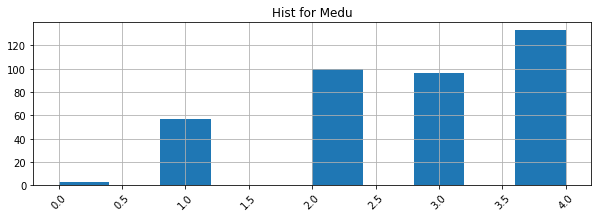


В колонке Mjob 5% NaN, автоматически исправляем
NaN в "Mjob" = 5% 
Исходное распределение


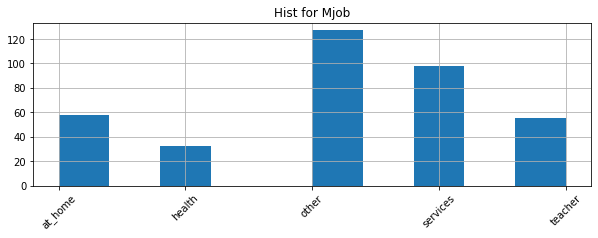

Предложенное АВТО распределение


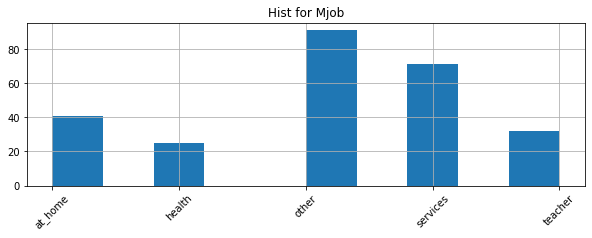

Выбранные колонки ['sex', 'address', 'Medu', 'Fedu', 'failures', 'paid', 'internet', 'score']
Колонки для ручного анализа ['Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "Mjob"  19 
filter = (sex == 1) & (address == 1.0) & (Medu == 4.0) & (Fedu == 4.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 55.0); index = 29
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 3.0) & (Fedu == 3.0) & (failures == nan) & (paid == 1.0) & (internet == 1.0) & (score == 65.0); index = 54
filter = (sex == 0) & (address == 1.0) & (Medu == 4.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 0.0) & (internet == 1.0) & (score == 80.0); index = 59
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 1.0) & (Medu == 2.0) & (Fedu == 2.0) & (failures == 1.0) & (paid == 1.0) & (internet == 1.0) & (score == 50.0); index = 88
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 1.0) & (Medu == 3.0) & (Fedu == 4.0) & (failures == 0.0) & (paid == nan) & (internet == 1.0) & (score == 90.0); index = 104
filter = (sex == 1) & (address == 0.0) & (Medu == 2.0) & (Fedu == 2.0) & (failures == 2.0) & (paid == 0.0) & (internet == 1.0) & (score == 0.0); index = 128
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 1.0) & (Fedu == 1.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 55.0); index = 145
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 0.0) & (Medu == 1.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 0.0) & (internet == 0.0) & (score == 65.0); index = 156
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 1.0) & (Medu == 2.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 0.0) & (internet == 1.0) & (score == 50.0); index = 166
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 3.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 45.0); index = 174
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 1.0) & (Medu == 3.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 0.0) & (internet == 1.0) & (score == 30.0); index = 177
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 2.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 50.0); index = 219
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 4.0) & (Fedu == 4.0) & (failures == 0.0) & (paid == 0.0) & (internet == 1.0) & (score == 70.0); index = 224
Выбрано 1 строк; Случаев 1;  Значение для Mjob=['health']


Mjob  sex  address  Medu  Fedu  failures  paid  internet  score  count
51  health    0      1.0   4.0   4.0       0.0   0.0       1.0   70.0      1

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 4.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 90.0); index = 260
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 0.0) & (Medu == 3.0) & (Fedu == 4.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 85.0); index = 265
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 1.0) & (Medu == 4.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 50.0); index = 268
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (address == 1.0) & (Medu == 4.0) & (Fedu == 4.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 45.0); index = 277
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 4.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 75.0); index = 291
Выбрано 2 строк; Случаев 1;  Значение для Mjob=['health' 'services']


Mjob  sex  address  Medu  Fedu  failures  paid  internet  score  \
49     health    0      1.0   4.0   3.0       0.0   1.0       1.0   75.0   
202  services    0      1.0   4.0   3.0       0.0   1.0       1.0   75.0   

     count  
49       1  
202      1

-------------------------------------------------------
filter = (sex == 0) & (address == 1.0) & (Medu == 3.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 1.0) & (internet == 1.0) & (score == 0.0); index = 337
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Mjob=['other']


Empty DataFrame
Columns: [Mjob, sex, address, Medu, Fedu, failures, paid, internet, score, count]
Index: []

-------------------------------------------------------
НЕ Все NaN в "Mjob" успешно заменены, осталось 2 из 389
Все NaN в "Mjob" успешно заменены.
----------------------- Проверка распределения Mjob после устранения NaN


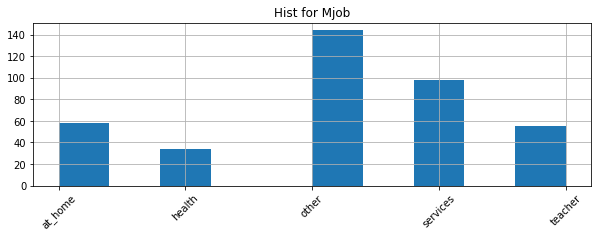


В колонке reason 4% NaN, автоматически исправляем
NaN в "reason" = 4% 
Исходное распределение


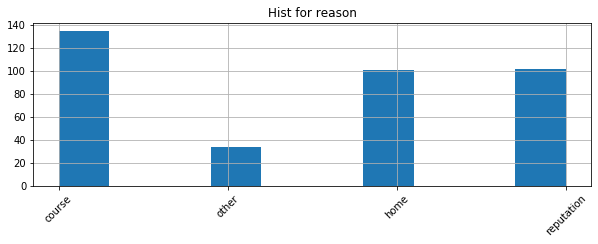

Предложенное АВТО распределение


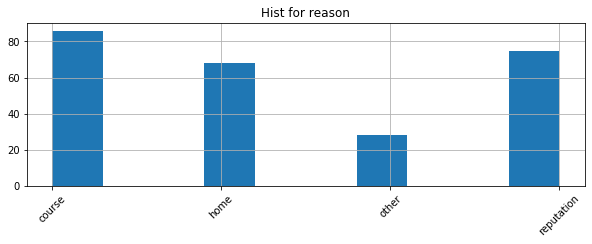

Выбранные колонки ['school', 'address', 'studytime', 'higher', 'health', 'absences']
Колонки для ручного анализа ['Mjob', 'Fjob', 'guardian', 'studytime granular']
NaN в "reason"  17 
filter = (school == 1) & (address == 1.0) & (studytime == 2.0) & (higher == 1.0) & (health == 2.0) & (absences == 0.0); index = 33
Выбрано 2 строк; Случаев 3;  Значение для reason=['home' 'reputation']


reason  school  address  studytime  higher  health  absences  count
117        home       1      1.0        2.0     1.0     2.0       0.0      3
221  reputation       1      1.0        2.0     1.0     2.0       0.0      3

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 3.0) & (higher == 1.0) & (health == 4.0) & (absences == 2.0); index = 63
Выбрано 1 строк; Случаев 1;  Значение для reason=['home']


reason  school  address  studytime  higher  health  absences  count
147   home       1      1.0        3.0     1.0     4.0       2.0      1

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 1.0) & (higher == 1.0) & (health == 5.0) & (absences == 2.0); index = 73
Выбрано 2 строк; Случаев 2;  Значение для reason=['course']


reason  school  address  studytime  higher  health  absences  count
45   course       1      1.0        1.0     1.0     5.0       2.0      2
109    home       1      1.0        1.0     1.0     5.0       2.0      1

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 4.0) & (higher == 1.0) & (health == 3.0) & (absences == 0.0); index = 77
Выбрано 2 строк; Случаев 1;  Значение для reason=['course' 'reputation']


reason  school  address  studytime  higher  health  absences  count
83       course       1      1.0        4.0     1.0     3.0       0.0      1
251  reputation       1      1.0        4.0     1.0     3.0       0.0      1

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == nan) & (higher == 1.0) & (health == 5.0) & (absences == 6.0); index = 112
filter = (school == 1) & (address == 1.0) & (studytime == 1.0) & (higher == 1.0) & (health == 5.0) & (absences == 0.0); index = 137
Выбрано 3 строк; Случаев 5;  Значение для reason=['course']


reason  school  address  studytime  higher  health  absences  count
44   course       1      1.0        1.0     1.0     5.0       0.0      5
108    home       1      1.0        1.0     1.0     5.0       0.0      4
171   other       1      1.0        1.0     1.0     5.0       0.0      3

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 2.0) & (higher == 1.0) & (health == 5.0) & (absences == 0.0); index = 138
Выбрано 3 строк; Случаев 3;  Значение для reason=['reputation']


reason  school  address  studytime  higher  health  absences  count
68       course       1      1.0        2.0     1.0     5.0       0.0      2
134        home       1      1.0        2.0     1.0     5.0       0.0      2
235  reputation       1      1.0        2.0     1.0     5.0       0.0      3

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 4.0) & (higher == 1.0) & (health == 3.0) & (absences == 0.0); index = 140
Выбрано 2 строк; Случаев 2;  Значение для reason=['course']


reason  school  address  studytime  higher  health  absences  count
83       course       1      1.0        4.0     1.0     3.0       0.0      2
251  reputation       1      1.0        4.0     1.0     3.0       0.0      1

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 2.0) & (higher == 1.0) & (health == 4.0) & (absences == 12.0); index = 185
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для reason=['course']


Empty DataFrame
Columns: [reason, school, address, studytime, higher, health, absences, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 1.0) & (higher == 1.0) & (health == 3.0) & (absences == 2.0); index = 186
Выбрано 1 строк; Случаев 1;  Значение для reason=['course']


reason  school  address  studytime  higher  health  absences  count
40  course       1      1.0        1.0     1.0     3.0       2.0      1

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 1.0) & (higher == 1.0) & (health == 5.0) & (absences == 4.0); index = 196
Выбрано 2 строк; Случаев 2;  Значение для reason=['home']


reason  school  address  studytime  higher  health  absences  count
46   course       1      1.0        1.0     1.0     5.0       4.0      1
111    home       1      1.0        1.0     1.0     5.0       4.0      2

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 3.0) & (higher == 1.0) & (health == 4.0) & (absences == 4.0); index = 263
Выбрано 3 строк; Случаев 2;  Значение для reason=['course']


reason  school  address  studytime  higher  health  absences  count
79       course       1      1.0        3.0     1.0     4.0       4.0      2
182       other       1      1.0        3.0     1.0     4.0       4.0      1
249  reputation       1      1.0        3.0     1.0     4.0       4.0      1

-------------------------------------------------------
filter = (school == 1) & (address == 1.0) & (studytime == 3.0) & (higher == 1.0) & (health == 5.0) & (absences == 16.0); index = 335
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для reason=['course']


Empty DataFrame
Columns: [reason, school, address, studytime, higher, health, absences, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (address == 1.0) & (studytime == 2.0) & (higher == 1.0) & (health == 1.0) & (absences == 0.0); index = 363
Выбрано 2 строк; Случаев 1;  Значение для reason=['course' 'home']


reason  school  address  studytime  higher  health  absences  count
9   course       0      1.0        2.0     1.0     1.0       0.0      1
92    home       0      1.0        2.0     1.0     1.0       0.0      1

-------------------------------------------------------
filter = (school == 0) & (address == 0.0) & (studytime == 1.0) & (higher == 1.0) & (health == 1.0) & (absences == 14.0); index = 373
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для reason=['course']


Empty DataFrame
Columns: [reason, school, address, studytime, higher, health, absences, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (address == 1.0) & (studytime == 2.0) & (higher == nan) & (health == 3.0) & (absences == 2.0); index = 382
filter = (school == 0) & (address == 1.0) & (studytime == 1.0) & (higher == 1.0) & (health == 5.0) & (absences == 5.0); index = 394
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для reason=['course']


Empty DataFrame
Columns: [reason, school, address, studytime, higher, health, absences, count]
Index: []

-------------------------------------------------------
НЕ Все NaN в "reason" успешно заменены, осталось 2 из 389
Все NaN в "reason" успешно заменены.
----------------------- Проверка распределения reason после устранения NaN


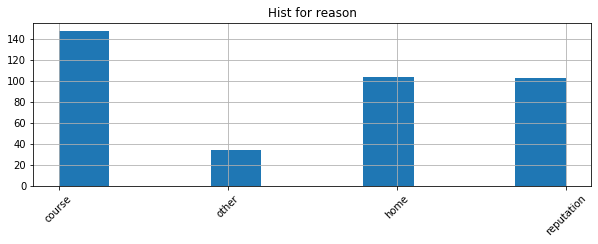


В колонке studytime 2% NaN, автоматически исправляем
NaN в "studytime" = 2% 
Исходное распределение


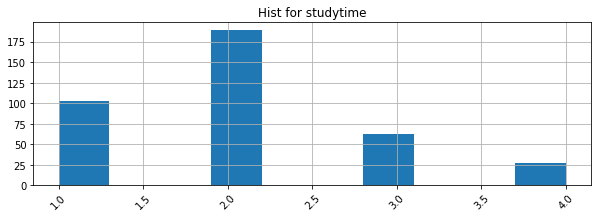

Предложенное АВТО распределение


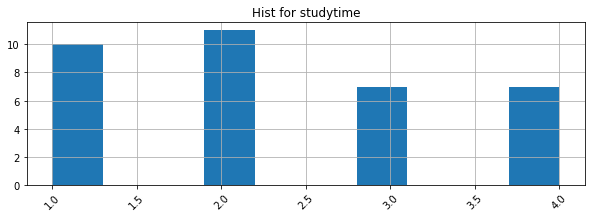

Выбранные колонки ['sex', 'famsize', 'paid', 'higher']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "studytime"  7 
filter = (sex == 0) & (famsize == 1.0) & (paid == 0.0) & (higher == 1.0); index = 17
Выбрано 4 строк; Случаев 26;  Значение для studytime=[2.]


studytime  sex  famsize  paid  higher  count
2         1.0    0      1.0   0.0     1.0     13
13        2.0    0      1.0   0.0     1.0     26
23        3.0    0      1.0   0.0     1.0     14
30        4.0    0      1.0   0.0     1.0      2

-------------------------------------------------------
filter = (sex == 0) & (famsize == 1.0) & (paid == 1.0) & (higher == 1.0); index = 91
Выбрано 4 строк; Случаев 29;  Значение для studytime=[2.]


studytime  sex  famsize  paid  higher  count
3         1.0    0      1.0   1.0     1.0      6
14        2.0    0      1.0   1.0     1.0     29
24        3.0    0      1.0   1.0     1.0     24
31        4.0    0      1.0   1.0     1.0      9

-------------------------------------------------------
filter = (sex == 0) & (famsize == 1.0) & (paid == 0.0) & (higher == 1.0); index = 112
Выбрано 4 строк; Случаев 27;  Значение для studytime=[2.]


studytime  sex  famsize  paid  higher  count
2         1.0    0      1.0   0.0     1.0     13
13        2.0    0      1.0   0.0     1.0     27
23        3.0    0      1.0   0.0     1.0     14
30        4.0    0      1.0   0.0     1.0      2

-------------------------------------------------------
filter = (sex == 1) & (famsize == nan) & (paid == 1.0) & (higher == 1.0); index = 129
filter = (sex == 1) & (famsize == 0.0) & (paid == 1.0) & (higher == nan); index = 227
filter = (sex == 1) & (famsize == 1.0) & (paid == 1.0) & (higher == 1.0); index = 266
Выбрано 4 строк; Случаев 20;  Значение для studytime=[2.]


studytime  sex  famsize  paid  higher  count
9         1.0    1      1.0   1.0     1.0      8
20        2.0    1      1.0   1.0     1.0     20
27        3.0    1      1.0   1.0     1.0      1
34        4.0    1      1.0   1.0     1.0      3

-------------------------------------------------------
filter = (sex == 0) & (famsize == 1.0) & (paid == 0.0) & (higher == 1.0); index = 314
Выбрано 4 строк; Случаев 28;  Значение для studytime=[2.]


studytime  sex  famsize  paid  higher  count
2         1.0    0      1.0   0.0     1.0     13
13        2.0    0      1.0   0.0     1.0     28
23        3.0    0      1.0   0.0     1.0     14
30        4.0    0      1.0   0.0     1.0      2

-------------------------------------------------------
НЕ Все NaN в "studytime" успешно заменены, осталось 2 из 389
Все NaN в "studytime" успешно заменены.
----------------------- Проверка распределения studytime после устранения NaN


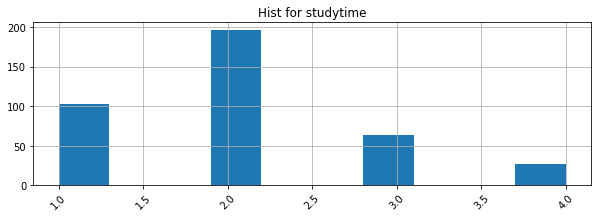


В колонке schoolsup 2% NaN, автоматически исправляем
NaN в "schoolsup" = 2% 
Исходное распределение


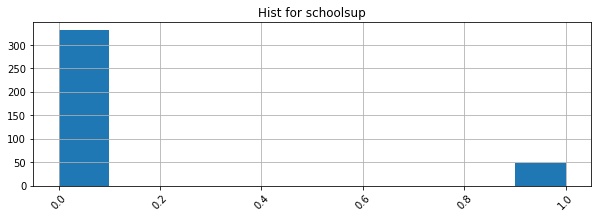

Предложенное АВТО распределение


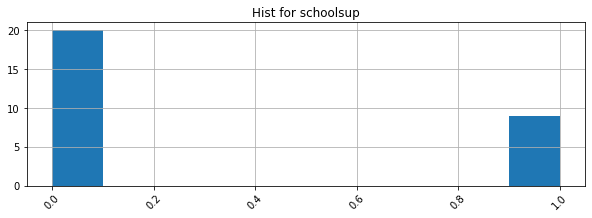

Выбранные колонки ['school', 'sex', 'age']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "schoolsup"  9 
filter = (school == 1) & (sex == 1) & (age == 15); index = 27
Выбрано 2 строк; Случаев 35;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
13        0.0       1    1   15     35
25        1.0       1    1   15      8

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 15); index = 35
Выбрано 2 строк; Случаев 22;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
8         0.0       1    0   15     22
20        1.0       1    0   15     15

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 16); index = 79
Выбрано 2 строк; Случаев 39;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
9         0.0       1    0   16     39
21        1.0       1    0   16     13

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 16); index = 151
Выбрано 2 строк; Случаев 45;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
14        0.0       1    1   16     45
26        1.0       1    1   16      4

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 17); index = 211
Выбрано 2 строк; Случаев 33;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
15        0.0       1    1   17     33
27        1.0       1    1   17      2

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 17); index = 274
Выбрано 2 строк; Случаев 45;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
10        0.0       1    0   17     45
22        1.0       1    0   17      3

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 17); index = 321
Выбрано 2 строк; Случаев 46;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
10        0.0       1    0   17     46
22        1.0       1    0   17      3

-------------------------------------------------------
filter = (school == 0) & (sex == 1) & (age == 21); index = 392
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для schoolsup=[0.]


Empty DataFrame
Columns: [schoolsup, school, sex, age, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (sex == 1) & (age == 19); index = 394
Выбрано 1 строк; Случаев 2;  Значение для schoolsup=[0.]


schoolsup  school  sex  age  count
6        0.0       0    1   19      2

-------------------------------------------------------
Все NaN в "schoolsup" успешно заменены.
----------------------- Проверка распределения schoolsup после устранения NaN


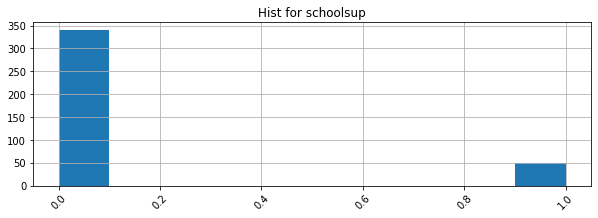


В колонке activities 4% NaN, автоматически исправляем
NaN в "activities" = 4% 
Исходное распределение


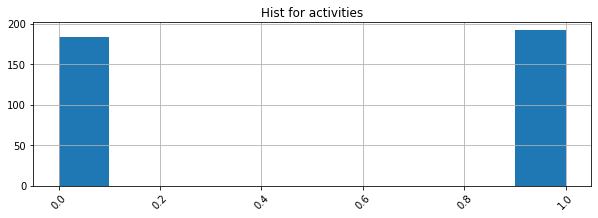

Предложенное АВТО распределение


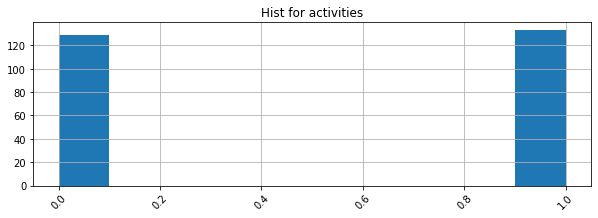

Выбранные колонки ['school', 'sex', 'age', 'Medu', 'Fedu', 'studytime']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "activities"  14 
filter = (school == 1) & (sex == 1) & (age == 15) & (Medu == 2.0) & (Fedu == 2.0) & (studytime == 1.0); index = 43
Выбрано 1 строк; Случаев 1;  Значение для activities=[0.]


activities  school  sex  age  Medu  Fedu  studytime  count
83         0.0       1    1   15   2.0   2.0        1.0      1

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 16) & (Medu == 2.0) & (Fedu == 2.0) & (studytime == 2.0); index = 44
Выбрано 2 строк; Случаев 4;  Значение для activities=[0.]


activities  school  sex  age  Medu  Fedu  studytime  count
37          0.0       1    0   16   2.0   2.0        2.0      4
161         1.0       1    0   16   2.0   2.0        2.0      3

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 15) & (Medu == 3.0) & (Fedu == 3.0) & (studytime == 1.0); index = 54
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для activities=[1.]


Empty DataFrame
Columns: [activities, school, sex, age, Medu, Fedu, studytime, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 15) & (Medu == 2.0) & (Fedu == 3.0) & (studytime == 3.0); index = 81
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для activities=[1.]


Empty DataFrame
Columns: [activities, school, sex, age, Medu, Fedu, studytime, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 16) & (Medu == 4.0) & (Fedu == 3.0) & (studytime == 3.0); index = 99
Выбрано 1 строк; Случаев 1;  Значение для activities=[1.]


activities  school  sex  age  Medu  Fedu  studytime  count
169         1.0       1    0   16   4.0   3.0        3.0      1

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 15) & (Medu == 4.0) & (Fedu == 4.0) & (studytime == 2.0); index = 116
Выбрано 2 строк; Случаев 1;  Значение для activities=[0. 1.]


activities  school  sex  age  Medu  Fedu  studytime  count
93          0.0       1    1   15   4.0   4.0        2.0      1
215         1.0       1    1   15   4.0   4.0        2.0      1

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 15) & (Medu == 3.0) & (Fedu == 4.0) & (studytime == 2.0); index = 126
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для activities=[1.]


Empty DataFrame
Columns: [activities, school, sex, age, Medu, Fedu, studytime, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 15) & (Medu == 4.0) & (Fedu == 3.0) & (studytime == 4.0); index = 140
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для activities=[1.]


Empty DataFrame
Columns: [activities, school, sex, age, Medu, Fedu, studytime, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 16) & (Medu == 2.0) & (Fedu == 2.0) & (studytime == 1.0); index = 141
Выбрано 1 строк; Случаев 1;  Значение для activities=[0.]


activities  school  sex  age  Medu  Fedu  studytime  count
97         0.0       1    1   16   2.0   2.0        1.0      1

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 17) & (Medu == 2.0) & (Fedu == 1.0) & (studytime == 1.0); index = 160
Выбрано 2 строк; Случаев 2;  Значение для activities=[0.]


activities  school  sex  age  Medu  Fedu  studytime  count
108         0.0       1    1   17   2.0   1.0        1.0      2
244         1.0       1    1   17   2.0   1.0        1.0      1

-------------------------------------------------------
filter = (school == 1) & (sex == 1) & (age == 17) & (Medu == 1.0) & (Fedu == 3.0) & (studytime == 1.0); index = 163
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для activities=[1.]


Empty DataFrame
Columns: [activities, school, sex, age, Medu, Fedu, studytime, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 16) & (Medu == 4.0) & (Fedu == 3.0) & (studytime == 2.0); index = 207
Выбрано 1 строк; Случаев 2;  Значение для activities=[1.]


activities  school  sex  age  Medu  Fedu  studytime  count
169         1.0       1    0   16   4.0   3.0        2.0      2

-------------------------------------------------------
filter = (school == 1) & (sex == 0) & (age == 16) & (Medu == 2.0) & (Fedu == 2.0) & (studytime == 2.0); index = 212
Выбрано 2 строк; Случаев 5;  Значение для activities=[0.]


activities  school  sex  age  Medu  Fedu  studytime  count
37          0.0       1    0   16   2.0   2.0        2.0      5
163         1.0       1    0   16   2.0   2.0        2.0      3

-------------------------------------------------------
filter = (school == 0) & (sex == 1) & (age == 18) & (Medu == 3.0) & (Fedu == 2.0) & (studytime == 1.0); index = 393
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для activities=[1.]


Empty DataFrame
Columns: [activities, school, sex, age, Medu, Fedu, studytime, count]
Index: []

-------------------------------------------------------
Все NaN в "activities" успешно заменены.
----------------------- Проверка распределения activities после устранения NaN


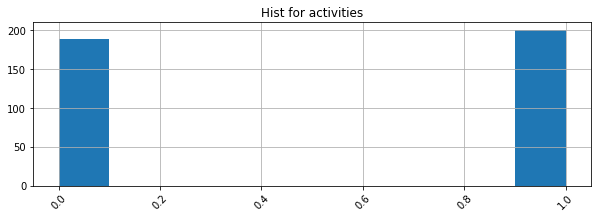


В колонке nursery 4% NaN, автоматически исправляем
NaN в "nursery" = 4% 
Исходное распределение


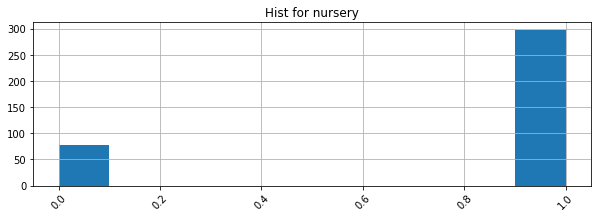

Предложенное АВТО распределение


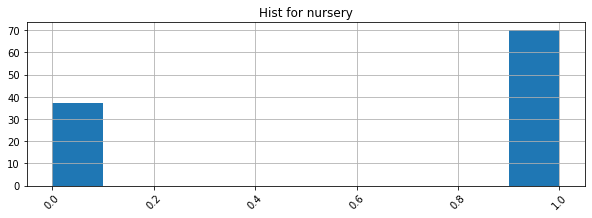

Выбранные колонки ['school', 'Medu', 'Fedu', 'failures', 'paid']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "nursery"  15 
filter = (school == 1) & (Medu == 4.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 0.0); index = 22
Выбрано 1 строк; Случаев 4;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
97      1.0       1   4.0   2.0       0.0   0.0      4

-------------------------------------------------------
filter = (school == 1) & (Medu == 4.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 0.0); index = 32
Выбрано 2 строк; Случаев 12;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
33       0.0       1   4.0   3.0       0.0   0.0      1
100      1.0       1   4.0   3.0       0.0   0.0     12

-------------------------------------------------------
filter = (school == 1) & (Medu == 4.0) & (Fedu == 4.0) & (failures == 2.0) & (paid == 1.0); index = 85
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для nursery=[1.]


Empty DataFrame
Columns: [nursery, school, Medu, Fedu, failures, paid, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (Medu == 2.0) & (Fedu == 2.0) & (failures == 1.0) & (paid == 1.0); index = 88
Выбрано 1 строк; Случаев 1;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
73      1.0       1   2.0   2.0       1.0   1.0      1

-------------------------------------------------------
filter = (school == 1) & (Medu == 3.0) & (Fedu == 3.0) & (failures == 2.0) & (paid == 1.0); index = 152
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для nursery=[1.]


Empty DataFrame
Columns: [nursery, school, Medu, Fedu, failures, paid, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (Medu == 2.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 1.0); index = 212
Выбрано 2 строк; Случаев 13;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
23      0.0       1   2.0   2.0       0.0   1.0      2
71      1.0       1   2.0   2.0       0.0   1.0     13

-------------------------------------------------------
filter = (school == 1) & (Medu == 0.0) & (Fedu == 2.0) & (failures == 0.0) & (paid == 1.0); index = 249
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для nursery=[1.]


Empty DataFrame
Columns: [nursery, school, Medu, Fedu, failures, paid, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (Medu == 4.0) & (Fedu == 4.0) & (failures == 0.0) & (paid == 0.0); index = 300
Выбрано 2 строк; Случаев 16;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
34       0.0       1   4.0   4.0       0.0   0.0      5
105      1.0       1   4.0   4.0       0.0   0.0     16

-------------------------------------------------------
filter = (school == 1) & (Medu == 3.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 0.0); index = 332
Выбрано 2 строк; Случаев 6;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
32      0.0       1   3.0   3.0       0.0   0.0      5
89      1.0       1   3.0   3.0       0.0   0.0      6

-------------------------------------------------------
filter = (school == 1) & (Medu == 3.0) & (Fedu == 1.0) & (failures == 1.0) & (paid == 1.0); index = 336
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для nursery=[1.]


Empty DataFrame
Columns: [nursery, school, Medu, Fedu, failures, paid, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (Medu == 2.0) & (Fedu == 1.0) & (failures == 1.0) & (paid == 1.0); index = 340
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для nursery=[1.]


Empty DataFrame
Columns: [nursery, school, Medu, Fedu, failures, paid, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (Medu == 4.0) & (Fedu == 4.0) & (failures == 1.0) & (paid == nan); index = 341
filter = (school == 0) & (Medu == 1.0) & (Fedu == 1.0) & (failures == 0.0) & (paid == 0.0); index = 359
Выбрано 2 строк; Случаев 2;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
0       0.0       0   1.0   1.0       0.0   0.0      1
37      1.0       0   1.0   1.0       0.0   0.0      2

-------------------------------------------------------
filter = (school == 0) & (Medu == 1.0) & (Fedu == 3.0) & (failures == 0.0) & (paid == 1.0); index = 365
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для nursery=[1.]


Empty DataFrame
Columns: [nursery, school, Medu, Fedu, failures, paid, count]
Index: []

-------------------------------------------------------
filter = (school == 0) & (Medu == 1.0) & (Fedu == 1.0) & (failures == 1.0) & (paid == 0.0); index = 383
Выбрано 2 строк; Случаев 2;  Значение для nursery=[1.]


nursery  school  Medu  Fedu  failures  paid  count
1       0.0       0   1.0   1.0       1.0   0.0      1
38      1.0       0   1.0   1.0       1.0   0.0      2

-------------------------------------------------------
НЕ Все NaN в "nursery" успешно заменены, осталось 1 из 389
Все NaN в "nursery" успешно заменены.
----------------------- Проверка распределения nursery после устранения NaN


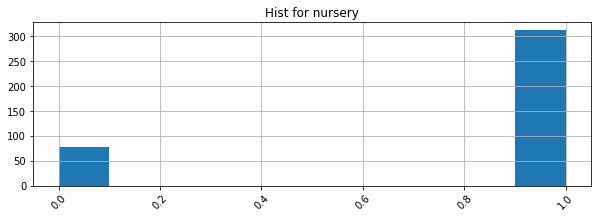


В колонке studytime, granular 2% NaN, автоматически исправляем
NaN в "studytime, granular" = 2% 
Исходное распределение


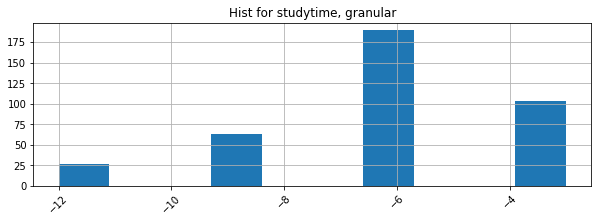

Предложенное АВТО распределение


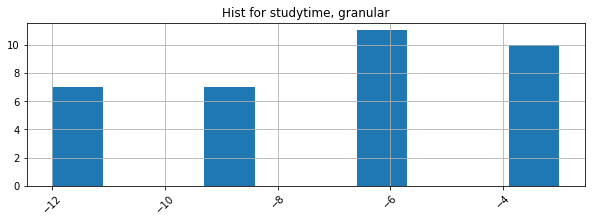

Выбранные колонки ['sex', 'famsize', 'studytime', 'paid', 'higher']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "studytime, granular"  7 
filter = (sex == 0) & (famsize == 1.0) & (studytime == 2.0) & (paid == 0.0) & (higher == 1.0); index = 17
Выбрано 1 строк; Случаев 26;  Значение для studytime, granular=[-6.]


studytime, granular  sex  famsize  studytime  paid  higher  count
17                 -6.0    0      1.0        2.0   0.0     1.0     26

-------------------------------------------------------
filter = (sex == 0) & (famsize == 1.0) & (studytime == 2.0) & (paid == 1.0) & (higher == 1.0); index = 91
Выбрано 1 строк; Случаев 29;  Значение для studytime, granular=[-6.]


studytime, granular  sex  famsize  studytime  paid  higher  count
18                 -6.0    0      1.0        2.0   1.0     1.0     29

-------------------------------------------------------
filter = (sex == 0) & (famsize == 1.0) & (studytime == 2.0) & (paid == 0.0) & (higher == 1.0); index = 112
Выбрано 1 строк; Случаев 27;  Значение для studytime, granular=[-6.]


studytime, granular  sex  famsize  studytime  paid  higher  count
17                 -6.0    0      1.0        2.0   0.0     1.0     27

-------------------------------------------------------
filter = (sex == 1) & (famsize == nan) & (studytime == 2.0) & (paid == 1.0) & (higher == 1.0); index = 129
filter = (sex == 1) & (famsize == 0.0) & (studytime == 2.0) & (paid == 1.0) & (higher == nan); index = 227
filter = (sex == 1) & (famsize == 1.0) & (studytime == 2.0) & (paid == 1.0) & (higher == 1.0); index = 266
Выбрано 1 строк; Случаев 20;  Значение для studytime, granular=[-6.]


studytime, granular  sex  famsize  studytime  paid  higher  count
24                 -6.0    1      1.0        2.0   1.0     1.0     20

-------------------------------------------------------
filter = (sex == 0) & (famsize == 1.0) & (studytime == 2.0) & (paid == 0.0) & (higher == 1.0); index = 314
Выбрано 1 строк; Случаев 28;  Значение для studytime, granular=[-6.]


studytime, granular  sex  famsize  studytime  paid  higher  count
17                 -6.0    0      1.0        2.0   0.0     1.0     28

-------------------------------------------------------
НЕ Все NaN в "studytime, granular" успешно заменены, осталось 2 из 389
Все NaN в "studytime, granular" успешно заменены.
----------------------- Проверка распределения studytime, granular после устранения NaN


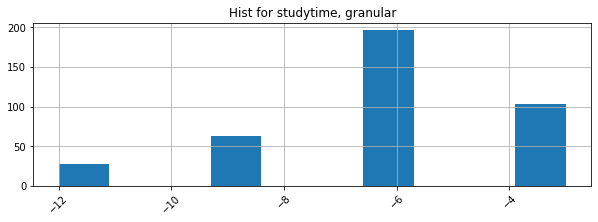


В колонке higher 5% NaN, автоматически исправляем
NaN в "higher" = 5% 
Исходное распределение


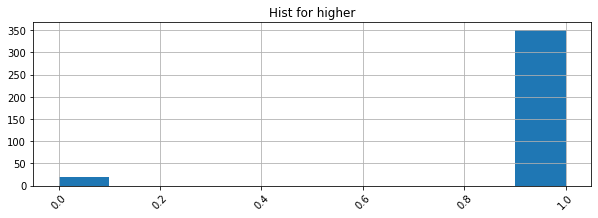

Предложенное АВТО распределение


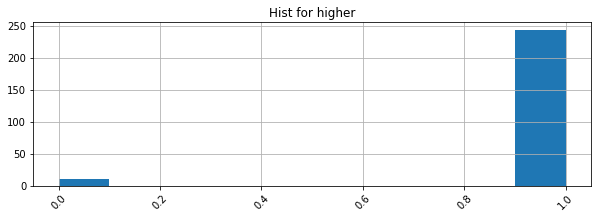

Выбранные колонки ['sex', 'age', 'Medu', 'Fedu', 'studytime', 'failures', 'famsup', 'paid', 'romantic', 'score']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "higher"  20 
filter = (sex == 1) & (age == 16) & (Medu == 3.0) & (Fedu == 2.0) & (studytime == 1.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (romantic == 0.0) & (score == 75.0); index = 34
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (Medu == 4.0) & (Fedu == 2.0) & (studytime == 2.0) & (failures == nan) & (famsup == 1.0) & (paid == 1.0) & (romantic == 0.0) & (score == 70.0); index = 48
filter = (sex == 1) & (age == 15) & (Medu == 4.0) & (Fedu == 0.0) & (studytime == 4.0) & (failures == 0.0) & (famsup == 0.0) & (paid == 0.0) & (romantic == 0.0) & (score == 50.0); index = 76
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (age == 15) & (Medu == 1.0) & (Fedu == 1.0) & (studytime == 2.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 0.0) & (romantic == 0.0) & (score == 50.0); index = 84
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 16) & (Medu == 4.0) & (Fedu == 3.0) & (studytime == 1.0) & (failures == 0.0) & (famsup == 1.0) & (paid == nan) & (romantic == 0.0) & (score == 75.0); index = 96
filter = (sex == 0) & (age == 15) & (Medu == 4.0) & (Fedu == nan) & (studytime == 3.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (romantic == 0.0) & (score == 55.0); index = 142
filter = (sex == 1) & (age == 15) & (Medu == 2.0) & (Fedu == 1.0) & (studytime == 1.0) & (failures == 3.0) & (famsup == nan) & (paid == 0.0) & (romantic == 0.0) & (score == 50.0); index = 149
filter = (sex == 1) & (age == 16) & (Medu == 2.0) & (Fedu == 2.0) & (studytime == 1.0) & (failures == nan) & (famsup == 0.0) & (paid == 0.0) & (romantic == 0.0) & (score == 75.0); index = 158
filter = (sex == 1) & (age == 16) & (Medu == 3.0) & (Fedu == 4.0) & (studytime == 1.0) & (failures == nan) & (famsup == 1.0) & (paid == 0.0) & (romantic == 0.0) & (score == 0.0)

Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 18) & (Medu == 3.0) & (Fedu == 2.0) & (studytime == 1.0) & (failures == 1.0) & (famsup == 0.0) & (paid == 0.0) & (romantic == 0.0) & (score == 40.0); index = 250
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 17) & (Medu == 3.0) & (Fedu == nan) & (studytime == 1.0) & (failures == 1.0) & (famsup == 0.0) & (paid == 0.0) & (romantic == 0.0) & (score == 50.0); index = 281
filter = (sex == 0) & (age == 17) & (Medu == 4.0) & (Fedu == 3.0) & (studytime == 2.0) & (failures == nan) & (famsup == 1.0) & (paid == 1.0) & (romantic == 1.0) & (score == 65.0); index = 320
filter = (sex == 0) & (age == 17) & (Medu == 2.0) & (Fedu == 4.0) & (studytime == 3.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 0.0) & (romantic == 1.0) & (score == 70.0); index = 331
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 18) & (Medu == 4.0) & (Fedu == 3.0) & (studytime == 3.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (romantic == 1.0) & (score == 45.0); index = 347
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (age == 18) & (Medu == 3.0) & (Fedu == 3.0) & (studytime == 2.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 0.0) & (romantic == 1.0) & (score == 50.0); index = 362
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 17) & (Medu == 2.0) & (Fedu == 3.0) & (studytime == 2.0) & (failures == 0.0) & (famsup == 0.0) & (paid == 0.0) & (romantic == 0.0) & (score == 50.0); index = 382
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 21) & (Medu == 1.0) & (Fedu == 1.0) & (studytime == 1.0) & (failures == 3.0) & (famsup == 0.0) & (paid == 0.0) & (romantic == 0.0) & (score == 35.0); index = 392
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для higher=[1.]


Empty DataFrame
Columns: [higher, sex, age, Medu, Fedu, studytime, failures, famsup, paid, romantic, score, count]
Index: []

-------------------------------------------------------
НЕ Все NaN в "higher" успешно заменены, осталось 10 из 389
Все NaN в "higher" успешно заменены.
----------------------- Проверка распределения higher после устранения NaN


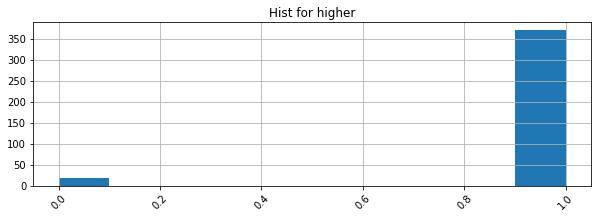


В колонке freetime 2% NaN, автоматически исправляем
NaN в "freetime" = 2% 
Исходное распределение


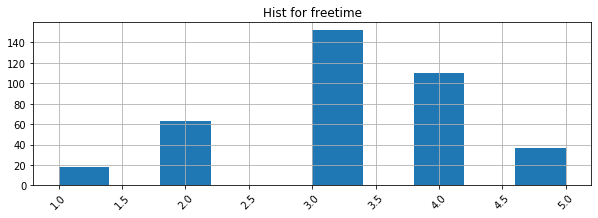

Предложенное АВТО распределение


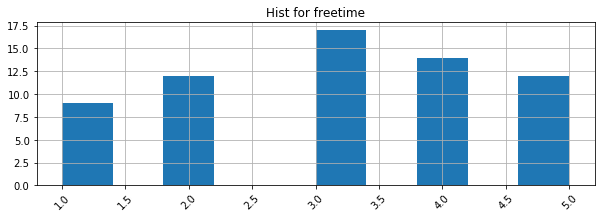

Выбранные колонки ['sex', 'schoolsup', 'goout']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "freetime"  9 
filter = (sex == 1) & (schoolsup == 0.0) & (goout == 2.0); index = 32
Выбрано 4 строк; Случаев 15;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
16       2.0    1        0.0    2.0      8
32       3.0    1        0.0    2.0     15
46       4.0    1        0.0    2.0     11
58       5.0    1        0.0    2.0      5

-------------------------------------------------------
filter = (sex == 0) & (schoolsup == 1.0) & (goout == 3.0); index = 74
Выбрано 3 строк; Случаев 3;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
5        1.0    0        1.0    3.0      1
28       3.0    0        1.0    3.0      3
43       4.0    0        1.0    3.0      2

-------------------------------------------------------
filter = (sex == 0) & (schoolsup == 0.0) & (goout == 3.0); index = 131
Выбрано 4 строк; Случаев 32;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
2        1.0    0        0.0    3.0      1
11       2.0    0        0.0    3.0     11
23       3.0    0        0.0    3.0     32
40       4.0    0        0.0    3.0     15

-------------------------------------------------------
filter = (sex == 1) & (schoolsup == 0.0) & (goout == 4.0); index = 280
Выбрано 4 строк; Случаев 17;  Значение для freetime=[4.]


freetime  sex  schoolsup  goout  count
18       2.0    1        0.0    4.0      8
34       3.0    1        0.0    4.0      6
48       4.0    1        0.0    4.0     17
60       5.0    1        0.0    4.0      5

-------------------------------------------------------
filter = (sex == 1) & (schoolsup == 0.0) & (goout == 2.0); index = 290
Выбрано 4 строк; Случаев 16;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
16       2.0    1        0.0    2.0      8
32       3.0    1        0.0    2.0     16
46       4.0    1        0.0    2.0     11
58       5.0    1        0.0    2.0      5

-------------------------------------------------------
filter = (sex == 0) & (schoolsup == 0.0) & (goout == 2.0); index = 291
Выбрано 5 строк; Случаев 16;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
1        1.0    0        0.0    2.0      3
10       2.0    0        0.0    2.0     15
22       3.0    0        0.0    2.0     16
39       4.0    0        0.0    2.0      7
53       5.0    0        0.0    2.0      2

-------------------------------------------------------
filter = (sex == 0) & (schoolsup == 0.0) & (goout == 1.0); index = 311
Выбрано 5 строк; Случаев 4;  Значение для freetime=[2.]


freetime  sex  schoolsup  goout  count
0        1.0    0        0.0    1.0      3
9        2.0    0        0.0    1.0      4
21       3.0    0        0.0    1.0      1
38       4.0    0        0.0    1.0      1
52       5.0    0        0.0    1.0      1

-------------------------------------------------------
filter = (sex == 0) & (schoolsup == 0.0) & (goout == 2.0); index = 314
Выбрано 5 строк; Случаев 17;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
1        1.0    0        0.0    2.0      3
10       2.0    0        0.0    2.0     15
22       3.0    0        0.0    2.0     17
39       4.0    0        0.0    2.0      7
53       5.0    0        0.0    2.0      2

-------------------------------------------------------
filter = (sex == 0) & (schoolsup == 0.0) & (goout == 3.0); index = 338
Выбрано 4 строк; Случаев 33;  Значение для freetime=[3.]


freetime  sex  schoolsup  goout  count
2        1.0    0        0.0    3.0      1
11       2.0    0        0.0    3.0     11
23       3.0    0        0.0    3.0     33
40       4.0    0        0.0    3.0     15

-------------------------------------------------------
Все NaN в "freetime" успешно заменены.
----------------------- Проверка распределения freetime после устранения NaN


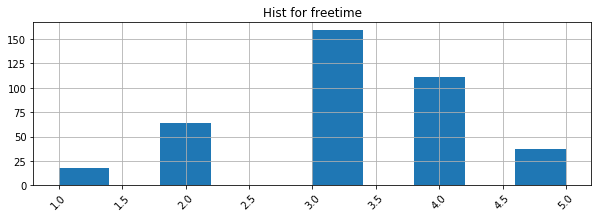


В колонке goout 2% NaN, автоматически исправляем
NaN в "goout" = 2% 
Исходное распределение


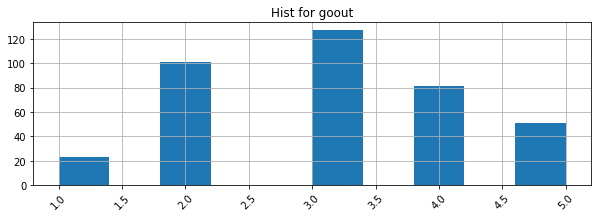

Предложенное АВТО распределение


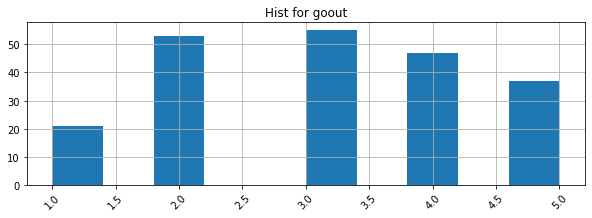

Выбранные колонки ['failures', 'freetime', 'score']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "goout"  6 
filter = (failures == 0.0) & (freetime == 1.0) & (score == 35.0); index = 89
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для goout=[3.]


Empty DataFrame
Columns: [goout, failures, freetime, score, count]
Index: []

-------------------------------------------------------
filter = (failures == 0.0) & (freetime == 3.0) & (score == 30.0); index = 92
Выбрано 4 строк; Случаев 3;  Значение для goout=[4.]


goout  failures  freetime  score  count
34     2.0       0.0       3.0   30.0      1
86     3.0       0.0       3.0   30.0      2
137    4.0       0.0       3.0   30.0      3
181    5.0       0.0       3.0   30.0      1

-------------------------------------------------------
filter = (failures == 0.0) & (freetime == 3.0) & (score == 80.0); index = 200
Выбрано 2 строк; Случаев 3;  Значение для goout=[2.]


goout  failures  freetime  score  count
43     2.0       0.0       3.0   80.0      3
186    5.0       0.0       3.0   80.0      1

-------------------------------------------------------
filter = (failures == 0.0) & (freetime == 4.0) & (score == 50.0); index = 202
Выбрано 4 строк; Случаев 3;  Значение для goout=[3. 4.]


goout  failures  freetime  score  count
10     1.0       0.0       4.0   50.0      1
103    3.0       0.0       4.0   50.0      3
149    4.0       0.0       4.0   50.0      3
190    5.0       0.0       4.0   50.0      2

-------------------------------------------------------
filter = (failures == 1.0) & (freetime == 3.0) & (score == 0.0); index = 221
Выбрано 3 строк; Случаев 1;  Значение для goout=[1. 2. 3.]


goout  failures  freetime  score  count
18     1.0       1.0       3.0    0.0      1
62     2.0       1.0       3.0    0.0      1
113    3.0       1.0       3.0    0.0      1

-------------------------------------------------------
filter = (failures == 0.0) & (freetime == 3.0) & (score == 55.0); index = 322
Выбрано 5 строк; Случаев 6;  Значение для goout=[3.]


goout  failures  freetime  score  count
6      1.0       0.0       3.0   55.0      1
38     2.0       0.0       3.0   55.0      5
90     3.0       0.0       3.0   55.0      6
141    4.0       0.0       3.0   55.0      3
184    5.0       0.0       3.0   55.0      1

-------------------------------------------------------
Все NaN в "goout" успешно заменены.
----------------------- Проверка распределения goout после устранения NaN


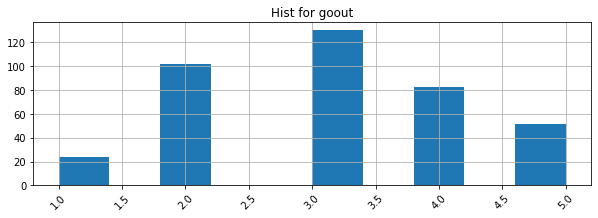


В колонке health 4% NaN, автоматически исправляем
NaN в "health" = 4% 
Выбранные колонки ['goout']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "health"  15 
filter = (goout == 2.0); index = 30
Выбрано 5 строк; Случаев 44;  Значение для health=[5.]


health  goout  count
1      1.0    2.0     10
6      2.0    2.0      8
11     3.0    2.0     27
16     4.0    2.0      8
21     5.0    2.0     44

-------------------------------------------------------
filter = (goout == 4.0); index = 55
Выбрано 5 строк; Случаев 27;  Значение для health=[5.]


health  goout  count
3      1.0    4.0     13
8      2.0    4.0      9
13     3.0    4.0     13
18     4.0    4.0     17
23     5.0    4.0     27

-------------------------------------------------------
filter = (goout == 2.0); index = 88
Выбрано 5 строк; Случаев 45;  Значение для health=[5.]


health  goout  count
1      1.0    2.0     10
6      2.0    2.0      8
11     3.0    2.0     27
16     4.0    2.0      8
21     5.0    2.0     45

-------------------------------------------------------
filter = (goout == 2.0); index = 145
Выбрано 5 строк; Случаев 46;  Значение для health=[5.]


health  goout  count
1      1.0    2.0     10
6      2.0    2.0      8
11     3.0    2.0     27
16     4.0    2.0      8
21     5.0    2.0     46

-------------------------------------------------------
filter = (goout == 4.0); index = 153
Выбрано 5 строк; Случаев 28;  Значение для health=[5.]


health  goout  count
3      1.0    4.0     13
8      2.0    4.0      9
13     3.0    4.0     13
18     4.0    4.0     17
23     5.0    4.0     28

-------------------------------------------------------
filter = (goout == 5.0); index = 164
Выбрано 5 строк; Случаев 20;  Значение для health=[5.]


health  goout  count
4      1.0    5.0      6
9      2.0    5.0      7
14     3.0    5.0      6
19     4.0    5.0      9
24     5.0    5.0     20

-------------------------------------------------------
filter = (goout == 3.0); index = 189
Выбрано 5 строк; Случаев 37;  Значение для health=[3.]


health  goout  count
2      1.0    3.0     14
7      2.0    3.0     16
12     3.0    3.0     37
17     4.0    3.0     24
22     5.0    3.0     36

-------------------------------------------------------
filter = (goout == 2.0); index = 208
Выбрано 5 строк; Случаев 47;  Значение для health=[5.]


health  goout  count
1      1.0    2.0     10
6      2.0    2.0      8
11     3.0    2.0     27
16     4.0    2.0      8
21     5.0    2.0     47

-------------------------------------------------------
filter = (goout == 5.0); index = 220
Выбрано 5 строк; Случаев 21;  Значение для health=[5.]


health  goout  count
4      1.0    5.0      6
9      2.0    5.0      7
14     3.0    5.0      6
19     4.0    5.0      9
24     5.0    5.0     21

-------------------------------------------------------
filter = (goout == 2.0); index = 236
Выбрано 5 строк; Случаев 48;  Значение для health=[5.]


health  goout  count
1      1.0    2.0     10
6      2.0    2.0      8
11     3.0    2.0     27
16     4.0    2.0      8
21     5.0    2.0     48

-------------------------------------------------------
filter = (goout == 3.0); index = 256
Выбрано 5 строк; Случаев 38;  Значение для health=[3.]


health  goout  count
2      1.0    3.0     14
7      2.0    3.0     16
12     3.0    3.0     38
17     4.0    3.0     24
22     5.0    3.0     36

-------------------------------------------------------
filter = (goout == 1.0); index = 259
Выбрано 5 строк; Случаев 10;  Значение для health=[5.]


health  goout  count
0      1.0    1.0      4
5      2.0    1.0      2
10     3.0    1.0      5
15     4.0    1.0      2
20     5.0    1.0     10

-------------------------------------------------------
filter = (goout == 4.0); index = 266
Выбрано 5 строк; Случаев 29;  Значение для health=[5.]


health  goout  count
3      1.0    4.0     13
8      2.0    4.0      9
13     3.0    4.0     13
18     4.0    4.0     17
23     5.0    4.0     29

-------------------------------------------------------
filter = (goout == 5.0); index = 330
Выбрано 5 строк; Случаев 22;  Значение для health=[5.]


health  goout  count
4      1.0    5.0      6
9      2.0    5.0      7
14     3.0    5.0      6
19     4.0    5.0      9
24     5.0    5.0     22

-------------------------------------------------------
filter = (goout == 3.0); index = 342
Выбрано 5 строк; Случаев 39;  Значение для health=[3.]


health  goout  count
2      1.0    3.0     14
7      2.0    3.0     16
12     3.0    3.0     39
17     4.0    3.0     24
22     5.0    3.0     36

-------------------------------------------------------
Все NaN в "health" успешно заменены.
----------------------- Проверка распределения health после устранения NaN


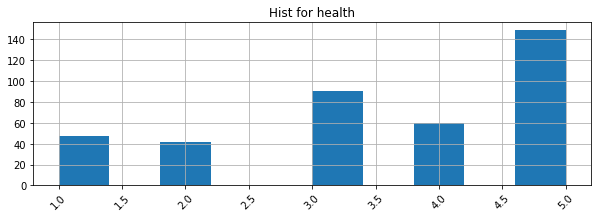


В колонке absences 3% NaN, автоматически исправляем
NaN в "absences" = 3% 
Исходное распределение


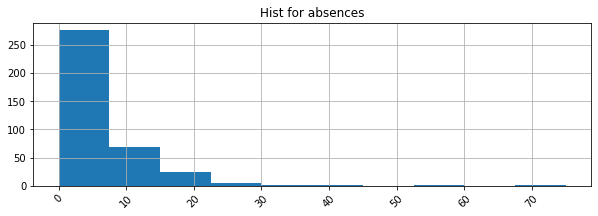

Предложенное АВТО распределение


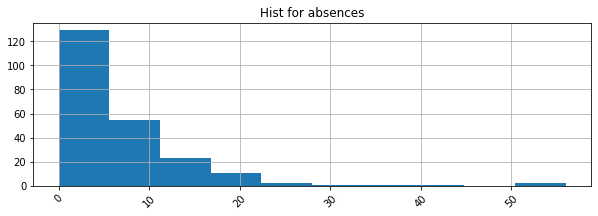

Выбранные колонки ['school', 'famsize', 'failures', 'famsup', 'paid', 'activities', 'freetime']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']
NaN в "absences"  11 
filter = (school == 1) & (famsize == 1.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (activities == 1.0) & (freetime == 3.0); index = 24
Выбрано 9 строк; Случаев 6;  Значение для absences=[0.]


absences  school  famsize  failures  famsup  paid  activities  freetime  \
45        0.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
84        2.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
120       4.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
143       6.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
167       8.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
171       9.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
181      10.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
183      11.0       1      1.0       0.0     1.0   1.0         1.0       3.0   
223      54.0       1      1.0       0.0     1.0   1.0         1.0       3.0   

     count  
45       6  
84       1  
120      1  
143      1  
167      1  
171      1  
181      1  
183      1  
223      1

-------------------------------------------------------
filter = (school == 1) & (famsize == 1.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 0.0) & (activities == 1.0) & (freetime == 4.0); index = 101
Выбрано 4 строк; Случаев 1;  Значение для absences=[ 0.  6.  7. 18.]


absences  school  famsize  failures  famsup  paid  activities  freetime  \
39        0.0       1      1.0       0.0     1.0   0.0         1.0       4.0   
140       6.0       1      1.0       0.0     1.0   0.0         1.0       4.0   
154       7.0       1      1.0       0.0     1.0   0.0         1.0       4.0   
210      18.0       1      1.0       0.0     1.0   0.0         1.0       4.0   

     count  
39       1  
140      1  
154      1  
210      1

-------------------------------------------------------
filter = (school == 1) & (famsize == 1.0) & (failures == 0.0) & (famsup == 0.0) & (paid == 0.0) & (activities == 0.0) & (freetime == 2.0); index = 120
Выбрано 2 строк; Случаев 1;  Значение для absences=[ 4. 16.]


absences  school  famsize  failures  famsup  paid  activities  freetime  \
109       4.0       1      1.0       0.0     0.0   0.0         0.0       2.0   
202      16.0       1      1.0       0.0     0.0   0.0         0.0       2.0   

     count  
109      1  
202      1

-------------------------------------------------------
filter = (school == 1) & (famsize == nan) & (failures == 0.0) & (famsup == 0.0) & (paid == 1.0) & (activities == 1.0) & (freetime == 5.0); index = 129
filter = (school == 1) & (famsize == 0.0) & (failures == 3.0) & (famsup == 0.0) & (paid == 0.0) & (activities == 0.0) & (freetime == 3.0); index = 150
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для absences=[0.]


Empty DataFrame
Columns: [absences, school, famsize, failures, famsup, paid, activities, freetime, count]
Index: []

-------------------------------------------------------
filter = (school == 1) & (famsize == nan) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (activities == 1.0) & (freetime == 4.0); index = 172
filter = (school == 1) & (famsize == 0.0) & (failures == 0.0) & (famsup == 0.0) & (paid == nan) & (activities == 0.0) & (freetime == 4.0); index = 215
filter = (school == 1) & (famsize == 0.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (activities == 0.0) & (freetime == 3.0); index = 227
Выбрано 2 строк; Случаев 2;  Значение для absences=[2.]


absences  school  famsize  failures  famsup  paid  activities  freetime  \
70        2.0       1      0.0       0.0     1.0   1.0         0.0       3.0   
191      13.0       1      0.0       0.0     1.0   1.0         0.0       3.0   

     count  
70       2  
191      1

-------------------------------------------------------
filter = (school == 1) & (famsize == nan) & (failures == 0.0) & (famsup == 0.0) & (paid == 0.0) & (activities == 0.0) & (freetime == 4.0); index = 254
filter = (school == 1) & (famsize == 0.0) & (failures == 0.0) & (famsup == 1.0) & (paid == 1.0) & (activities == 1.0) & (freetime == 2.0); index = 265
Выбрано 3 строк; Случаев 1;  Значение для absences=[1. 2. 8.]


absences  school  famsize  failures  famsup  paid  activities  freetime  \
57        1.0       1      0.0       0.0     1.0   1.0         1.0       2.0   
71        2.0       1      0.0       0.0     1.0   1.0         1.0       2.0   
159       8.0       1      0.0       0.0     1.0   1.0         1.0       2.0   

     count  
57       1  
71       1  
159      1

-------------------------------------------------------
filter = (school == 0) & (famsize == 0.0) & (failures == 1.0) & (famsup == 0.0) & (paid == 0.0) & (activities == 0.0) & (freetime == 3.0); index = 352
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для absences=[0.]


Empty DataFrame
Columns: [absences, school, famsize, failures, famsup, paid, activities, freetime, count]
Index: []

-------------------------------------------------------
НЕ Все NaN в "absences" успешно заменены, осталось 4 из 389
Все NaN в "absences" успешно заменены.
----------------------- Проверка распределения absences после устранения NaN


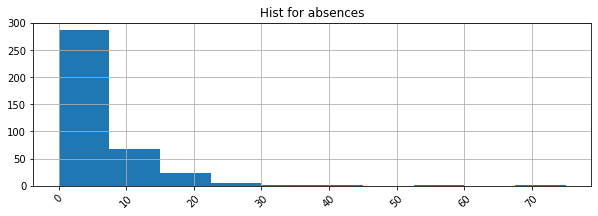

In [399]:
autho_correct_NaN()

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 31 columns):
school                 389 non-null int64
sex                    389 non-null int64
age                    389 non-null int64
address                389 non-null float64
famsize                362 non-null float64
Pstatus                344 non-null float64
Medu                   389 non-null float64
Fedu                   365 non-null float64
Mjob                   389 non-null object
Fjob                   354 non-null object
reason                 389 non-null object
guardian               358 non-null object
traveltime             363 non-null float64
studytime              389 non-null float64
failures               367 non-null float64
schoolsup              389 non-null float64
famsup                 352 non-null float64
paid                   350 non-null float64
activities             389 non-null float64
nursery                389 non-null float64
studytime, granular    38

--------------------------------------------
--------------------------------------------
# Устраняем (автоматически) NaN при количестве пропусков более 5%

1. С посмощью модифицтрованной функции get_FeaturesAuto(targetFeature) (ttest_ind) автоматически выбираем столбцы, наиболее влияющие на желаемый столбец.  
2. Выбраем НЕ более 4-5 (иначе не найдем похожих) столбцов максимально с сохранением распределения
2. Применяем выбранные столбцы для поиска строк "близнецов" для каждой строки с NaN, если такие находятся, то берется самое частотное значение, иначе самое частотное значение по всему датасету.

------------------------------------------------------------------
#  Устраняем NaN в famsize

In [401]:
targetFeature = 'famsize'
ok_list, test_list = get_FeaturesAuto(targetFeature)

NaN в "famsize" = 7% 
Выбранные колонки ['famsup']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


NaN в "famsize"  27 
filter = (Pstatus == 0.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "at_home") & (Fjob == "teacher") & (guardian == "mother"); index = 0
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == nan) & (famrel == 5.0) & (nursery == 1.0) & (Medu == 3.0) & (Fedu == 4.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 9
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 3.0) & (Mjob == "teacher") & (Fjob == "at_home") & (guardian == "mother"); index = 32
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 5.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 3.0) & (Mjob == "teacher") & (Fjob == "services") & (guardian == "mother"); index = 36
Выбрано 2 строк; Случаев 1;  Значение для famsize=[0. 1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu     Mjob      Fjob  \
61       0.0      1.0     5.0      1.0   4.0   3.0  teacher  services   
204      1.0      1.0     5.0      1.0   4.0   3.0  teacher  services   

    guardian  count  
61    mother      1  
204   mother      1

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 3.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 0.0) & (Mjob == "teacher") & (Fjob == "other") & (guardian == "mother"); index = 76
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 78
Выбрано 2 строк; Случаев 2;  Значение для famsize=[1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu   Mjob   Fjob guardian  \
35       0.0      1.0     4.0      1.0   2.0   1.0  other  other   mother   
133      1.0      1.0     4.0      1.0   2.0   1.0  other  other   mother   

     count  
35       1  
133      2

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 2.0) & (nursery == 1.0) & (Medu == 3.0) & (Fedu == 4.0) & (Mjob == "at_home") & (Fjob == "other") & (guardian == "mother"); index = 79
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 5.0) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "health") & (Fjob == "services") & (guardian == "mother"); index = 114
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 3.0) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == 2.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 128
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 3.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (Fjob == "teacher") & (guardian == "mother"); index = 129
Выбрано 1 строк; Случаев 1;  Значение для famsize=[1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu     Mjob     Fjob guardian  \
115      1.0      1.0     3.0      1.0   4.0   4.0  teacher  teacher   mother   

     count  
115      1

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 2.0) & (Mjob == "health") & (Fjob == "services") & (guardian == "father"); index = 167
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (Fjob == "other") & (guardian == "mother"); index = 172
Выбрано 1 строк; Случаев 2;  Значение для famsize=[1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu     Mjob   Fjob guardian  \
180      1.0      1.0     4.0      1.0   4.0   4.0  teacher  other   mother   

     count  
180      2

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == nan) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == nan) & (Mjob == "services") & (Fjob == "services") & (guardian == "father"); index = 195
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 0.0) & (Medu == 1.0) & (Fedu == 1.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 202
Выбрано 1 строк; Случаев 1;  Значение для famsize=[0.]


famsize  Pstatus  famrel  nursery  Medu  Fedu   Mjob   Fjob guardian  \
26      0.0      1.0     4.0      0.0   1.0   1.0  other  other   mother   

    count  
26      1

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 1.0) & (Fedu == 1.0) & (Mjob == "at_home") & (Fjob == "other") & (guardian == "mother"); index = 221
Выбрано 2 строк; Случаев 1;  Значение для famsize=[0. 1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu     Mjob   Fjob guardian  \
29       0.0      1.0     4.0      1.0   1.0   1.0  at_home  other   mother   
129      1.0      1.0     4.0      1.0   1.0   1.0  at_home  other   mother   

     count  
29       1  
129      1

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "at_home") & (Fjob == "other") & (guardian == "mother"); index = 228
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 5.0) & (nursery == 1.0) & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "at_home") & (Fjob == "other") & (guardian == nan); index = 235
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 237
Выбрано 2 строк; Случаев 3;  Значение для famsize=[1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu   Mjob   Fjob guardian  \
35       0.0      1.0     4.0      1.0   2.0   1.0  other  other   mother   
136      1.0      1.0     4.0      1.0   2.0   1.0  other  other   mother   

     count  
35       1  
136      3

-------------------------------------------------------
filter = (Pstatus == nan) & (famrel == 3.0) & (nursery == 0.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "services") & (Fjob == "services") & (guardian == "mother"); index = 252
filter = (Pstatus == 1.0) & (famrel == 3.0) & (nursery == 0.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 253
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsize=[1.]


Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 0.0) & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "mother"); index = 254
Выбрано 1 строк; Случаев 1;  Значение для famsize=[1.]


famsize  Pstatus  famrel  nursery  Medu  Fedu   Mjob   Fjob guardian  \
120      1.0      1.0     4.0      0.0   2.0   1.0  other  other   mother   

     count  
120      1

-------------------------------------------------------
filter = (Pstatus == nan) & (famrel == 5.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == 2.0) & (Mjob == "other") & (Fjob == "other") & (guardian == "father"); index = 268
filter = (Pstatus == 0.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 4.0) & (Fedu == nan) & (Mjob == "services") & (Fjob == "other") & (guardian == "mother"); index = 280
filter = (Pstatus == nan) & (famrel == 4.0) & (nursery == 0.0) & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "services") & (Fjob == "other") & (guardian == "other"); index = 313
filter = (Pstatus == 1.0) & (famrel == 4.0) & (nursery == 1.0) & (Medu == 2.0) & (Fedu == 3.0) & (Mjob == "at_home") & (Fjob == "other") & (guardian == nan); index = 344
filter = (Pstatus == 0.0) & (famrel == nan) & (nursery == 1.0) & (Medu == 1.0) & (Fedu == 4.0) & (Mjob == "at_home") & (Fjob == "other") & (guardian == "mother"); index = 360
filter = (Pstatus == 1.0) & (famrel == 5.0) & (nursery == 1.0) & (Medu == 1

Empty DataFrame
Columns: [famsize, Pstatus, famrel, nursery, Medu, Fedu, Mjob, Fjob, guardian, count]
Index: []

-------------------------------------------------------
НЕ Все NaN в "famsize" успешно заменены, осталось 9 из 389
Все NaN в "famsize" успешно заменены.
----------------------- Проверка распределения famsize после устранения NaN


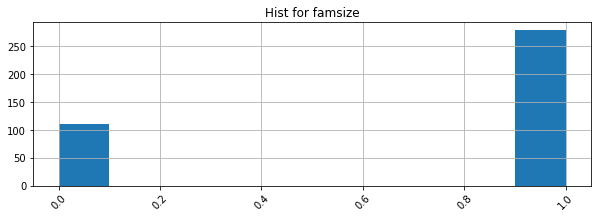

In [402]:
updateFeatureAuto(targetFeature, ['Pstatus', 'famrel','nursery', 'Medu','Fedu','Mjob', 'Fjob','guardian'])

------------------------------------------------------------------
#  Устраняем NaN в romantic

NaN в "romantic" = 8% 
Исходное распределение


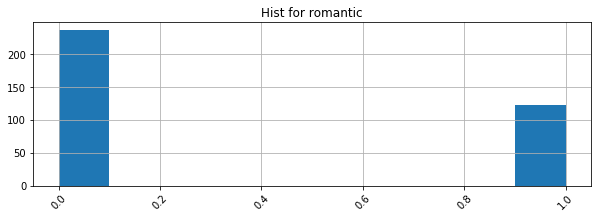

Предложенное АВТО распределение


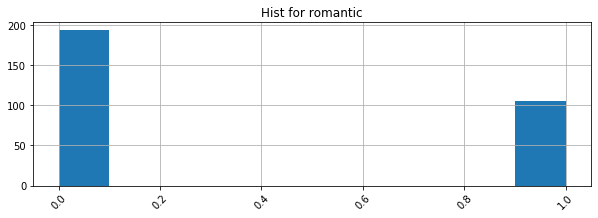

Выбранные колонки ['sex', 'age', 'failures', 'higher', 'absences', 'score']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [403]:
targetFeature = 'romantic'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


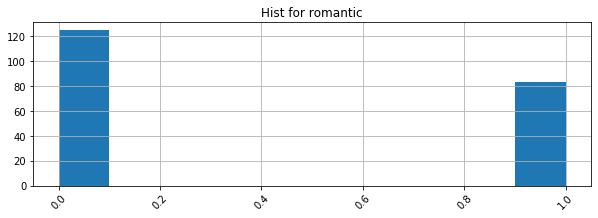

In [404]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['sex', 'age', 'internet', 'score'])

NaN в "romantic"  30 
filter = (sex == 0) & (age == 15) & (internet == 1.0) & (score == 50.0); index = 2
Выбрано 2 строк; Случаев 2;  Значение для romantic=[0. 1.]


romantic  sex  age  internet  score  count
8         0.0    0   15       1.0   50.0      2
129       1.0    0   15       1.0   50.0      2

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (internet == 1.0) & (score == 55.0); index = 13
Выбрано 1 строк; Случаев 2;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
70       0.0    1   15       1.0   55.0      2

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (internet == 1.0) & (score == 55.0); index = 26
Выбрано 1 строк; Случаев 3;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
70       0.0    1   15       1.0   55.0      3

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (internet == 1.0) & (score == 75.0); index = 27
Выбрано 1 строк; Случаев 5;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
74       0.0    1   15       1.0   75.0      5

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (internet == 1.0) & (score == 60.0); index = 41
Выбрано 2 строк; Случаев 2;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
71        0.0    1   15       1.0   60.0      2
176       1.0    1   15       1.0   60.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 15) & (internet == 1.0) & (score == 65.0); index = 51
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для romantic=[0.]


Empty DataFrame
Columns: [romantic, sex, age, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 0) & (age == 15) & (internet == 1.0) & (score == 65.0); index = 54
Выбрано 1 строк; Случаев 1;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
11       0.0    0   15       1.0   65.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 16) & (internet == 1.0) & (score == 30.0); index = 67
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для romantic=[0.]


Empty DataFrame
Columns: [romantic, sex, age, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (internet == 1.0) & (score == 50.0); index = 75
Выбрано 1 строк; Случаев 3;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
71       0.0    1   15       1.0   50.0      3

-------------------------------------------------------
filter = (sex == 0) & (age == 16) & (internet == 1.0) & (score == 65.0); index = 112
Выбрано 2 строк; Случаев 2;  Значение для romantic=[0. 1.]


romantic  sex  age  internet  score  count
28        0.0    0   16       1.0   65.0      2
140       1.0    0   16       1.0   65.0      2

-------------------------------------------------------
filter = (sex == 0) & (age == 15) & (internet == 1.0) & (score == 75.0); index = 139
Выбрано 2 строк; Случаев 2;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
13        0.0    0   15       1.0   75.0      2
133       1.0    0   15       1.0   75.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 15) & (internet == 1.0) & (score == 55.0); index = 147
Выбрано 2 строк; Случаев 4;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
9         0.0    0   15       1.0   55.0      4
132       1.0    0   15       1.0   55.0      1

-------------------------------------------------------
filter = (sex == 1) & (age == 15) & (internet == nan) & (score == 40.0); index = 155
filter = (sex == 1) & (age == 16) & (internet == nan) & (score == 0.0); index = 162
filter = (sex == 1) & (age == 16) & (internet == 1.0) & (score == 60.0); index = 181
Выбрано 2 строк; Случаев 2;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
91        0.0    1   16       1.0   60.0      2
187       1.0    1   16       1.0   60.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 16) & (internet == 1.0) & (score == 65.0); index = 190
Выбрано 2 строк; Случаев 3;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
28        0.0    0   16       1.0   65.0      3
140       1.0    0   16       1.0   65.0      2

-------------------------------------------------------
filter = (sex == 1) & (age == 16) & (internet == nan) & (score == 70.0); index = 194
filter = (sex == 0) & (age == 16) & (internet == 1.0) & (score == 55.0); index = 204
Выбрано 2 строк; Случаев 3;  Значение для romantic=[0. 1.]


romantic  sex  age  internet  score  count
26        0.0    0   16       1.0   55.0      3
138       1.0    0   16       1.0   55.0      3

-------------------------------------------------------
filter = (sex == 1) & (age == 18) & (internet == nan) & (score == 0.0); index = 239
filter = (sex == 1) & (age == 18) & (internet == 1.0) & (score == 40.0); index = 261
Выбрано 2 строк; Случаев 4;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
113       0.0    1   18       1.0   40.0      4
200       1.0    1   18       1.0   40.0      1

-------------------------------------------------------
filter = (sex == 1) & (age == 17) & (internet == 1.0) & (score == 50.0); index = 266
Выбрано 1 строк; Случаев 7;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
105       0.0    1   17       1.0   50.0      7

-------------------------------------------------------
filter = (sex == 1) & (age == 17) & (internet == 1.0) & (score == 40.0); index = 280
Выбрано 1 строк; Случаев 2;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
103       0.0    1   17       1.0   40.0      2

-------------------------------------------------------
filter = (sex == 1) & (age == 18) & (internet == 1.0) & (score == 55.0); index = 290
Выбрано 1 строк; Случаев 1;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
116       0.0    1   18       1.0   55.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 17) & (internet == 0.0) & (score == 90.0); index = 293
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для romantic=[0.]


Empty DataFrame
Columns: [romantic, sex, age, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 19) & (internet == nan) & (score == 60.0); index = 308
filter = (sex == 1) & (age == 18) & (internet == 1.0) & (score == 40.0); index = 330
Выбрано 2 строк; Случаев 5;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
114       0.0    1   18       1.0   40.0      5
201       1.0    1   18       1.0   40.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 17) & (internet == 1.0) & (score == 50.0); index = 339
Выбрано 2 строк; Случаев 3;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
42        0.0    0   17       1.0   50.0      3
153       1.0    0   17       1.0   50.0      1

-------------------------------------------------------
filter = (sex == 1) & (age == 18) & (internet == 1.0) & (score == 75.0); index = 342
Выбрано 1 строк; Случаев 1;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
120       0.0    1   18       1.0   75.0      1

-------------------------------------------------------
filter = (sex == 0) & (age == 17) & (internet == 1.0) & (score == 25.0); index = 373
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для romantic=[0.]


Empty DataFrame
Columns: [romantic, sex, age, internet, score, count]
Index: []

-------------------------------------------------------
filter = (sex == 1) & (age == 18) & (internet == 1.0) & (score == 70.0); index = 380
Выбрано 1 строк; Случаев 2;  Значение для romantic=[0.]


romantic  sex  age  internet  score  count
120       0.0    1   18       1.0   70.0      2

-------------------------------------------------------
НЕ Все NaN в "romantic" успешно заменены, осталось 5 из 389
Все NaN в "romantic" успешно заменены.
----------------------- Проверка распределения romantic после устранения NaN


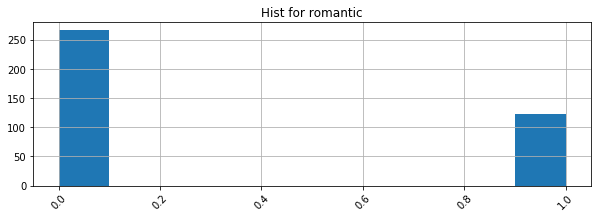

In [405]:
updateFeatureAuto(targetFeature, ['sex', 'age', 'internet',  'score'])

--------------------------------------------
# Устраняем NaN в Fjob

NaN в "Fjob" = 9% 
Исходное распределение


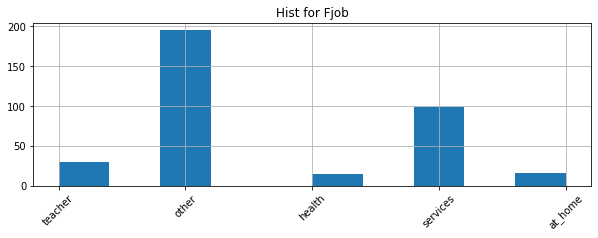

Предложенное АВТО распределение


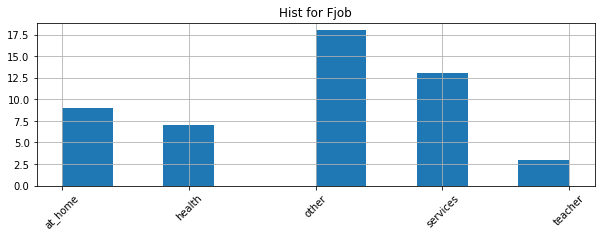

Выбранные колонки ['Medu', 'Fedu']
Колонки для ручного анализа ['Mjob', 'reason', 'guardian', 'studytime granular']


In [406]:
targetFeature = 'Fjob'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


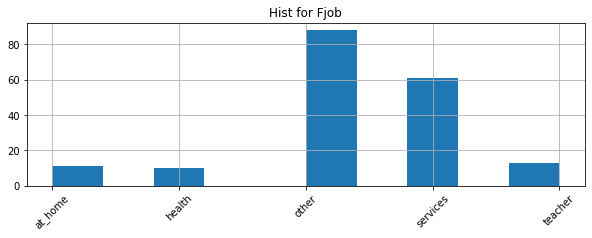

In [407]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['Medu', 'Fedu', 'famsup', 'reason', 'paid'])

NaN в "Fjob"  35 
filter = (Medu == 4.0) & (Fedu == 2.0) & (famsup == 1.0) & (reason == "home") & (paid == 1.0); index = 3
Выбрано 2 строк; Случаев 1;  Значение для Fjob=['other' 'services']


Fjob  Medu  Fedu  famsup reason  paid  count
92      other   4.0   2.0     1.0   home   1.0      1
151  services   4.0   2.0     1.0   home   1.0      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famsup == nan) & (reason == "reputation") & (paid == 0.0); index = 17
filter = (Medu == 4.0) & (Fedu == 2.0) & (famsup == nan) & (reason == "course") & (paid == 0.0); index = 22
filter = (Medu == 2.0) & (Fedu == 2.0) & (famsup == 1.0) & (reason == "home") & (paid == nan); index = 26
filter = (Medu == 4.0) & (Fedu == 4.0) & (famsup == 1.0) & (reason == "reputation") & (paid == nan); index = 31
filter = (Medu == 2.0) & (Fedu == 2.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 44
Выбрано 1 строк; Случаев 4;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
47  other   2.0   2.0     0.0  course   0.0      4

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famsup == 0.0) & (reason == "reputation") & (paid == 0.0); index = 47
Выбрано 2 строк; Случаев 2;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup      reason  paid  count
97      other   4.0   3.0     0.0  reputation   0.0      2
153  services   4.0   3.0     0.0  reputation   0.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 2.0) & (famsup == nan) & (reason == "course") & (paid == 0.0); index = 59
filter = (Medu == 2.0) & (Fedu == 2.0) & (famsup == 1.0) & (reason == "reputation") & (paid == nan); index = 68
filter = (Medu == 3.0) & (Fedu == 3.0) & (famsup == 1.0) & (reason == "home") & (paid == 0.0); index = 107
Выбрано 2 строк; Случаев 1;  Значение для Fjob=['other' 'services']


Fjob  Medu  Fedu  famsup reason  paid  count
78      other   3.0   3.0     1.0   home   0.0      1
144  services   3.0   3.0     1.0   home   0.0      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 3.0) & (famsup == 1.0) & (reason == "course") & (paid == 0.0); index = 118
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fjob=['other']


Empty DataFrame
Columns: [Fjob, Medu, Fedu, famsup, reason, paid, count]
Index: []

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 2.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 120
Выбрано 2 строк; Случаев 1;  Значение для Fjob=['other' 'services']


Fjob  Medu  Fedu  famsup  reason  paid  count
34      other   1.0   2.0     0.0  course   0.0      1
115  services   1.0   2.0     0.0  course   0.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famsup == 1.0) & (reason == "course") & (paid == 0.0); index = 135
Выбрано 2 строк; Случаев 2;  Значение для Fjob=['other' 'teacher']


Fjob  Medu  Fedu  famsup  reason  paid  count
105    other   4.0   4.0     1.0  course   0.0      2
176  teacher   4.0   4.0     1.0  course   0.0      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 1.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 151
Выбрано 2 строк; Случаев 2;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
40      other   2.0   1.0     0.0  course   0.0      2
120  services   2.0   1.0     0.0  course   0.0      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famsup == 1.0) & (reason == "reputation") & (paid == 1.0); index = 152
Выбрано 1 строк; Случаев 2;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup      reason  paid  count
82  other   3.0   3.0     1.0  reputation   1.0      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 1.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 160
Выбрано 2 строк; Случаев 3;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
40      other   2.0   1.0     0.0  course   0.0      3
120  services   2.0   1.0     0.0  course   0.0      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == nan) & (famsup == 1.0) & (reason == "course") & (paid == 0.0); index = 161
filter = (Medu == 4.0) & (Fedu == 4.0) & (famsup == nan) & (reason == "reputation") & (paid == 1.0); index = 169
filter = (Medu == 2.0) & (Fedu == 4.0) & (famsup == 1.0) & (reason == "reputation") & (paid == 0.0); index = 182
Выбрано 1 строк; Случаев 1;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup      reason  paid  count
66  other   2.0   4.0     1.0  reputation   0.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famsup == 0.0) & (reason == "reputation") & (paid == 1.0); index = 216
Выбрано 1 строк; Случаев 1;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup      reason  paid  count
99  other   4.0   3.0     0.0  reputation   1.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 1.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 229
Выбрано 2 строк; Случаев 4;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
40      other   2.0   1.0     0.0  course   0.0      4
120  services   2.0   1.0     0.0  course   0.0      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 2.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 250
Выбрано 1 строк; Случаев 4;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
72  other   3.0   2.0     0.0  course   0.0      4

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 1.0) & (famsup == 0.0) & (reason == "other") & (paid == 1.0); index = 266
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fjob=['other']


Empty DataFrame
Columns: [Fjob, Medu, Fedu, famsup, reason, paid, count]
Index: []

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 2.0) & (famsup == 1.0) & (reason == "reputation") & (paid == 1.0); index = 294
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fjob=['other']


Empty DataFrame
Columns: [Fjob, Medu, Fedu, famsup, reason, paid, count]
Index: []

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 2.0) & (famsup == 1.0) & (reason == "reputation") & (paid == 1.0); index = 303
Выбрано 1 строк; Случаев 1;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup      reason  paid  count
76  other   3.0   2.0     1.0  reputation   1.0      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 1.0) & (famsup == 1.0) & (reason == "reputation") & (paid == nan); index = 309
filter = (Medu == 2.0) & (Fedu == 1.0) & (famsup == 1.0) & (reason == "course") & (paid == 1.0); index = 316
Выбрано 1 строк; Случаев 2;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
45  other   2.0   1.0     1.0  course   1.0      2

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 1.0) & (famsup == 0.0) & (reason == "home") & (paid == 1.0); index = 336
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fjob=['other']


Empty DataFrame
Columns: [Fjob, Medu, Fedu, famsup, reason, paid, count]
Index: []

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famsup == 1.0) & (reason == "home") & (paid == nan); index = 341
filter = (Medu == 3.0) & (Fedu == 2.0) & (famsup == 0.0) & (reason == "other") & (paid == 0.0); index = 345
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fjob=['other']


Empty DataFrame
Columns: [Fjob, Medu, Fedu, famsup, reason, paid, count]
Index: []

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famsup == nan) & (reason == "course") & (paid == 1.0); index = 363
filter = (Medu == 1.0) & (Fedu == 3.0) & (famsup == 1.0) & (reason == "course") & (paid == 1.0); index = 365
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fjob=['other']


Empty DataFrame
Columns: [Fjob, Medu, Fedu, famsup, reason, paid, count]
Index: []

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 2.0) & (famsup == 0.0) & (reason == "course") & (paid == 0.0); index = 373
Выбрано 2 строк; Случаев 2;  Значение для Fjob=['other']


Fjob  Medu  Fedu  famsup  reason  paid  count
34      other   1.0   2.0     0.0  course   0.0      2
120  services   1.0   2.0     0.0  course   0.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == nan) & (famsup == 0.0) & (reason == "reputation") & (paid == 0.0); index = 374
filter = (Medu == 4.0) & (Fedu == 2.0) & (famsup == 0.0) & (reason == "home") & (paid == nan); index = 384
НЕ Все NaN в "Fjob" успешно заменены, осталось 13 из 389
Все NaN в "Fjob" успешно заменены.
----------------------- Проверка распределения Fjob после устранения NaN


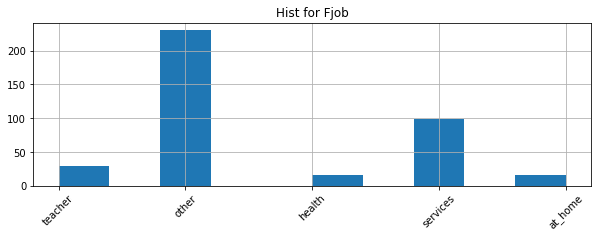

In [408]:
updateFeatureAuto(targetFeature, ['Medu', 'Fedu', 'famsup', 'reason', 'paid'])

------------------------------------------------------
# Устраняем NaN в guardian

NaN в "guardian" = 8% 
Исходное распределение


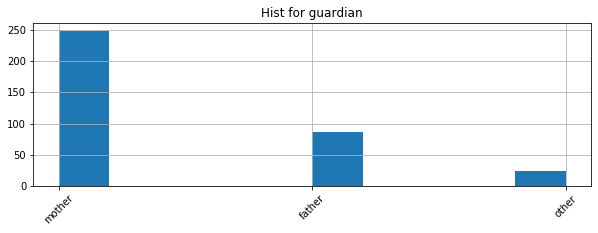

Предложенное АВТО распределение


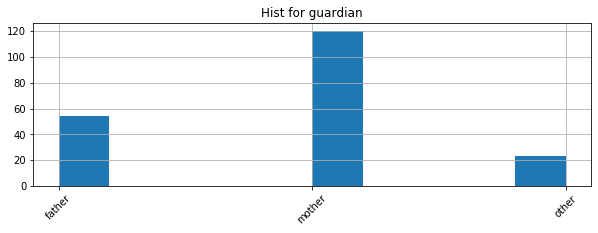

Выбранные колонки ['age', 'failures', 'nursery', 'romantic', 'absences']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'studytime granular']


In [409]:
targetFeature = 'guardian'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


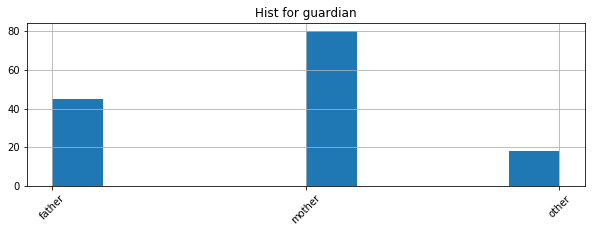

In [410]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, [ 'Medu', 'Mjob', 'nursery', 'famrel'])

NaN в "guardian"  31 
filter = (Medu == 3.0) & (Mjob == "services") & (nursery == 1.0) & (famrel == 4.0); index = 38
Выбрано 3 строк; Случаев 8;  Значение для guardian=['mother']


guardian  Medu      Mjob  nursery  famrel  count
28    father   3.0  services      1.0     4.0      2
99    mother   3.0  services      1.0     4.0      8
138    other   3.0  services      1.0     4.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "teacher") & (nursery == 0.0) & (famrel == 5.0); index = 41
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
120   mother   4.0  teacher      0.0     5.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "services") & (nursery == 0.0) & (famrel == 4.0); index = 49
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu      Mjob  nursery  famrel  count
115   mother   4.0  services      0.0     4.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "services") & (nursery == 1.0) & (famrel == 3.0); index = 53
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu      Mjob  nursery  famrel  count
116   mother   4.0  services      1.0     3.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "health") & (nursery == 1.0) & (famrel == 2.0); index = 60
Выбрано 3 строк; Случаев 1;  Значение для guardian=['father' 'mother' 'other']


guardian  Medu    Mjob  nursery  famrel  count
31    father   4.0  health      1.0     2.0      1
105   mother   4.0  health      1.0     2.0      1
140    other   4.0  health      1.0     2.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "other") & (nursery == 0.0) & (famrel == 5.0); index = 81
Выбрано 1 строк; Случаев 2;  Значение для guardian=['mother']


guardian  Medu   Mjob  nursery  famrel  count
69   mother   2.0  other      0.0     5.0      2

-------------------------------------------------------
filter = (Medu == 3.0) & (Mjob == "other") & (nursery == 1.0) & (famrel == 4.0); index = 90
Выбрано 3 строк; Случаев 8;  Значение для guardian=['mother']


guardian  Medu   Mjob  nursery  famrel  count
25    father   3.0  other      1.0     4.0      5
91    mother   3.0  other      1.0     4.0      8
135    other   3.0  other      1.0     4.0      2

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "other") & (nursery == 0.0) & (famrel == 5.0); index = 98
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для guardian=['mother']


Empty DataFrame
Columns: [guardian, Medu, Mjob, nursery, famrel, count]
Index: []

-------------------------------------------------------
filter = (Medu == 1.0) & (Mjob == "services") & (nursery == 1.0) & (famrel == 4.0); index = 138
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu      Mjob  nursery  famrel  count
60   mother   1.0  services      1.0     4.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "other") & (nursery == 1.0) & (famrel == 5.0); index = 144
Выбрано 2 строк; Случаев 6;  Значение для guardian=['mother']


guardian  Medu   Mjob  nursery  famrel  count
15   father   2.0  other      1.0     5.0      2
72   mother   2.0  other      1.0     5.0      6

-------------------------------------------------------
filter = (Medu == 1.0) & (Mjob == "other") & (nursery == 1.0) & (famrel == 5.0); index = 164
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu   Mjob  nursery  famrel  count
58   mother   1.0  other      1.0     5.0      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Mjob == "at_home") & (nursery == 0.0) & (famrel == 4.0); index = 173
Выбрано 2 строк; Случаев 3;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
47    mother   1.0  at_home      0.0     4.0      3
127    other   1.0  at_home      0.0     4.0      2

-------------------------------------------------------
filter = (Medu == 3.0) & (Mjob == "services") & (nursery == 1.0) & (famrel == 4.0); index = 181
Выбрано 3 строк; Случаев 9;  Значение для guardian=['mother']


guardian  Medu      Mjob  nursery  famrel  count
28    father   3.0  services      1.0     4.0      2
99    mother   3.0  services      1.0     4.0      9
139    other   3.0  services      1.0     4.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "other") & (nursery == 1.0) & (famrel == 3.0); index = 223
Выбрано 2 строк; Случаев 3;  Значение для guardian=['mother']


guardian  Medu   Mjob  nursery  famrel  count
13   father   2.0  other      1.0     3.0      2
70   mother   2.0  other      1.0     3.0      3

-------------------------------------------------------
filter = (Medu == 3.0) & (Mjob == "at_home") & (nursery == 1.0) & (famrel == 5.0); index = 235
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
83   mother   3.0  at_home      1.0     5.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "health") & (nursery == 1.0) & (famrel == 2.0); index = 240
Выбрано 3 строк; Случаев 2;  Значение для guardian=['father']


guardian  Medu    Mjob  nursery  famrel  count
31    father   4.0  health      1.0     2.0      2
105   mother   4.0  health      1.0     2.0      1
141    other   4.0  health      1.0     2.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "other") & (nursery == 1.0) & (famrel == 5.0); index = 258
Выбрано 2 строк; Случаев 7;  Значение для guardian=['mother']


guardian  Medu   Mjob  nursery  famrel  count
15   father   2.0  other      1.0     5.0      2
72   mother   2.0  other      1.0     5.0      7

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "teacher") & (nursery == 1.0) & (famrel == 4.0); index = 279
Выбрано 3 строк; Случаев 17;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
43    father   4.0  teacher      1.0     4.0      2
124   mother   4.0  teacher      1.0     4.0     17
143    other   4.0  teacher      1.0     4.0      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "health") & (nursery == 1.0) & (famrel == 4.0); index = 291
Выбрано 2 строк; Случаев 7;  Значение для guardian=['mother']


guardian  Medu    Mjob  nursery  famrel  count
33    father   4.0  health      1.0     4.0      2
107   mother   4.0  health      1.0     4.0      7

-------------------------------------------------------
filter = (Medu == 3.0) & (Mjob == "at_home") & (nursery == 0.0) & (famrel == 4.0); index = 318
Выбрано 1 строк; Случаев 1;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
80   mother   3.0  at_home      0.0     4.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "at_home") & (nursery == 1.0) & (famrel == 4.0); index = 331
Выбрано 1 строк; Случаев 10;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
64   mother   2.0  at_home      1.0     4.0     10

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "at_home") & (nursery == 1.0) & (famrel == 4.0); index = 344
Выбрано 1 строк; Случаев 11;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
64   mother   2.0  at_home      1.0     4.0     11

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "teacher") & (nursery == 1.0) & (famrel == nan); index = 347
filter = (Medu == 3.0) & (Mjob == "other") & (nursery == 0.0) & (famrel == nan); index = 349
filter = (Medu == 3.0) & (Mjob == "services") & (nursery == 1.0) & (famrel == 4.0); index = 362
Выбрано 3 строк; Случаев 10;  Значение для guardian=['mother']


guardian  Medu      Mjob  nursery  famrel  count
28    father   3.0  services      1.0     4.0      2
99    mother   3.0  services      1.0     4.0     10
139    other   3.0  services      1.0     4.0      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Mjob == "other") & (nursery == 0.0) & (famrel == 3.0); index = 364
Выбрано 1 строк; Случаев 1;  Значение для guardian=['father']


guardian  Medu   Mjob  nursery  famrel  count
4   father   1.0  other      0.0     3.0      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Mjob == "at_home") & (nursery == 1.0) & (famrel == 3.0); index = 365
Выбрано 1 строк; Случаев 3;  Значение для guardian=['mother']


guardian  Medu     Mjob  nursery  famrel  count
49   mother   1.0  at_home      1.0     3.0      3

-------------------------------------------------------
filter = (Medu == 4.0) & (Mjob == "health") & (nursery == 0.0) & (famrel == 5.0); index = 376
Выбрано 1 строк; Случаев 2;  Значение для guardian=['mother']


guardian  Medu    Mjob  nursery  famrel  count
104   mother   4.0  health      0.0     5.0      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "at_home") & (nursery == 1.0) & (famrel == 5.0); index = 385
Выбрано 1 строк; Случаев 1;  Значение для guardian=['father']


guardian  Medu     Mjob  nursery  famrel  count
10   father   2.0  at_home      1.0     5.0      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Mjob == "services") & (nursery == 1.0) & (famrel == 5.0); index = 390
Выбрано 2 строк; Случаев 3;  Значение для guardian=['father' 'mother']


guardian  Medu      Mjob  nursery  famrel  count
19   father   2.0  services      1.0     5.0      3
79   mother   2.0  services      1.0     5.0      3

-------------------------------------------------------
filter = (Medu == 1.0) & (Mjob == "other") & (nursery == 0.0) & (famrel == 5.0); index = 392
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для guardian=['mother']


Empty DataFrame
Columns: [guardian, Medu, Mjob, nursery, famrel, count]
Index: []

-------------------------------------------------------
НЕ Все NaN в "guardian" успешно заменены, осталось 2 из 389
Все NaN в "guardian" успешно заменены.
----------------------- Проверка распределения guardian после устранения NaN


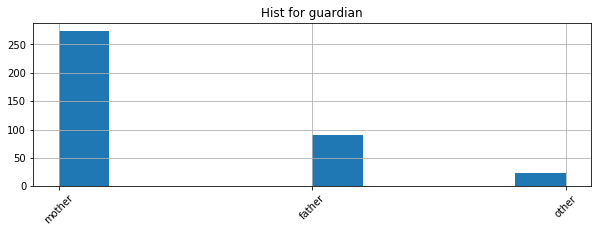

In [411]:
updateFeatureAuto(targetFeature, [ 'Medu', 'Mjob', 'nursery', 'famrel'])

-------------------------------------------------
# Устраняем NaN в traveltime

NaN в "traveltime" = 7% 
Исходное распределение


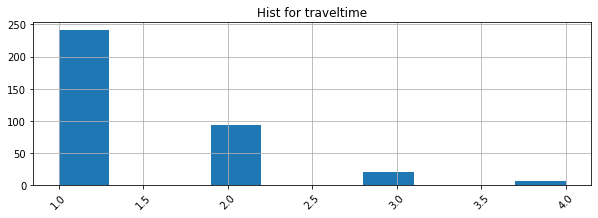

Предложенное АВТО распределение


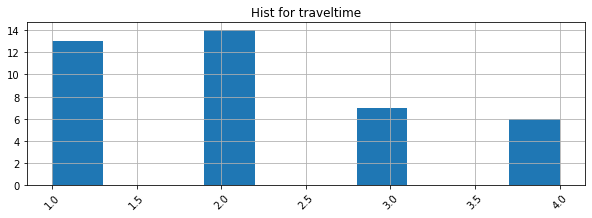

Выбранные колонки ['school', 'address', 'studytime']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [412]:
targetFeature = 'traveltime'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


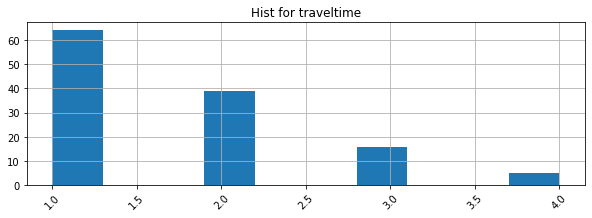

In [413]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['Mjob','Fjob','reason'])

NaN в "traveltime"  26 
filter = (Mjob == "other") & (Fjob == "other") & (reason == "home"); index = 26
Выбрано 4 строк; Случаев 23;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob reason  count
25          1.0  other  other   home     23
79          2.0  other  other   home      6
109         3.0  other  other   home      1
120         4.0  other  other   home      2

-------------------------------------------------------
filter = (Mjob == "health") & (Fjob == "services") & (reason == "home"); index = 30
Выбрано 1 строк; Случаев 3;  Значение для traveltime=[1.]


traveltime    Mjob      Fjob reason  count
17         1.0  health  services   home      3

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "other"); index = 35
Выбрано 2 строк; Случаев 4;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob reason  count
26         1.0  other  other  other      4
80         2.0  other  other  other      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "teacher") & (reason == "reputation"); index = 37
Выбрано 1 строк; Случаев 1;  Значение для traveltime=[2.]


traveltime   Mjob     Fjob      reason  count
86         2.0  other  teacher  reputation      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "course"); index = 59
Выбрано 3 строк; Случаев 21;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob  reason  count
24          1.0  other  other  course     21
78          2.0  other  other  course      8
108         3.0  other  other  course      3

-------------------------------------------------------
filter = (Mjob == "health") & (Fjob == "other") & (reason == "reputation"); index = 68
Выбрано 2 строк; Случаев 6;  Значение для traveltime=[1.]


traveltime    Mjob   Fjob      reason  count
15         1.0  health  other  reputation      6
76         2.0  health  other  reputation      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "reputation"); index = 70
Выбрано 3 строк; Случаев 17;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob      reason  count
27          1.0  other  other  reputation     17
81          2.0  other  other  reputation     10
110         3.0  other  other  reputation      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "course"); index = 104
Выбрано 3 строк; Случаев 22;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob  reason  count
24          1.0  other  other  course     22
78          2.0  other  other  course      8
108         3.0  other  other  course      3

-------------------------------------------------------
filter = (Mjob == "at_home") & (Fjob == "other") & (reason == "course"); index = 112
Выбрано 4 строк; Случаев 9;  Значение для traveltime=[1.]


traveltime     Mjob   Fjob  reason  count
4           1.0  at_home  other  course      9
66          2.0  at_home  other  course      2
103         3.0  at_home  other  course      4
119         4.0  at_home  other  course      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "course"); index = 132
Выбрано 3 строк; Случаев 23;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob  reason  count
24          1.0  other  other  course     23
78          2.0  other  other  course      8
108         3.0  other  other  course      3

-------------------------------------------------------
filter = (Mjob == "at_home") & (Fjob == "teacher") & (reason == "course"); index = 134
Выбрано 1 строк; Случаев 1;  Значение для traveltime=[2.]


traveltime     Mjob     Fjob  reason  count
73         2.0  at_home  teacher  course      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "course"); index = 137
Выбрано 3 строк; Случаев 24;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob  reason  count
24          1.0  other  other  course     24
78          2.0  other  other  course      8
108         3.0  other  other  course      3

-------------------------------------------------------
filter = (Mjob == "teacher") & (Fjob == "services") & (reason == "course"); index = 142
Выбрано 3 строк; Случаев 4;  Значение для traveltime=[1.]


traveltime     Mjob      Fjob  reason  count
57          1.0  teacher  services  course      4
98          2.0  teacher  services  course      2
118         3.0  teacher  services  course      1

-------------------------------------------------------
filter = (Mjob == "at_home") & (Fjob == "other") & (reason == "course"); index = 147
Выбрано 4 строк; Случаев 10;  Значение для traveltime=[1.]


traveltime     Mjob   Fjob  reason  count
4           1.0  at_home  other  course     10
66          2.0  at_home  other  course      2
103         3.0  at_home  other  course      4
119         4.0  at_home  other  course      1

-------------------------------------------------------
filter = (Mjob == "at_home") & (Fjob == "other") & (reason == "course"); index = 157
Выбрано 4 строк; Случаев 11;  Значение для traveltime=[1.]


traveltime     Mjob   Fjob  reason  count
4           1.0  at_home  other  course     11
66          2.0  at_home  other  course      2
103         3.0  at_home  other  course      4
119         4.0  at_home  other  course      1

-------------------------------------------------------
filter = (Mjob == "at_home") & (Fjob == "other") & (reason == "course"); index = 160
Выбрано 4 строк; Случаев 12;  Значение для traveltime=[1.]


traveltime     Mjob   Fjob  reason  count
4           1.0  at_home  other  course     12
66          2.0  at_home  other  course      2
103         3.0  at_home  other  course      4
119         4.0  at_home  other  course      1

-------------------------------------------------------
filter = (Mjob == "services") & (Fjob == "other") & (reason == "reputation"); index = 182
Выбрано 3 строк; Случаев 8;  Значение для traveltime=[2.]


traveltime      Mjob   Fjob      reason  count
41          1.0  services  other  reputation      5
89          2.0  services  other  reputation      8
114         3.0  services  other  reputation      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "course"); index = 226
Выбрано 3 строк; Случаев 25;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob  reason  count
24          1.0  other  other  course     25
78          2.0  other  other  course      8
108         3.0  other  other  course      3

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "home"); index = 234
Выбрано 4 строк; Случаев 24;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob reason  count
25          1.0  other  other   home     24
79          2.0  other  other   home      6
109         3.0  other  other   home      1
120         4.0  other  other   home      2

-------------------------------------------------------
filter = (Mjob == "teacher") & (Fjob == "other") & (reason == "course"); index = 261
Выбрано 2 строк; Случаев 6;  Значение для traveltime=[1.]


traveltime     Mjob   Fjob  reason  count
53         1.0  teacher  other  course      6
96         2.0  teacher  other  course      3

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "reputation"); index = 268
Выбрано 3 строк; Случаев 18;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob      reason  count
27          1.0  other  other  reputation     18
81          2.0  other  other  reputation     10
110         3.0  other  other  reputation      1

-------------------------------------------------------
filter = (Mjob == "services") & (Fjob == "services") & (reason == "home"); index = 310
Выбрано 2 строк; Случаев 6;  Значение для traveltime=[1.]


traveltime      Mjob      Fjob reason  count
43         1.0  services  services   home      6
91         2.0  services  services   home      2

-------------------------------------------------------
filter = (Mjob == "health") & (Fjob == "other") & (reason == "reputation"); index = 348
Выбрано 2 строк; Случаев 7;  Значение для traveltime=[1.]


traveltime    Mjob   Fjob      reason  count
15         1.0  health  other  reputation      7
76         2.0  health  other  reputation      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "home"); index = 384
Выбрано 4 строк; Случаев 25;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob reason  count
25          1.0  other  other   home     25
79          2.0  other  other   home      6
109         3.0  other  other   home      1
120         4.0  other  other   home      2

-------------------------------------------------------
filter = (Mjob == "at_home") & (Fjob == "other") & (reason == "other"); index = 385
Выбрано 3 строк; Случаев 1;  Значение для traveltime=[1. 2. 3.]


traveltime     Mjob   Fjob reason  count
6           1.0  at_home  other  other      1
68          2.0  at_home  other  other      1
104         3.0  at_home  other  other      1

-------------------------------------------------------
filter = (Mjob == "other") & (Fjob == "other") & (reason == "course"); index = 389
Выбрано 3 строк; Случаев 26;  Значение для traveltime=[1.]


traveltime   Mjob   Fjob  reason  count
24          1.0  other  other  course     26
78          2.0  other  other  course      8
108         3.0  other  other  course      3

-------------------------------------------------------
Все NaN в "traveltime" успешно заменены.
----------------------- Проверка распределения traveltime после устранения NaN


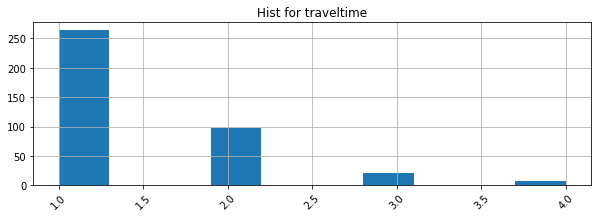

In [414]:
updateFeatureAuto(targetFeature, ['Mjob','Fjob','reason'])

-------------------------------------------------
# Устраняем NaN в failures

NaN в "failures" = 6% 
Исходное распределение


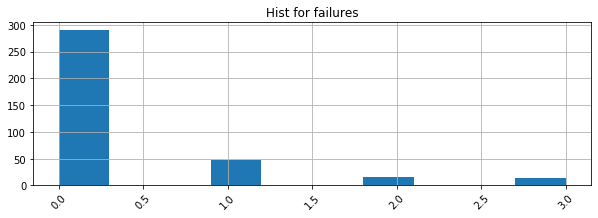

Предложенное АВТО распределение


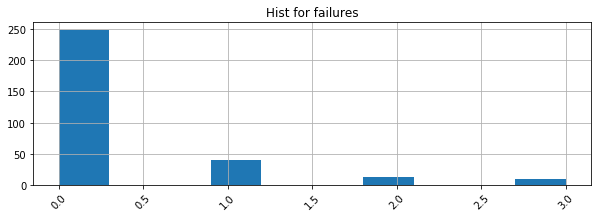

Выбранные колонки ['age', 'Medu', 'Fedu', 'studytime', 'paid', 'higher', 'romantic', 'absences', 'score']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [415]:
targetFeature = 'failures'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


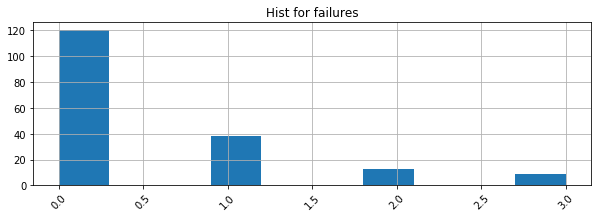

In [416]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['paid',  'romantic', 'absences','goout'])

NaN в "failures"  22 
filter = (paid == nan) & (romantic == 0.0) & (absences == 0.0) & (goout == 2.0); index = 21
filter = (paid == 1.0) & (romantic == 0.0) & (absences == 2.0) & (goout == 3.0); index = 48
Выбрано 1 строк; Случаев 9;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
72       0.0   1.0       0.0       2.0    3.0      9

-------------------------------------------------------
filter = (paid == 1.0) & (romantic == 0.0) & (absences == 6.0) & (goout == 4.0); index = 54
Выбрано 1 строк; Случаев 2;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
82       0.0   1.0       0.0       6.0    4.0      2

-------------------------------------------------------
filter = (paid == nan) & (romantic == 0.0) & (absences == 2.0) & (goout == 3.0); index = 68
filter = (paid == 1.0) & (romantic == 0.0) & (absences == 4.0) & (goout == 5.0); index = 91
Выбрано 1 строк; Случаев 1;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
78       0.0   1.0       0.0       4.0    5.0      1

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 0.0) & (absences == 2.0) & (goout == 3.0); index = 107
Выбрано 2 строк; Случаев 7;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
9         0.0   0.0       0.0       2.0    3.0      7
125       1.0   0.0       0.0       2.0    3.0      1

-------------------------------------------------------
filter = (paid == 1.0) & (romantic == 1.0) & (absences == 6.0) & (goout == 5.0); index = 108
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для failures=[0.]


Empty DataFrame
Columns: [failures, paid, romantic, absences, goout, count]
Index: []

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 1.0) & (absences == 8.0) & (goout == 2.0); index = 114
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для failures=[0.]


Empty DataFrame
Columns: [failures, paid, romantic, absences, goout, count]
Index: []

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 0.0) & (absences == 2.0) & (goout == 4.0); index = 115
Выбрано 2 строк; Случаев 2;  Значение для failures=[1.]


failures  paid  romantic  absences  goout  count
10        0.0   0.0       0.0       2.0    4.0      1
128       1.0   0.0       0.0       2.0    4.0      2

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 0.0) & (absences == 0.0) & (goout == 5.0); index = 125
Выбрано 3 строк; Случаев 2;  Значение для failures=[3.]


failures  paid  romantic  absences  goout  count
4         0.0   0.0       0.0       0.0    5.0      1
126       1.0   0.0       0.0       0.0    5.0      1
174       3.0   0.0       0.0       0.0    5.0      2

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 1.0) & (absences == 0.0) & (goout == 4.0); index = 153
Выбрано 2 строк; Случаев 3;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
44        0.0   0.0       1.0       0.0    4.0      3
141       1.0   0.0       1.0       0.0    4.0      2

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 0.0) & (absences == 2.0) & (goout == 2.0); index = 158
Выбрано 2 строк; Случаев 4;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
8         0.0   0.0       0.0       2.0    2.0      4
176       3.0   0.0       0.0       2.0    2.0      1

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 0.0) & (absences == 0.0) & (goout == 5.0); index = 170
Выбрано 3 строк; Случаев 3;  Значение для failures=[3.]


failures  paid  romantic  absences  goout  count
4         0.0   0.0       0.0       0.0    5.0      1
126       1.0   0.0       0.0       0.0    5.0      1
174       3.0   0.0       0.0       0.0    5.0      3

-------------------------------------------------------
filter = (paid == 1.0) & (romantic == 1.0) & (absences == 2.0) & (goout == 2.0); index = 171
Выбрано 1 строк; Случаев 4;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
103       0.0   1.0       1.0       2.0    2.0      4

-------------------------------------------------------
filter = (paid == 1.0) & (romantic == 0.0) & (absences == 6.0) & (goout == 5.0); index = 204
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для failures=[0.]


Empty DataFrame
Columns: [failures, paid, romantic, absences, goout, count]
Index: []

-------------------------------------------------------
filter = (paid == nan) & (romantic == 0.0) & (absences == 12.0) & (goout == 1.0); index = 214
filter = (paid == nan) & (romantic == 1.0) & (absences == 4.0) & (goout == 2.0); index = 236
filter = (paid == 1.0) & (romantic == 0.0) & (absences == 2.0) & (goout == 2.0); index = 261
Выбрано 2 строк; Случаев 3;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
72        0.0   1.0       0.0       2.0    2.0      3
151       1.0   1.0       0.0       2.0    2.0      1

-------------------------------------------------------
filter = (paid == 1.0) & (romantic == 0.0) & (absences == 30.0) & (goout == 4.0); index = 280
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для failures=[0.]


Empty DataFrame
Columns: [failures, paid, romantic, absences, goout, count]
Index: []

-------------------------------------------------------
filter = (paid == nan) & (romantic == 1.0) & (absences == 22.0) & (goout == 2.0); index = 313
filter = (paid == 1.0) & (romantic == 1.0) & (absences == 23.0) & (goout == 2.0); index = 320
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для failures=[0.]


Empty DataFrame
Columns: [failures, paid, romantic, absences, goout, count]
Index: []

-------------------------------------------------------
filter = (paid == 0.0) & (romantic == 0.0) & (absences == 4.0) & (goout == 3.0); index = 344
Выбрано 1 строк; Случаев 8;  Значение для failures=[0.]


failures  paid  romantic  absences  goout  count
16       0.0   0.0       0.0       4.0    3.0      8

-------------------------------------------------------
НЕ Все NaN в "failures" успешно заменены, осталось 5 из 389
Все NaN в "failures" успешно заменены.
----------------------- Проверка распределения failures после устранения NaN


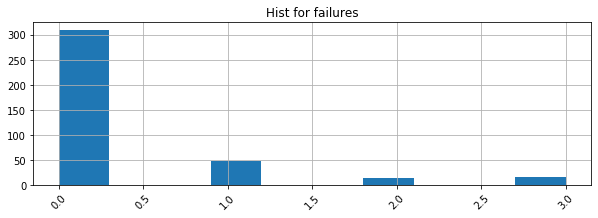

In [417]:
updateFeatureAuto(targetFeature, ['paid',  'romantic', 'absences','goout'])

-------------------------------------------------
# Устраняем NaN в famsup

NaN в "famsup" = 10% 
Исходное распределение


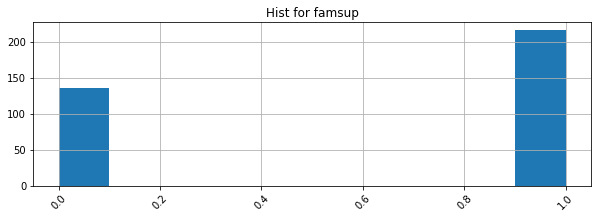

Предложенное АВТО распределение


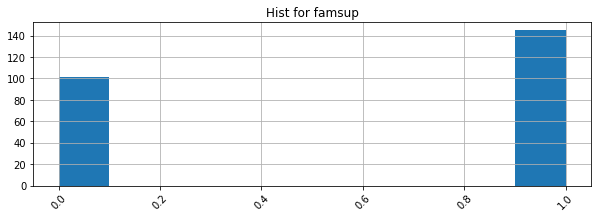

Выбранные колонки ['school', 'sex', 'age', 'Medu', 'Fedu', 'studytime', 'paid', 'higher', 'internet']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [418]:
targetFeature = 'famsup'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


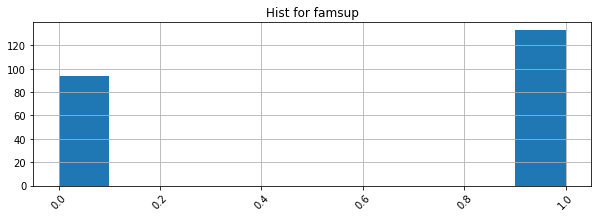

In [419]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['famsize', 'Medu',  'studytime', 'paid', 'reason','guardian'])

NaN в "famsup"  37 
filter = (famsize == 1.0) & (Medu == 3.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "reputation") & (guardian == "mother"); index = 17
Выбрано 2 строк; Случаев 1;  Значение для famsup=[0. 1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
71      0.0      1.0   3.0        2.0   0.0  reputation   mother      1
181     1.0      1.0   3.0        2.0   0.0  reputation   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "course") & (guardian == "mother"); index = 22
Выбрано 1 строк; Случаев 1;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
124     1.0      0.0   4.0        2.0   0.0  course   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 3.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "home") & (guardian == "mother"); index = 28
Выбрано 2 строк; Случаев 2;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid reason guardian  count
20      0.0      0.0   3.0        2.0   0.0   home   mother      2
111     1.0      0.0   3.0        2.0   0.0   home   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 3.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "home") & (guardian == "mother"); index = 33
Выбрано 2 строк; Случаев 3;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid reason guardian  count
20      0.0      0.0   3.0        2.0   0.0   home   mother      3
111     1.0      0.0   3.0        2.0   0.0   home   mother      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 3.0) & (studytime == 3.0) & (paid == 1.0) & (reason == "course") & (guardian == "mother"); index = 38
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsup=[1.]


Empty DataFrame
Columns: [famsup, famsize, Medu, studytime, paid, reason, guardian, count]
Index: []

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 2.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "home") & (guardian == "mother"); index = 40
Выбрано 1 строк; Случаев 1;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid reason guardian  count
12     0.0      0.0   2.0        2.0   0.0   home   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == nan) & (reason == "other") & (guardian == "mother"); index = 51
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "course") & (guardian == "mother"); index = 59
Выбрано 2 строк; Случаев 2;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
83      0.0      1.0   4.0        2.0   0.0  course   mother      1
205     1.0      1.0   4.0        2.0   0.0  course   mother      2

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 1.0) & (studytime == 1.0) & (paid == 0.0) & (reason == "course") & (guardian == "father"); index = 61
Выбрано 1 строк; Случаев 1;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
32     0.0      1.0   1.0        1.0   0.0  course   father      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 1.0) & (paid == 0.0) & (reason == "home") & (guardian == "mother"); index = 78
Выбрано 1 строк; Случаев 1;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid reason guardian  count
148     1.0      1.0   2.0        1.0   0.0   home   mother      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 1.0) & (paid == 0.0) & (reason == "reputation") & (guardian == "mother"); index = 98
Выбрано 1 строк; Случаев 1;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
199     1.0      1.0   4.0        1.0   0.0  reputation   mother      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 0.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "course") & (guardian == "other"); index = 127
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsup=[1.]


Empty DataFrame
Columns: [famsup, famsize, Medu, studytime, paid, reason, guardian, count]
Index: []

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 3.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "home") & (guardian == "father"); index = 146
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsup=[1.]


Empty DataFrame
Columns: [famsup, famsize, Medu, studytime, paid, reason, guardian, count]
Index: []

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 2.0) & (studytime == 1.0) & (paid == 0.0) & (reason == "course") & (guardian == "mother"); index = 149
Выбрано 1 строк; Случаев 2;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
10     0.0      0.0   2.0        1.0   0.0  course   mother      2

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "home") & (guardian == "father"); index = 167
Выбрано 2 строк; Случаев 1;  Значение для famsup=[0. 1.]


famsup  famsize  Medu  studytime  paid reason guardian  count
87      0.0      1.0   4.0        2.0   1.0   home   father      1
213     1.0      1.0   4.0        2.0   1.0   home   father      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "reputation") & (guardian == "mother"); index = 169
Выбрано 2 строк; Случаев 3;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
90      0.0      1.0   4.0        2.0   1.0  reputation   mother      2
217     1.0      1.0   4.0        2.0   1.0  reputation   mother      3

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "home") & (guardian == "mother"); index = 180
Выбрано 1 строк; Случаев 7;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid reason guardian  count
214     1.0      1.0   4.0        2.0   1.0   home   mother      7

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "course") & (guardian == "father"); index = 195
Выбрано 1 строк; Случаев 2;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
44     0.0      1.0   2.0        2.0   0.0  course   father      2

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "other") & (guardian == "mother"); index = 222
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsup=[1.]


Empty DataFrame
Columns: [famsup, famsize, Medu, studytime, paid, reason, guardian, count]
Index: []

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "reputation") & (guardian == "mother"); index = 232
Выбрано 1 строк; Случаев 1;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
85     0.0      1.0   4.0        2.0   0.0  reputation   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 1.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "home") & (guardian == "mother"); index = 234
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsup=[1.]


Empty DataFrame
Columns: [famsup, famsize, Medu, studytime, paid, reason, guardian, count]
Index: []

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 1.0) & (paid == 0.0) & (reason == "home") & (guardian == "mother"); index = 237
Выбрано 1 строк; Случаев 2;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid reason guardian  count
150     1.0      1.0   2.0        1.0   0.0   home   mother      2

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 1.0) & (paid == nan) & (reason == "course") & (guardian == "father"); index = 246
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "reputation") & (guardian == "mother"); index = 267
Выбрано 2 строк; Случаев 4;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
90      0.0      1.0   4.0        2.0   1.0  reputation   mother      2
219     1.0      1.0   4.0        2.0   1.0  reputation   mother      4

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "reputation") & (guardian == "father"); index = 268
Выбрано 2 строк; Случаев 1;  Значение для famsup=[0. 1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
89      0.0      1.0   4.0        2.0   1.0  reputation   father      1
218     1.0      1.0   4.0        2.0   1.0  reputation   father      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "reputation") & (guardian == "mother"); index = 269
Выбрано 2 строк; Случаев 1;  Значение для famsup=[0. 1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
47      0.0      1.0   2.0        2.0   0.0  reputation   mother      1
161     1.0      1.0   2.0        2.0   0.0  reputation   mother      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 4.0) & (paid == 1.0) & (reason == "reputation") & (guardian == "father"); index = 271
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famsup=[1.]


Empty DataFrame
Columns: [famsup, famsize, Medu, studytime, paid, reason, guardian, count]
Index: []

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 1.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "home") & (guardian == "mother"); index = 272
Выбрано 1 строк; Случаев 1;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid reason guardian  count
97     1.0      0.0   1.0        2.0   1.0   home   mother      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 3.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "home") & (guardian == "mother"); index = 276
Выбрано 1 строк; Случаев 1;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid reason guardian  count
69     0.0      1.0   3.0        2.0   0.0   home   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 4.0) & (studytime == 1.0) & (paid == nan) & (reason == "course") & (guardian == "mother"); index = 279
filter = (famsize == 0.0) & (Medu == 2.0) & (studytime == 2.0) & (paid == 0.0) & (reason == "reputation") & (guardian == "mother"); index = 292
Выбрано 1 строк; Случаев 1;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
103     1.0      0.0   2.0        2.0   0.0  reputation   mother      1

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 3.0) & (paid == 1.0) & (reason == "reputation") & (guardian == "mother"); index = 302
Выбрано 1 строк; Случаев 4;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid      reason guardian  count
228     1.0      1.0   4.0        3.0   1.0  reputation   mother      4

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 3.0) & (studytime == 2.0) & (paid == nan) & (reason == "reputation") & (guardian == "other"); index = 313
filter = (famsize == 1.0) & (Medu == 2.0) & (studytime == 1.0) & (paid == 0.0) & (reason == "course") & (guardian == "mother"); index = 327
Выбрано 1 строк; Случаев 3;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
41     0.0      1.0   2.0        1.0   0.0  course   mother      3

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 4.0) & (studytime == 3.0) & (paid == 1.0) & (reason == "course") & (guardian == "mother"); index = 328
Выбрано 1 строк; Случаев 6;  Значение для famsup=[1.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
226     1.0      1.0   4.0        3.0   1.0  course   mother      6

-------------------------------------------------------
filter = (famsize == 1.0) & (Medu == 3.0) & (studytime == 3.0) & (paid == 0.0) & (reason == "course") & (guardian == "mother"); index = 335
Выбрано 1 строк; Случаев 1;  Значение для famsup=[0.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
74     0.0      1.0   3.0        3.0   0.0  course   mother      1

-------------------------------------------------------
filter = (famsize == 0.0) & (Medu == 4.0) & (studytime == 2.0) & (paid == 1.0) & (reason == "course") & (guardian == "mother"); index = 363
Выбрано 2 строк; Случаев 2;  Значение для famsup=[0. 1.]


famsup  famsize  Medu  studytime  paid  reason guardian  count
28      0.0      0.0   4.0        2.0   1.0  course   mother      2
128     1.0      0.0   4.0        2.0   1.0  course   mother      2

-------------------------------------------------------
НЕ Все NaN в "famsup" успешно заменены, осталось 4 из 389
Все NaN в "famsup" успешно заменены.
----------------------- Проверка распределения famsup после устранения NaN


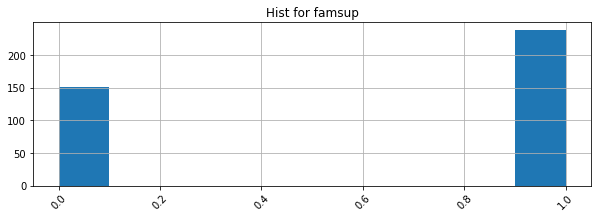

In [420]:
updateFeatureAuto(targetFeature, ['famsize', 'Medu',  'studytime', 'paid', 'reason','guardian'])

-----------------------------------------
# Устраняем NaN в paid

NaN в "paid" = 10% 
Исходное распределение


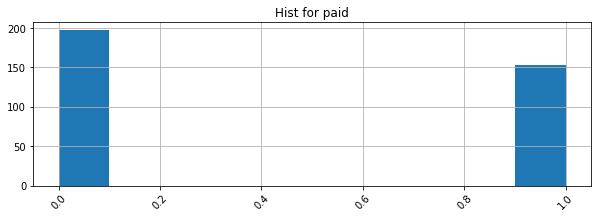

Предложенное АВТО распределение


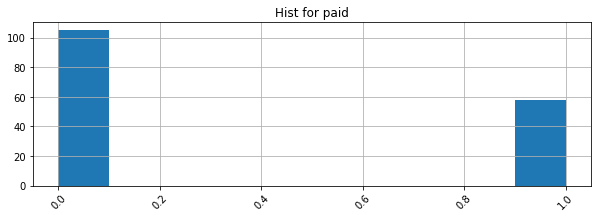

Выбранные колонки ['Medu', 'studytime', 'failures', 'famsup', 'nursery', 'higher', 'internet']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [421]:
targetFeature = 'paid'
ok_list, test_list = get_FeaturesAuto(targetFeature)


Распределение с учетом оптимизации параметров


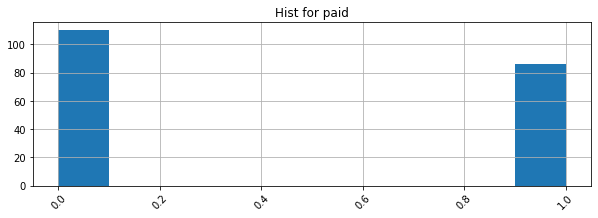

In [422]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['Fjob', 'Medu', 'Fedu', 'Mjob', 'famsup' ])

NaN в "paid"  39 
filter = (Fjob == "other") & (Medu == 1.0) & (Fedu == 1.0) & (Mjob == "at_home") & (famsup == 0.0); index = 2
Выбрано 1 строк; Случаев 1;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu     Mjob  famsup  count
15   0.0  other   1.0   1.0  at_home     0.0      1

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "services") & (famsup == 1.0); index = 18
Выбрано 1 строк; Случаев 1;  Значение для paid=[0.]


paid      Fjob  Medu  Fedu      Mjob  famsup  count
86   0.0  services   3.0   2.0  services     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 3.0) & (Mjob == "health") & (famsup == 0.0); index = 19
Выбрано 1 строк; Случаев 3;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu    Mjob  famsup  count
61   0.0  other   4.0   3.0  health     0.0      3

-------------------------------------------------------
filter = (Fjob == "health") & (Medu == 4.0) & (Fedu == nan) & (Mjob == "health") & (famsup == 1.0); index = 21
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == 2.0) & (Mjob == "other") & (famsup == 1.0); index = 26
Выбрано 2 строк; Случаев 8;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
33    0.0  other   2.0   2.0  other     1.0      8
136   1.0  other   2.0   2.0  other     1.0      5

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "services") & (famsup == 1.0); index = 31
Выбрано 2 строк; Случаев 2;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu      Mjob  famsup  count
67    0.0  other   4.0   4.0  services     1.0      2
167   1.0  other   4.0   4.0  services     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 2.0) & (Mjob == "health") & (famsup == 1.0); index = 51
Выбрано 1 строк; Случаев 2;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu    Mjob  famsup  count
153   1.0  other   4.0   2.0  health     1.0      2

-------------------------------------------------------
filter = (Fjob == "health") & (Medu == 4.0) & (Fedu == nan) & (Mjob == "teacher") & (famsup == 1.0); index = 57
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == 2.0) & (Mjob == "health") & (famsup == 1.0); index = 68
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для paid=[0.]


Empty DataFrame
Columns: [paid, Fjob, Medu, Fedu, Mjob, famsup, count]
Index: []

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == 3.0) & (Mjob == "other") & (famsup == 0.0); index = 81
Выбрано 1 строк; Случаев 2;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
37   0.0  other   2.0   3.0  other     0.0      2

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "services") & (famsup == 1.0); index = 82
Выбрано 1 строк; Случаев 3;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu      Mjob  famsup  count
146   1.0  other   3.0   2.0  services     1.0      3

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 3.0) & (Mjob == "services") & (famsup == 1.0); index = 96
Выбрано 1 строк; Случаев 2;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu      Mjob  famsup  count
162   1.0  other   4.0   3.0  services     1.0      2

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 4.0) & (Mjob == "other") & (famsup == 1.0); index = 104
Выбрано 2 строк; Случаев 2;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
54    0.0  other   3.0   4.0  other     1.0      1
153   1.0  other   3.0   4.0  other     1.0      2

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 4.0) & (Mjob == "at_home") & (famsup == 0.0); index = 136
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для paid=[0.]


Empty DataFrame
Columns: [paid, Fjob, Medu, Fedu, Mjob, famsup, count]
Index: []

-------------------------------------------------------
filter = (Fjob == "teacher") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (famsup == 1.0); index = 148
Выбрано 2 строк; Случаев 3;  Значение для paid=[1.]


paid     Fjob  Medu  Fedu     Mjob  famsup  count
111   0.0  teacher   4.0   4.0  teacher     1.0      1
197   1.0  teacher   4.0   4.0  teacher     1.0      3

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 1.0) & (Fedu == 1.0) & (Mjob == "other") & (famsup == 0.0); index = 164
Выбрано 1 строк; Случаев 2;  Значение для paid=[0.]


paid      Fjob  Medu  Fedu   Mjob  famsup  count
72   0.0  services   1.0   1.0  other     0.0      2

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 4.0) & (Fedu == 2.0) & (Mjob == "teacher") & (famsup == 1.0); index = 178
Выбрано 1 строк; Случаев 1;  Значение для paid=[1.]


paid      Fjob  Medu  Fedu     Mjob  famsup  count
185   1.0  services   4.0   2.0  teacher     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "other") & (famsup == 1.0); index = 184
Выбрано 1 строк; Случаев 3;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
146   1.0  other   3.0   2.0  other     1.0      3

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 1.0) & (Fedu == 2.0) & (Mjob == "at_home") & (famsup == 0.0); index = 192
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для paid=[0.]


Empty DataFrame
Columns: [paid, Fjob, Medu, Fedu, Mjob, famsup, count]
Index: []

-------------------------------------------------------
filter = (Fjob == "teacher") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (famsup == 1.0); index = 199
Выбрано 2 строк; Случаев 4;  Значение для paid=[1.]


paid     Fjob  Medu  Fedu     Mjob  famsup  count
112   0.0  teacher   4.0   4.0  teacher     1.0      1
198   1.0  teacher   4.0   4.0  teacher     1.0      4

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 3.0) & (Mjob == "health") & (famsup == 1.0); index = 200
Выбрано 1 строк; Случаев 1;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu    Mjob  famsup  count
160   1.0  other   4.0   3.0  health     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "services") & (famsup == 1.0); index = 214
Выбрано 2 строк; Случаев 3;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu      Mjob  famsup  count
69    0.0  other   4.0   4.0  services     1.0      3
170   1.0  other   4.0   4.0  services     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "other") & (famsup == 0.0); index = 215
Выбрано 1 строк; Случаев 3;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
45   0.0  other   3.0   2.0  other     0.0      3

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == 3.0) & (Mjob == "at_home") & (famsup == 1.0); index = 218
Выбрано 1 строк; Случаев 1;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu     Mjob  famsup  count
36   0.0  other   2.0   3.0  at_home     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == nan) & (Mjob == "other") & (famsup == 0.0); index = 236
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == 3.0) & (Mjob == "other") & (famsup == 1.0); index = 246
Выбрано 1 строк; Случаев 1;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
38   0.0  other   2.0   3.0  other     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 2.0) & (Fedu == 1.0) & (Mjob == "other") & (famsup == 0.0); index = 253
Выбрано 2 строк; Случаев 6;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
27    0.0  other   2.0   1.0  other     0.0      6
133   1.0  other   2.0   1.0  other     0.0      2

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 4.0) & (Fedu == 2.0) & (Mjob == "teacher") & (famsup == 1.0); index = 256
Выбрано 1 строк; Случаев 2;  Значение для paid=[1.]


paid      Fjob  Medu  Fedu     Mjob  famsup  count
186   1.0  services   4.0   2.0  teacher     1.0      2

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 3.0) & (Mjob == "other") & (famsup == 0.0); index = 263
Выбрано 2 строк; Случаев 3;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
49    0.0  other   3.0   3.0  other     0.0      3
150   1.0  other   3.0   3.0  other     0.0      2

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 4.0) & (Fedu == 3.0) & (Mjob == "teacher") & (famsup == 1.0); index = 279
Выбрано 1 строк; Случаев 3;  Значение для paid=[0.]


paid      Fjob  Medu  Fedu     Mjob  famsup  count
99   0.0  services   4.0   3.0  teacher     1.0      3

-------------------------------------------------------
filter = (Fjob == "at_home") & (Medu == 2.0) & (Fedu == 4.0) & (Mjob == "services") & (famsup == 1.0); index = 305
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для paid=[0.]


Empty DataFrame
Columns: [paid, Fjob, Medu, Fedu, Mjob, famsup, count]
Index: []

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 1.0) & (Fedu == 1.0) & (Mjob == "at_home") & (famsup == 1.0); index = 309
Выбрано 2 строк; Случаев 4;  Значение для paid=[0.]


paid   Fjob  Medu  Fedu     Mjob  famsup  count
17    0.0  other   1.0   1.0  at_home     1.0      4
128   1.0  other   1.0   1.0  at_home     1.0      3

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 3.0) & (Fedu == 2.0) & (Mjob == "services") & (famsup == 1.0); index = 313
Выбрано 1 строк; Случаев 4;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu      Mjob  famsup  count
149   1.0  other   3.0   2.0  services     1.0      4

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 3.0) & (Fedu == 4.0) & (Mjob == "at_home") & (famsup == 1.0); index = 318
Выбрано 1 строк; Случаев 1;  Значение для paid=[1.]


paid      Fjob  Medu  Fedu     Mjob  famsup  count
185   1.0  services   3.0   4.0  at_home     1.0      1

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (famsup == 1.0); index = 319
Выбрано 2 строк; Случаев 3;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu     Mjob  famsup  count
71    0.0  other   4.0   4.0  teacher     1.0      1
172   1.0  other   4.0   4.0  teacher     1.0      3

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (famsup == 1.0); index = 341
Выбрано 2 строк; Случаев 4;  Значение для paid=[1.]


paid   Fjob  Medu  Fedu     Mjob  famsup  count
71    0.0  other   4.0   4.0  teacher     1.0      1
172   1.0  other   4.0   4.0  teacher     1.0      4

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 4.0) & (Fedu == 4.0) & (Mjob == "teacher") & (famsup == 1.0); index = 356
Выбрано 1 строк; Случаев 1;  Значение для paid=[1.]


paid      Fjob  Medu  Fedu     Mjob  famsup  count
195   1.0  services   4.0   4.0  teacher     1.0      1

-------------------------------------------------------
filter = (Fjob == "services") & (Medu == 1.0) & (Fedu == 2.0) & (Mjob == "at_home") & (famsup == 1.0); index = 371
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для paid=[0.]


Empty DataFrame
Columns: [paid, Fjob, Medu, Fedu, Mjob, famsup, count]
Index: []

-------------------------------------------------------
filter = (Fjob == "other") & (Medu == 4.0) & (Fedu == 2.0) & (Mjob == "other") & (famsup == 0.0); index = 384
Выбрано 2 строк; Случаев 1;  Значение для paid=[0. 1.]


paid   Fjob  Medu  Fedu   Mjob  famsup  count
60    0.0  other   4.0   2.0  other     0.0      1
159   1.0  other   4.0   2.0  other     0.0      1

-------------------------------------------------------
НЕ Все NaN в "paid" успешно заменены, осталось 3 из 389
Все NaN в "paid" успешно заменены.
----------------------- Проверка распределения paid после устранения NaN


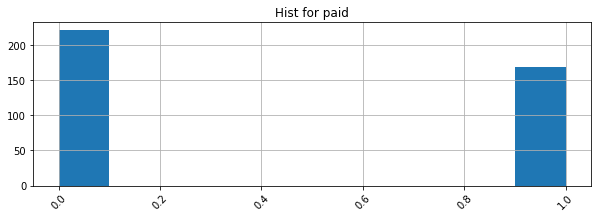

In [423]:
updateFeatureAuto(targetFeature, ['Fjob', 'Medu', 'Fedu', 'Mjob', 'famsup' ])

--------------------------------
# Устраняем NaN в internet

NaN в "internet" = 8% 
Исходное распределение


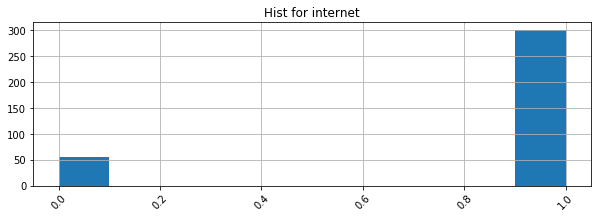

Предложенное АВТО распределение


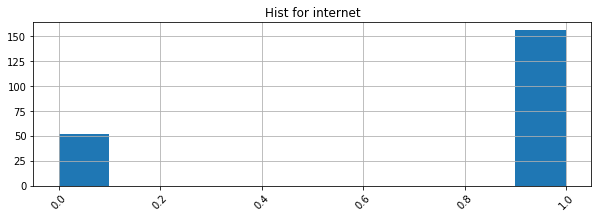

Выбранные колонки ['school', 'age', 'address', 'Medu', 'Fedu', 'paid']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [424]:
targetFeature = 'internet'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


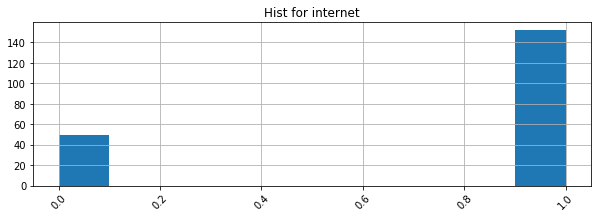

In [425]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['age', 'address', 'Medu', 'paid', 'goout'])

NaN в "internet"  33 
filter = (age == 18) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 4.0); index = 0
Выбрано 1 строк; Случаев 2;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
185       1.0   18      1.0   4.0   0.0    4.0      2

-------------------------------------------------------
filter = (age == 15) & (address == 1.0) & (Medu == 4.0) & (paid == 1.0) & (goout == 3.0); index = 12
Выбрано 2 строк; Случаев 4;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
7        0.0   15      1.0   4.0   1.0    3.0      1
81       1.0   15      1.0   4.0   1.0    3.0      4

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 3.0); index = 65
Выбрано 2 строк; Случаев 3;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
17        0.0   16      1.0   4.0   0.0    3.0      1
114       1.0   16      1.0   4.0   0.0    3.0      3

-------------------------------------------------------
filter = (age == 15) & (address == 1.0) & (Medu == 2.0) & (paid == 1.0) & (goout == 2.0); index = 80
Выбрано 1 строк; Случаев 1;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
67       1.0   15      1.0   2.0   1.0    2.0      1

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 2.0) & (paid == 0.0) & (goout == 4.0); index = 86
Выбрано 2 строк; Случаев 2;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
13        0.0   16      1.0   2.0   0.0    4.0      1
100       1.0   16      1.0   2.0   0.0    4.0      2

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 4.0); index = 98
Выбрано 1 строк; Случаев 2;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
115       1.0   16      1.0   4.0   0.0    4.0      2

-------------------------------------------------------
filter = (age == 15) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 3.0); index = 110
Выбрано 2 строк; Случаев 9;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
6        0.0   15      1.0   4.0   0.0    3.0      1
78       1.0   15      1.0   4.0   0.0    3.0      9

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 4.0); index = 115
Выбрано 1 строк; Случаев 3;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
115       1.0   16      1.0   4.0   0.0    4.0      3

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 2.0); index = 117
Выбрано 2 строк; Случаев 3;  Значение для internet=[0.]


internet  age  address  Medu  paid  goout  count
15        0.0   16      1.0   3.0   0.0    2.0      3
106       1.0   16      1.0   3.0   0.0    2.0      1

-------------------------------------------------------
filter = (age == 17) & (address == 0.0) & (Medu == 1.0) & (paid == 0.0) & (goout == 4.0); index = 118
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 15) & (address == 1.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 5.0); index = 125
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 17) & (address == 1.0) & (Medu == 2.0) & (paid == 0.0) & (goout == 4.0); index = 132
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 1.0); index = 133
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 2.0) & (paid == 0.0) & (goout == 3.0); index = 141
Выбрано 1 строк; Случаев 4;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
100       1.0   16      1.0   2.0   0.0    3.0      4

-------------------------------------------------------
filter = (age == 15) & (address == 0.0) & (Medu == 2.0) & (paid == 1.0) & (goout == 4.0); index = 155
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 1.0) & (paid == 0.0) & (goout == 4.0); index = 162
Выбрано 2 строк; Случаев 1;  Значение для internet=[0. 1.]


internet  age  address  Medu  paid  goout  count
11       0.0   16      1.0   1.0   0.0    4.0      1
95       1.0   16      1.0   1.0   0.0    4.0      1

-------------------------------------------------------
filter = (age == 17) & (address == 1.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 4.0); index = 185
Выбрано 1 строк; Случаев 3;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
148       1.0   17      1.0   3.0   0.0    4.0      3

-------------------------------------------------------
filter = (age == 17) & (address == 1.0) & (Medu == 1.0) & (paid == 0.0) & (goout == 3.0); index = 191
Выбрано 1 строк; Случаев 2;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
137       1.0   17      1.0   1.0   0.0    3.0      2

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 2.0) & (paid == 0.0) & (goout == 3.0); index = 194
Выбрано 1 строк; Случаев 5;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
101       1.0   16      1.0   2.0   0.0    3.0      5

-------------------------------------------------------
filter = (age == 17) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 4.0); index = 198
Выбрано 1 строк; Случаев 1;  Значение для internet=[0.]


internet  age  address  Medu  paid  goout  count
31       0.0   17      1.0   4.0   0.0    4.0      1

-------------------------------------------------------
filter = (age == 17) & (address == 1.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 4.0); index = 215
Выбрано 1 строк; Случаев 4;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
148       1.0   17      1.0   3.0   0.0    4.0      4

-------------------------------------------------------
filter = (age == 18) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 4.0); index = 239
Выбрано 1 строк; Случаев 3;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
190       1.0   18      1.0   4.0   0.0    4.0      3

-------------------------------------------------------
filter = (age == 16) & (address == 1.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 3.0); index = 251
Выбрано 1 строк; Случаев 4;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
110       1.0   16      1.0   3.0   0.0    3.0      4

-------------------------------------------------------
filter = (age == 19) & (address == 1.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 1.0); index = 257
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 18) & (address == 1.0) & (Medu == 2.0) & (paid == 0.0) & (goout == 4.0); index = 258
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 17) & (address == 1.0) & (Medu == 2.0) & (paid == 1.0) & (goout == 1.0); index = 259
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 17) & (address == 0.0) & (Medu == 1.0) & (paid == 1.0) & (goout == 2.0); index = 273
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 19) & (address == 0.0) & (Medu == 3.0) & (paid == 0.0) & (goout == 3.0); index = 308
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 18) & (address == 1.0) & (Medu == 2.0) & (paid == 0.0) & (goout == 3.0); index = 333
Выбрано 1 строк; Случаев 3;  Значение для internet=[1.]


internet  age  address  Medu  paid  goout  count
179       1.0   18      1.0   2.0   0.0    3.0      3

-------------------------------------------------------
filter = (age == 19) & (address == 1.0) & (Medu == 2.0) & (paid == 1.0) & (goout == 4.0); index = 340
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 18) & (address == 0.0) & (Medu == 4.0) & (paid == 0.0) & (goout == 3.0); index = 384
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 18) & (address == 0.0) & (Medu == 2.0) & (paid == 1.0) & (goout == 3.0); index = 385
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
filter = (age == 18) & (address == 1.0) & (Medu == 1.0) & (paid == 0.0) & (goout == 1.0); index = 389
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для internet=[1.]


Empty DataFrame
Columns: [internet, age, address, Medu, paid, goout, count]
Index: []

-------------------------------------------------------
Все NaN в "internet" успешно заменены.
----------------------- Проверка распределения internet после устранения NaN


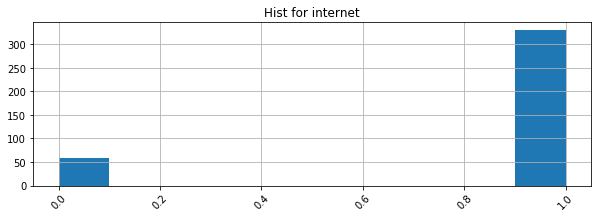

In [426]:
updateFeatureAuto(targetFeature, ['age', 'address', 'Medu', 'paid', 'goout'])

-------------------------------
# Устраняем NaN в famrel

In [427]:
targetFeature = 'famrel'
ok_list, test_list = get_FeaturesAuto(targetFeature)

NaN в "famrel" = 7% 
Выбранные колонки ['freetime']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


Распределение с учетом оптимизации параметров


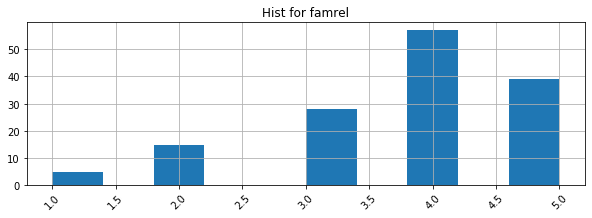

In [428]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['absences','Medu',  'Pstatus'])

NaN в "famrel"  26 
filter = (absences == 0.0) & (Medu == 3.0) & (Pstatus == 0.0); index = 8
Выбрано 2 строк; Случаев 3;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
52      4.0       0.0   3.0      0.0      1
107     5.0       0.0   3.0      0.0      3

-------------------------------------------------------
filter = (absences == 2.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 12
Выбрано 3 строк; Случаев 12;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
29      3.0       2.0   4.0      1.0      1
59      4.0       2.0   4.0      1.0     12
114     5.0       2.0   4.0      1.0      4

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 20
Выбрано 4 строк; Случаев 16;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
6       2.0       0.0   4.0      1.0      3
24      3.0       0.0   4.0      1.0      5
55      4.0       0.0   4.0      1.0     16
109     5.0       0.0   4.0      1.0      8

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 2.0) & (Pstatus == 1.0); index = 43
Выбрано 3 строк; Случаев 9;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
22      3.0       0.0   2.0      1.0      5
51      4.0       0.0   2.0      1.0      7
106     5.0       0.0   2.0      1.0      9

-------------------------------------------------------
filter = (absences == 2.0) & (Medu == 1.0) & (Pstatus == 1.0); index = 72
Выбрано 3 строк; Случаев 8;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
26      3.0       2.0   1.0      1.0      3
56      4.0       2.0   1.0      1.0      8
111     5.0       2.0   1.0      1.0      1

-------------------------------------------------------
filter = (absences == 2.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 73
Выбрано 2 строк; Случаев 3;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
58      4.0       2.0   3.0      1.0      3
113     5.0       2.0   3.0      1.0      1

-------------------------------------------------------
filter = (absences == 6.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 75
Выбрано 4 строк; Случаев 3;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
12      2.0       6.0   4.0      1.0      1
37      3.0       6.0   4.0      1.0      1
73      4.0       6.0   4.0      1.0      3
124     5.0       6.0   4.0      1.0      1

-------------------------------------------------------
filter = (absences == 6.0) & (Medu == 2.0) & (Pstatus == 1.0); index = 94
Выбрано 2 строк; Случаев 3;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
70      4.0       6.0   2.0      1.0      3
121     5.0       6.0   2.0      1.0      2

-------------------------------------------------------
filter = (absences == 4.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 102
Выбрано 4 строк; Случаев 6;  Значение для famrel=[4. 5.]


famrel  absences  Medu  Pstatus  count
10      2.0       4.0   4.0      1.0      1
33      3.0       4.0   4.0      1.0      3
67      4.0       4.0   4.0      1.0      6
119     5.0       4.0   4.0      1.0      6

-------------------------------------------------------
filter = (absences == 20.0) & (Medu == 1.0) & (Pstatus == 1.0); index = 118
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 136
Выбрано 3 строк; Случаев 12;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
23      3.0       0.0   3.0      1.0      2
53      4.0       0.0   3.0      1.0     12
109     5.0       0.0   3.0      1.0      7

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 2.0) & (Pstatus == 1.0); index = 160
Выбрано 3 строк; Случаев 10;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
22      3.0       0.0   2.0      1.0      5
51      4.0       0.0   2.0      1.0      7
107     5.0       0.0   2.0      1.0     10

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 2.0) & (Pstatus == 1.0); index = 195
Выбрано 3 строк; Случаев 11;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
22      3.0       0.0   2.0      1.0      5
51      4.0       0.0   2.0      1.0      7
107     5.0       0.0   2.0      1.0     11

-------------------------------------------------------
filter = (absences == 13.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 217
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 10.0) & (Medu == 2.0) & (Pstatus == 0.0); index = 229
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 75.0) & (Medu == 3.0) & (Pstatus == 0.0); index = 276
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 11.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 290
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 18.0) & (Medu == 1.0) & (Pstatus == 1.0); index = 309
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 9.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 317
Выбрано 1 строк; Случаев 1;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
139     5.0       9.0   4.0      1.0      1

-------------------------------------------------------
filter = (absences == 1.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 323
Выбрано 1 строк; Случаев 1;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
116     5.0       1.0   3.0      1.0      1

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 337
Выбрано 3 строк; Случаев 13;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
23      3.0       0.0   3.0      1.0      2
53      4.0       0.0   3.0      1.0     13
114     5.0       0.0   3.0      1.0      7

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 4.0) & (Pstatus == 1.0); index = 347
Выбрано 4 строк; Случаев 17;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
6       2.0       0.0   4.0      1.0      3
24      3.0       0.0   4.0      1.0      5
55      4.0       0.0   4.0      1.0     17
115     5.0       0.0   4.0      1.0      8

-------------------------------------------------------
filter = (absences == 10.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 349
Выбрано 2 строк; Случаев 2;  Значение для famrel=[5.]


famrel  absences  Medu  Pstatus  count
83      4.0      10.0   3.0      1.0      1
140     5.0      10.0   3.0      1.0      2

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 3.0) & (Pstatus == 1.0); index = 355
Выбрано 3 строк; Случаев 14;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
23      3.0       0.0   3.0      1.0      2
53      4.0       0.0   3.0      1.0     14
114     5.0       0.0   3.0      1.0      7

-------------------------------------------------------
filter = (absences == 0.0) & (Medu == 1.0) & (Pstatus == 0.0); index = 360
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для famrel=[4.]


Empty DataFrame
Columns: [famrel, absences, Medu, Pstatus, count]
Index: []

-------------------------------------------------------
filter = (absences == 14.0) & (Medu == 1.0) & (Pstatus == 1.0); index = 373
Выбрано 1 строк; Случаев 1;  Значение для famrel=[4.]


famrel  absences  Medu  Pstatus  count
92     4.0      14.0   1.0      1.0      1

-------------------------------------------------------
Все NaN в "famrel" успешно заменены.
----------------------- Проверка распределения famrel после устранения NaN


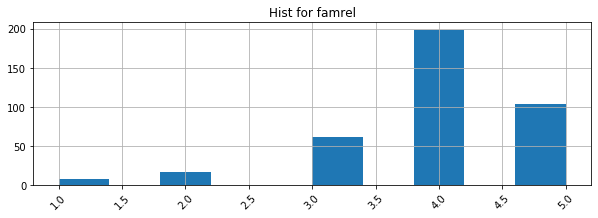

In [429]:
updateFeatureAuto(targetFeature, ['absences','Medu',  'Pstatus'])

---------------------------------------------------------
# Устраняем NaN в health

In [430]:
targetFeature = 'health'
ok_list, test_list = get_FeaturesAuto(targetFeature)

NaN в "health" = 0% 
Выбранные колонки ['goout']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


Распределение с учетом оптимизации параметров


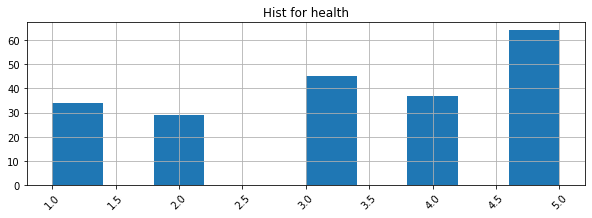

In [431]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['goout', 'Medu',  'reason'])

NaN в "health"  0 
Все NaN в "health" успешно заменены.
----------------------- Проверка распределения health после устранения NaN


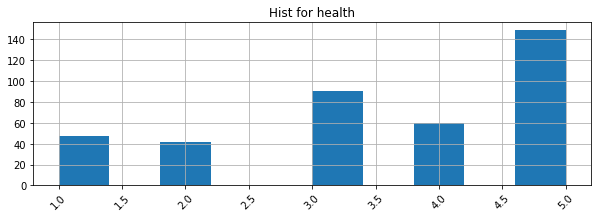

In [432]:
updateFeatureAuto(targetFeature, ['goout', 'Medu',  'reason'])

----------------------------------------------
# Устраняем NaN в Pstatus

NaN в "Pstatus" = 12% 
Исходное распределение


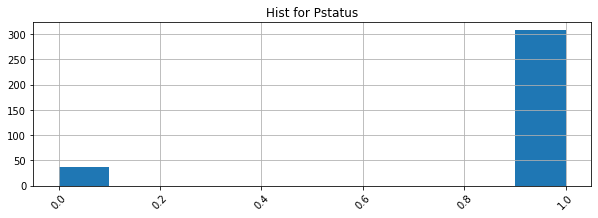

Предложенное АВТО распределение


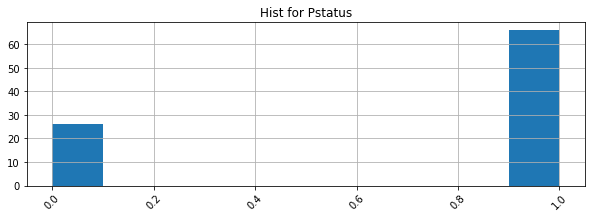

Выбранные колонки ['Medu', 'absences']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [433]:
targetFeature = 'Pstatus'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


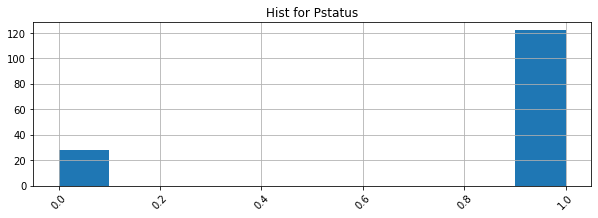

In [434]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, ['Medu', 'Fedu', 'famrel','reason'])

NaN в "Pstatus"  45 
filter = (Medu == 1.0) & (Fedu == 1.0) & (famrel == 5.0) & (reason == "course"); index = 1
Выбрано 1 строк; Случаев 6;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
40      1.0   1.0   1.0     5.0  course      6

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 4.0) & (famrel == 5.0) & (reason == "home"); index = 9
Выбрано 2 строк; Случаев 1;  Значение для Pstatus=[0. 1.]


Pstatus  Medu  Fedu  famrel reason  count
16       0.0   3.0   4.0     5.0   home      1
112      1.0   3.0   4.0     5.0   home      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 4.0) & (famrel == 5.0) & (reason == "reputation"); index = 11
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Pstatus=[1.]


Empty DataFrame
Columns: [Pstatus, Medu, Fedu, famrel, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famrel == 4.0) & (reason == "home"); index = 15
Выбрано 2 строк; Случаев 3;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
24       0.0   4.0   4.0     4.0   home      2
144      1.0   4.0   4.0     4.0   home      3

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 2.0) & (famrel == 1.0) & (reason == "home"); index = 25
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Pstatus=[1.]


Empty DataFrame
Columns: [Pstatus, Medu, Fedu, famrel, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 4.0) & (famrel == 5.0) & (reason == "home"); index = 28
Выбрано 2 строк; Случаев 2;  Значение для Pstatus=[0.]


Pstatus  Medu  Fedu  famrel reason  count
16       0.0   3.0   4.0     5.0   home      2
114      1.0   3.0   4.0     5.0   home      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famrel == 5.0) & (reason == "other"); index = 54
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Pstatus=[1.]


Empty DataFrame
Columns: [Pstatus, Medu, Fedu, famrel, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famrel == 3.0) & (reason == "home"); index = 63
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
129      1.0   4.0   3.0     3.0   home      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == nan) & (famrel == 4.0) & (reason == "course"); index = 67
filter = (Medu == 2.0) & (Fedu == 3.0) & (famrel == 5.0) & (reason == "home"); index = 81
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
81      1.0   2.0   3.0     5.0   home      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famrel == 3.0) & (reason == "reputation"); index = 96
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
130      1.0   4.0   3.0     3.0  reputation      2

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famrel == 1.0) & (reason == "home"); index = 108
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
137      1.0   4.0   4.0     1.0   home      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 2.0) & (famrel == 3.0) & (reason == "course"); index = 112
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
64      1.0   2.0   2.0     3.0  course      2

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 1.0) & (famrel == 4.0) & (reason == "course"); index = 131
Выбрано 1 строк; Случаев 3;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
36      1.0   1.0   1.0     4.0  course      3

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famrel == 4.0) & (reason == "course"); index = 139
Выбрано 2 строк; Случаев 7;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
23       0.0   4.0   4.0     4.0  course      1
145      1.0   4.0   4.0     4.0  course      7

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 2.0) & (famrel == 4.0) & (reason == "course"); index = 147
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
45      1.0   1.0   2.0     4.0  course      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 1.0) & (famrel == 4.0) & (reason == "course"); index = 149
Выбрано 2 строк; Случаев 5;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
1       0.0   2.0   1.0     4.0  course      1
55      1.0   2.0   1.0     4.0  course      5

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 2.0) & (famrel == 4.0) & (reason == "home"); index = 153
Выбрано 2 строк; Случаев 2;  Значение для Pstatus=[0. 1.]


Pstatus  Medu  Fedu  famrel reason  count
9       0.0   3.0   2.0     4.0   home      2
95      1.0   3.0   2.0     4.0   home      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 2.0) & (famrel == 4.0) & (reason == "course"); index = 158
Выбрано 1 строк; Случаев 11;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
67      1.0   2.0   2.0     4.0  course     11

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famrel == 4.0) & (reason == "reputation"); index = 174
Выбрано 2 строк; Случаев 5;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
13       0.0   3.0   3.0     4.0  reputation      1
105      1.0   3.0   3.0     4.0  reputation      5

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 4.0) & (famrel == 5.0) & (reason == "reputation"); index = 182
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
84      1.0   2.0   4.0     5.0  reputation      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famrel == 5.0) & (reason == "reputation"); index = 183
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
108      1.0   3.0   3.0     5.0  reputation      2

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 2.0) & (famrel == 3.0) & (reason == "course"); index = 186
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
43      1.0   1.0   2.0     3.0  course      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famrel == 4.0) & (reason == "reputation"); index = 193
Выбрано 2 строк; Случаев 7;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
18       0.0   4.0   3.0     4.0  reputation      2
133      1.0   4.0   3.0     4.0  reputation      7

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famrel == 3.0) & (reason == "home"); index = 197
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Pstatus=[1.]


Empty DataFrame
Columns: [Pstatus, Medu, Fedu, famrel, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famrel == 4.0) & (reason == "home"); index = 198
Выбрано 2 строк; Случаев 4;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
24       0.0   4.0   4.0     4.0   home      2
147      1.0   4.0   4.0     4.0   home      4

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 3.0) & (famrel == 4.0) & (reason == "reputation"); index = 210
Выбрано 2 строк; Случаев 6;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
13       0.0   3.0   3.0     4.0  reputation      1
106      1.0   3.0   3.0     4.0  reputation      6

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 3.0) & (famrel == 5.0) & (reason == "reputation"); index = 227
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Pstatus=[1.]


Empty DataFrame
Columns: [Pstatus, Medu, Fedu, famrel, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 1.0) & (famrel == 3.0) & (reason == "home"); index = 234
Выбрано 1 строк; Случаев 3;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
35      1.0   1.0   1.0     3.0   home      3

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 2.0) & (famrel == 5.0) & (reason == "reputation"); index = 239
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
128      1.0   4.0   2.0     5.0  reputation      1

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 1.0) & (famrel == 4.0) & (reason == "course"); index = 245
Выбрано 2 строк; Случаев 6;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
1       0.0   2.0   1.0     4.0  course      1
55      1.0   2.0   1.0     4.0  course      6

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 1.0) & (famrel == 3.0) & (reason == "other"); index = 252
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
54      1.0   2.0   1.0     3.0  other      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famrel == 3.0) & (reason == "home"); index = 260
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
131      1.0   4.0   3.0     3.0   home      2

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 4.0) & (famrel == 4.0) & (reason == "reputation"); index = 265
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Pstatus=[1.]


Empty DataFrame
Columns: [Pstatus, Medu, Fedu, famrel, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 1.0) & (famrel == 5.0) & (reason == "other"); index = 266
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
91      1.0   3.0   1.0     5.0  other      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 2.0) & (famrel == 5.0) & (reason == "reputation"); index = 268
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
129      1.0   4.0   2.0     5.0  reputation      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 3.0) & (famrel == 4.0) & (reason == "reputation"); index = 271
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
79      1.0   2.0   3.0     4.0  reputation      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 1.0) & (famrel == 5.0) & (reason == "reputation"); index = 282
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
41      1.0   1.0   1.0     5.0  reputation      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 3.0) & (famrel == 4.0) & (reason == "reputation"); index = 298
Выбрано 2 строк; Случаев 8;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
18       0.0   4.0   3.0     4.0  reputation      2
136      1.0   4.0   3.0     4.0  reputation      8

-------------------------------------------------------
filter = (Medu == 4.0) & (Fedu == 4.0) & (famrel == 4.0) & (reason == "reputation"); index = 307
Выбрано 2 строк; Случаев 9;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
25       0.0   4.0   4.0     4.0  reputation      1
151      1.0   4.0   4.0     4.0  reputation      9

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 2.0) & (famrel == 4.0) & (reason == "reputation"); index = 313
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
97      1.0   3.0   2.0     4.0  reputation      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fedu == 2.0) & (famrel == 4.0) & (reason == "home"); index = 333
Выбрано 2 строк; Случаев 4;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
5       0.0   2.0   2.0     4.0   home      1
68      1.0   2.0   2.0     4.0   home      4

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 4.0) & (famrel == 4.0) & (reason == "home"); index = 342
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel reason  count
115      1.0   3.0   4.0     4.0   home      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fedu == 2.0) & (famrel == 1.0) & (reason == "reputation"); index = 357
Выбрано 1 строк; Случаев 1;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel      reason  count
93      1.0   3.0   2.0     1.0  reputation      1

-------------------------------------------------------
filter = (Medu == 1.0) & (Fedu == 2.0) & (famrel == 3.0) & (reason == "course"); index = 364
Выбрано 1 строк; Случаев 2;  Значение для Pstatus=[1.]


Pstatus  Medu  Fedu  famrel  reason  count
43      1.0   1.0   2.0     3.0  course      2

-------------------------------------------------------
НЕ Все NaN в "Pstatus" успешно заменены, осталось 1 из 389
Все NaN в "Pstatus" успешно заменены.
----------------------- Проверка распределения Pstatus после устранения NaN


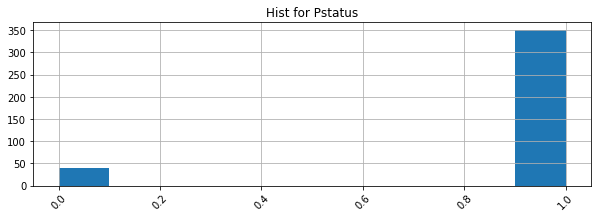

In [435]:
updateFeatureAuto(targetFeature, ['Medu', 'Fedu', 'famrel','reason'])

----------------------------------------------------
# Устраняем NaN в Fedu

NaN в "Fedu" = 6% 
Исходное распределение


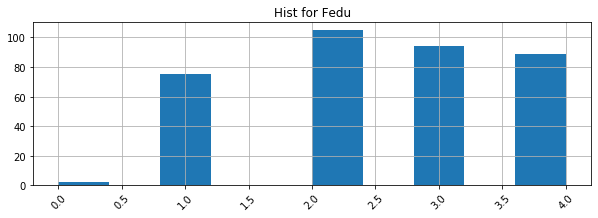

Предложенное АВТО распределение


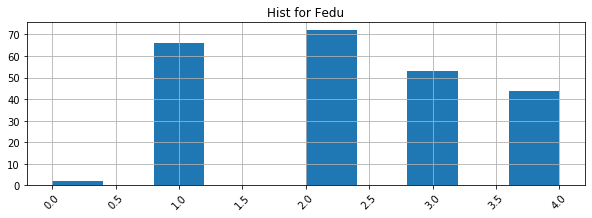

Выбранные колонки ['age', 'Medu', 'failures', 'famsup', 'nursery', 'higher', 'internet']
Колонки для ручного анализа ['Mjob', 'Fjob', 'reason', 'guardian', 'studytime granular']


In [436]:
targetFeature = 'Fedu'
ok_list, test_list = get_FeaturesAuto(targetFeature)

Распределение с учетом оптимизации параметров


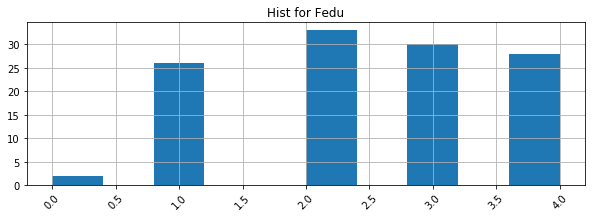

In [437]:
#Нужно выбрать 4-5 фич НЕ более, иначе не найдем похожих
test_FeaturesAutoHist(targetFeature, [ 'Medu', 'Fjob',  'reason'])

NaN в "Fedu"  24 
filter = (Medu == 4.0) & (Fjob == "health") & (reason == "other"); index = 21
Выбрано 1 строк; Случаев 1;  Значение для Fedu=[4.]


Fedu  Medu    Fjob reason  count
105   4.0   4.0  health  other      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "teacher") & (reason == "course"); index = 42
Выбрано 1 строк; Случаев 8;  Значение для Fedu=[4.]


Fedu  Medu     Fjob  reason  count
115   4.0   4.0  teacher  course      8

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "services") & (reason == "home"); index = 46
Выбрано 3 строк; Случаев 4;  Значение для Fedu=[3.]


Fedu  Medu      Fjob reason  count
53    2.0   3.0  services   home      3
78    3.0   3.0  services   home      4
102   4.0   3.0  services   home      2

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "health") & (reason == "reputation"); index = 57
Выбрано 1 строк; Случаев 3;  Значение для Fedu=[4.]


Fedu  Medu    Fjob      reason  count
106   4.0   4.0  health  reputation      3

-------------------------------------------------------
filter = (Medu == 1.0) & (Fjob == "at_home") & (reason == "home"); index = 58
Выбрано 1 строк; Случаев 1;  Значение для Fedu=[2.]


Fedu  Medu     Fjob reason  count
30   2.0   1.0  at_home   home      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "other") & (reason == "course"); index = 67
Выбрано 4 строк; Случаев 6;  Значение для Fedu=[4.]


Fedu  Medu   Fjob  reason  count
22   1.0   3.0  other  course      2
48   2.0   3.0  other  course      5
73   3.0   3.0  other  course      2
98   4.0   3.0  other  course      6

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "other") & (reason == "course"); index = 137
Выбрано 4 строк; Случаев 7;  Значение для Fedu=[4.]


Fedu  Medu   Fjob  reason  count
22   1.0   3.0  other  course      2
48   2.0   3.0  other  course      5
73   3.0   3.0  other  course      2
98   4.0   3.0  other  course      7

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "services") & (reason == "course"); index = 142
Выбрано 2 строк; Случаев 5;  Значение для Fedu=[3.]


Fedu  Medu      Fjob  reason  count
88    3.0   4.0  services  course      5
111   4.0   4.0  services  course      4

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "services") & (reason == "course"); index = 159
Выбрано 4 строк; Случаев 3;  Значение для Fedu=[1. 3.]


Fedu  Medu      Fjob  reason  count
26    1.0   3.0  services  course      3
52    2.0   3.0  services  course      2
77    3.0   3.0  services  course      3
101   4.0   3.0  services  course      1

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "other") & (reason == "course"); index = 161
Выбрано 4 строк; Случаев 8;  Значение для Fedu=[4.]


Fedu  Medu   Fjob  reason  count
22   1.0   3.0  other  course      2
48   2.0   3.0  other  course      5
73   3.0   3.0  other  course      2
98   4.0   3.0  other  course      8

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "other") & (reason == "home"); index = 180
Выбрано 3 строк; Случаев 6;  Значение для Fedu=[3. 4.]


Fedu  Medu   Fjob reason  count
55    2.0   4.0  other   home      3
85    3.0   4.0  other   home      6
108   4.0   4.0  other   home      6

-------------------------------------------------------
filter = (Medu == 2.0) & (Fjob == "services") & (reason == "course"); index = 195
Выбрано 3 строк; Случаев 5;  Значение для Fedu=[3.]


Fedu  Medu      Fjob  reason  count
18   1.0   2.0  services  course      1
44   2.0   2.0  services  course      4
68   3.0   2.0  services  course      5

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "teacher") & (reason == "reputation"); index = 232
Выбрано 1 строк; Случаев 4;  Значение для Fedu=[4.]


Fedu  Medu     Fjob      reason  count
118   4.0   4.0  teacher  reputation      4

-------------------------------------------------------
filter = (Medu == 2.0) & (Fjob == "other") & (reason == "home"); index = 236
Выбрано 3 строк; Случаев 9;  Значение для Fedu=[2.]


Fedu  Medu   Fjob reason  count
15   1.0   2.0  other   home      4
41   2.0   2.0  other   home      9
65   3.0   2.0  other   home      3

-------------------------------------------------------
filter = (Medu == 2.0) & (Fjob == "services") & (reason == "course"); index = 259
Выбрано 3 строк; Случаев 6;  Значение для Fedu=[3.]


Fedu  Medu      Fjob  reason  count
18   1.0   2.0  services  course      1
44   2.0   2.0  services  course      4
68   3.0   2.0  services  course      6

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "other") & (reason == "home"); index = 280
Выбрано 3 строк; Случаев 7;  Значение для Fedu=[3.]


Fedu  Medu   Fjob reason  count
55    2.0   4.0  other   home      3
85    3.0   4.0  other   home      7
108   4.0   4.0  other   home      6

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "services") & (reason == "home"); index = 281
Выбрано 3 строк; Случаев 5;  Значение для Fedu=[3.]


Fedu  Medu      Fjob reason  count
53    2.0   3.0  services   home      3
78    3.0   3.0  services   home      5
102   4.0   3.0  services   home      2

-------------------------------------------------------
filter = (Medu == 2.0) & (Fjob == "at_home") & (reason == "other"); index = 286
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fedu=[2.]


Empty DataFrame
Columns: [Fedu, Medu, Fjob, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 1.0) & (Fjob == "teacher") & (reason == "reputation"); index = 287
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0;  Значение для Fedu=[2.]


Empty DataFrame
Columns: [Fedu, Medu, Fjob, reason, count]
Index: []

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "other") & (reason == "home"); index = 290
Выбрано 3 строк; Случаев 8;  Значение для Fedu=[3.]


Fedu  Medu   Fjob reason  count
57    2.0   4.0  other   home      3
87    3.0   4.0  other   home      8
110   4.0   4.0  other   home      6

-------------------------------------------------------
filter = (Medu == 1.0) & (Fjob == "services") & (reason == "home"); index = 310
Выбрано 2 строк; Случаев 1;  Значение для Fedu=[1. 3.]


Fedu  Medu      Fjob reason  count
10   1.0   1.0  services   home      1
65   3.0   1.0  services   home      1

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "services") & (reason == "course"); index = 328
Выбрано 2 строк; Случаев 6;  Значение для Fedu=[3.]


Fedu  Medu      Fjob  reason  count
90    3.0   4.0  services  course      6
113   4.0   4.0  services  course      4

-------------------------------------------------------
filter = (Medu == 3.0) & (Fjob == "other") & (reason == "course"); index = 349
Выбрано 4 строк; Случаев 9;  Значение для Fedu=[4.]


Fedu  Medu   Fjob  reason  count
22    1.0   3.0  other  course      2
50    2.0   3.0  other  course      5
75    3.0   3.0  other  course      2
100   4.0   3.0  other  course      9

-------------------------------------------------------
filter = (Medu == 4.0) & (Fjob == "other") & (reason == "reputation"); index = 374
Выбрано 3 строк; Случаев 10;  Значение для Fedu=[3.]


Fedu  Medu   Fjob      reason  count
59    2.0   4.0  other  reputation      3
89    3.0   4.0  other  reputation     10
112   4.0   4.0  other  reputation      7

-------------------------------------------------------
Все NaN в "Fedu" успешно заменены.
----------------------- Проверка распределения Fedu после устранения NaN


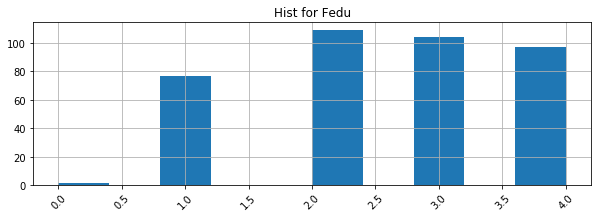

In [438]:
updateFeatureAuto(targetFeature,[ 'Medu', 'Fjob',  'reason'])

------------------------------------------------

In [439]:
test_ds_NaN()

Все NaN в "school" успешно заменены.
Все NaN в "sex" успешно заменены.
Все NaN в "age" успешно заменены.
Все NaN в "address" успешно заменены.
Все NaN в "famsize" успешно заменены.
Все NaN в "Pstatus" успешно заменены.
Все NaN в "Medu" успешно заменены.
Все NaN в "Fedu" успешно заменены.
Все NaN в "Mjob" успешно заменены.
Все NaN в "Fjob" успешно заменены.
Все NaN в "reason" успешно заменены.
Все NaN в "guardian" успешно заменены.
Все NaN в "traveltime" успешно заменены.
Все NaN в "studytime" успешно заменены.
Все NaN в "failures" успешно заменены.
Все NaN в "schoolsup" успешно заменены.
Все NaN в "famsup" успешно заменены.
Все NaN в "paid" успешно заменены.
Все NaN в "activities" успешно заменены.
Все NaN в "nursery" успешно заменены.
Все NaN в "studytime, granular" успешно заменены.
Все NaN в "higher" успешно заменены.
Все NaN в "internet" успешно заменены.
Все NaN в "romantic" успешно заменены.
Все NaN в "famrel" успешно заменены.
Все NaN в "freetime" успешно заменены.
Все NaN в "go

In [440]:
df.drop(columns=['idx'], inplace=True)

# Все вылеты и NaN устранены
-----------------------------------------
-------------------------------------------


--------------------------------
# Найдены статистически значимые различия: address, Medu, Mjob, failures, higher, romantic, goout


In [441]:
test_df_stat_dif(df=df)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки goout


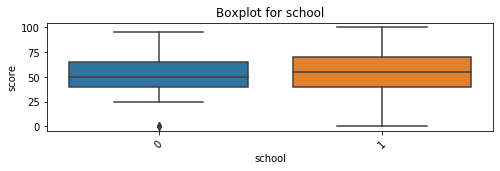

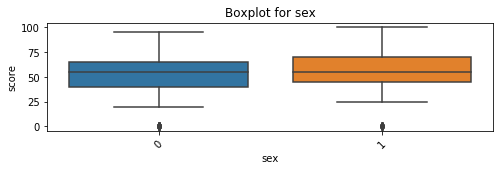

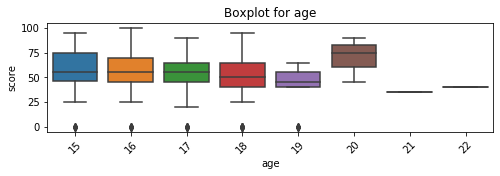

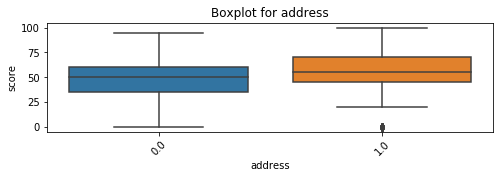

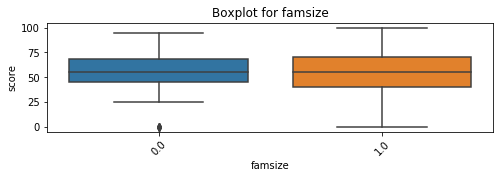

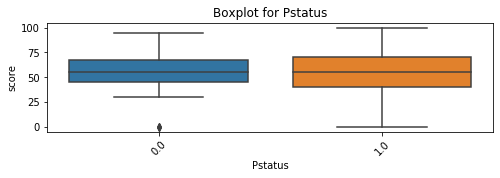

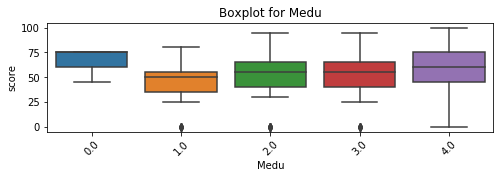

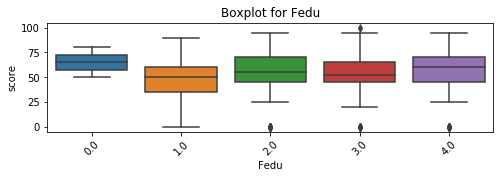

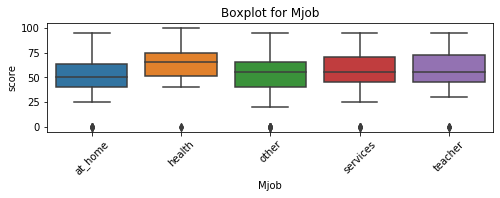

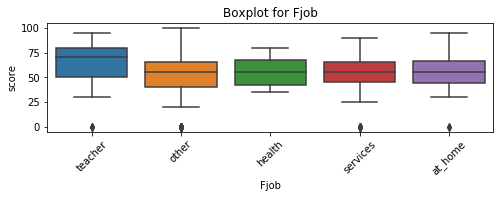

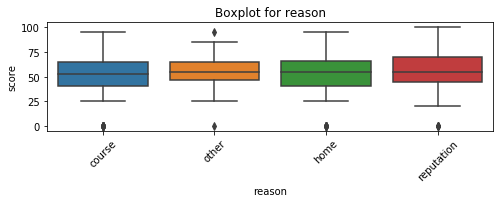

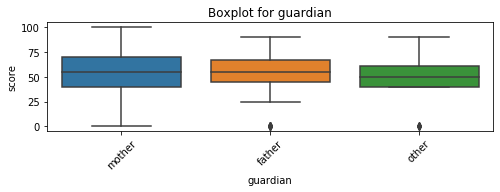

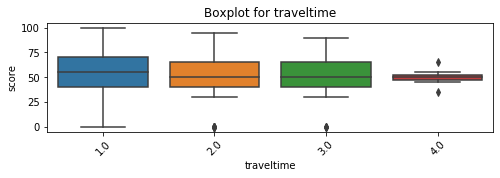

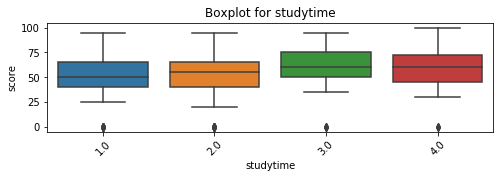

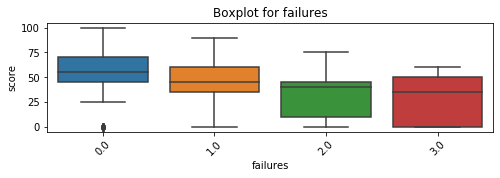

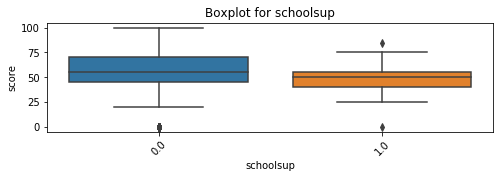

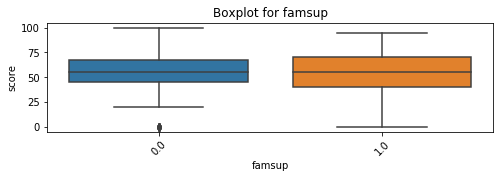

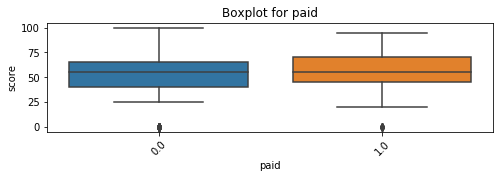

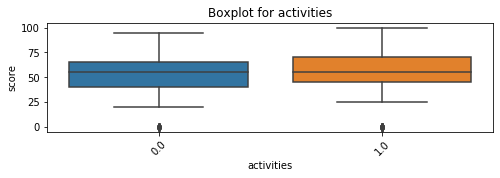

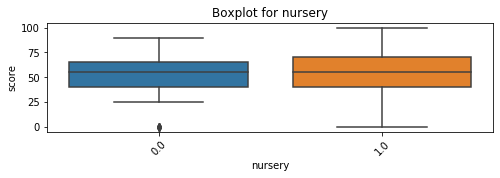

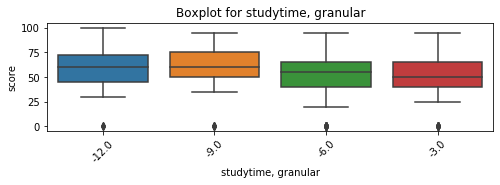

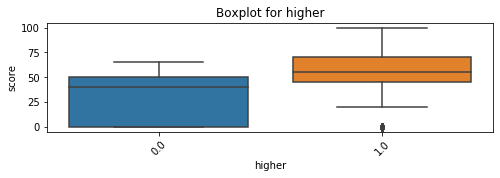

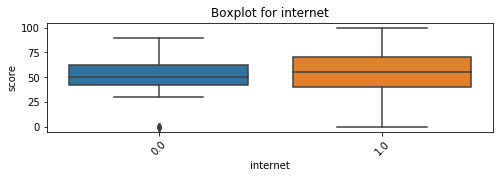

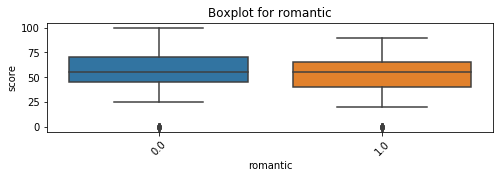

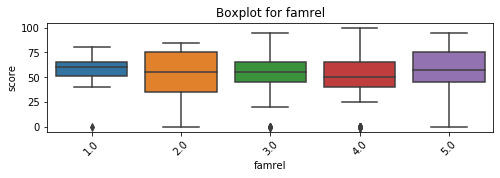

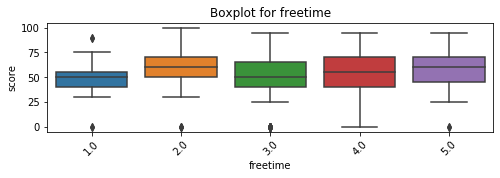

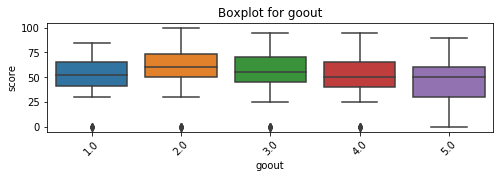

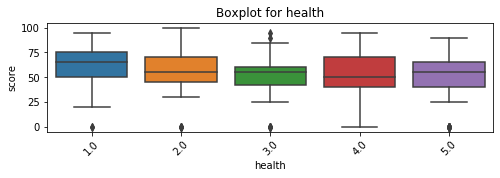

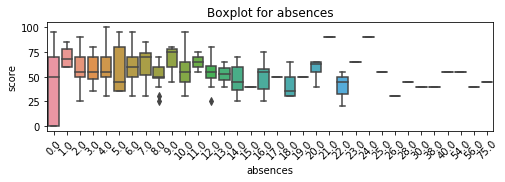

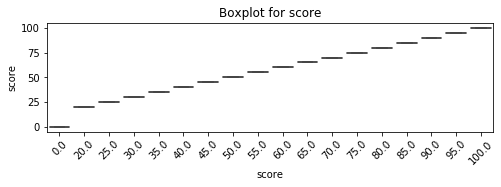

In [442]:
for col in df.columns: #['school','sex','address','famsize','Pstatus','Mjob', 'Medu','Fedu','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']:
    get_boxplot(col)

# 'Medu','Fedu' == 0 - похоже что это скрытый пропуск - это скорее всего 4

----------------------------------------------------------
# Корреляция: 0.105 - Критическое значение коэффициента корреляции для N = 350 и p = 0.05

In [443]:
df[['age','absences','score']].corr()

age  absences     score
age       1.000000  0.164352 -0.155726
absences  0.164352  1.000000  0.025257
score    -0.155726  0.025257  1.000000

# В результате, Значимые столбцы:
#  'address','Mjob','Medu','Fedu' ,'Fjob', 'studytime', 'failures', 'higher','romantic', 'goout'



Перекодируем 'Mjob' 'Fjob' --> 'teacher' == 0, 'health' == 1, 'services' == 2, 'at_home' == 3, 'other' == 4

In [444]:
changeVal(['Mjob','Fjob'], 'teacher' , 0, 'health',1 )
changeVal(['Mjob','Fjob'], 'services', 2,'at_home', 3)
changeVal(['Mjob','Fjob'], 'other', 4,'','')

changeVal(['reason'], 'home',  0, 'reputation',1) 
changeVal(['reason'], 'course', 2,'other',3) 

changeVal(['guardian'], 'mother', 0,'father',1) 
changeVal(['guardian'], 'other', 2,'','')

df.loc[:,['address','Mjob','Medu','Fedu' ,'Fjob', 'studytime', 'failures', 'higher','romantic', 'goout']].apply(pd.to_numeric, errors='ignore')


address  Mjob  Medu  Fedu  Fjob  studytime  failures  higher  romantic  \
0        1.0     3   4.0   4.0     0        2.0       0.0     1.0       0.0   
1        1.0     3   1.0   1.0     4        2.0       0.0     1.0       0.0   
2        1.0     3   1.0   1.0     4        2.0       3.0     1.0       0.0   
3        1.0     1   4.0   2.0     4        3.0       0.0     1.0       1.0   
4        1.0     4   3.0   3.0     4        2.0       0.0     1.0       0.0   
..       ...   ...   ...   ...   ...        ...       ...     ...       ...   
390      1.0     2   2.0   2.0     2        2.0       2.0     1.0       0.0   
391      1.0     2   3.0   1.0     2        1.0       0.0     1.0       0.0   
392      0.0     4   1.0   1.0     4        1.0       3.0     1.0       0.0   
393      0.0     2   3.0   2.0     4        1.0       0.0     1.0       0.0   
394      1.0     4   1.0   1.0     3        1.0       0.0     1.0       0.0   

     goout  
0      4.0  
1      3.0  
2      2.0  
3      2.0  
4      2.0  
..     ...  
390    4.0  
391    5.0  
392    3.0  
393    1.0  
394    3.0  

[389 rows x 10 columns]

--------------------------------
-------------------------------------
Итого: \['address','Mjob','Medu','Fedu' ,'Fjob', 'studytime', 'failures', 'higher','romantic', 'goout'\]

In [445]:
df.reason.value_counts()

2    148
0    104
1    103
3     34
Name: reason, dtype: int64

In [352]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
school                 389 non-null int64
sex                    389 non-null int64
age                    389 non-null int64
address                389 non-null float64
famsize                389 non-null float64
Pstatus                389 non-null float64
Medu                   389 non-null float64
Fedu                   389 non-null float64
Mjob                   389 non-null int64
Fjob                   389 non-null int64
reason                 389 non-null object
guardian               389 non-null int64
traveltime             389 non-null float64
studytime              389 non-null float64
failures               389 non-null float64
schoolsup              389 non-null float64
famsup                 389 non-null float64
paid                   389 non-null float64
activities             389 non-null float64
nursery                389 non-null float64
studytime, granular    389 n